In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
from pathlib import Path
from collections import namedtuple, defaultdict
import itertools
import functools
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
from torchvision.transforms.functional import resized_crop
from multimodal.multimodal_saycam_data_module import MultiModalSAYCamDataModule
from multimodal.coco_captions_data_module import COCOCaptionsDataModule
from multimodal.multimodal import TextEncoder, MultiModalModel, LanguageModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID, normalizer
from multimodal.utils import map_structure
from ngram import NGramModel
from train import _setup_parser
from representation_similarity import *

figsize = (13, 12)
sns.set_theme(
    style='white',
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.grid': False,
        'xtick.bottom': False,
        'xtick.top': False,
        'ytick.left': False,
        'ytick.right': False,
        'axes.spines.left': False,
        'axes.spines.bottom': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

np.set_printoptions(suppress=True, precision=2, linewidth=120)
pd.options.display.width = 120

def get_n_rows(n_items, n_cols):
    return (n_items - 1) // n_cols + 1

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
pos_mappings = [
    ('pos0', {
        "''": ".",
        ",": ".",
        ".": ".",
        ":": ".",
        "ADD": "UH",
        "CC": "CC",
        "CD": "CD",
        "DT": "DT",
        "EX": "EX",
        "FW": "UH",
        "IN": "IN",
        "JJ": "JJ",
        "JJR": "JJR",
        "JJS": "JJS",
        "LS": ".",
        "MD": "MD",
        "NFP": "UH",
        "NN": "NN",
        "NNP": "NNP",
        "NNPS": "NNS",
        "NNS": "NNS",
        "PDT": "PDT",
        "POS": "POS",
        "PRP": "PRP",
        "PRP$": "PRP$",
        "RB": "RB",
        "RBR": "RBR",
        "RBS": "RBS",
        "RP": "RP",
        "SYM": ".",
        "TO": "TO",
        "UH": "UH",
        "VB": "VB",
        "VBD": "VBD",
        "VBG": "VBG",
        "VBN": "VBN",
        "VBP": "VBP",
        "VBZ": "VBZ",
        "WDT": "WDT",
        "WP": "WP",
        "WP$": "WP$",
        "WRB": "WRB",
        "``": ".",
    }),
    ('pos1', {
        "''": ".",
        ",": ".",
        ".": ".",
        ":": ".",
        "ADD": "UH",
        "CC": "CC",
        "CD": "CD",
        "DT": "DT",
        "EX": "PRP",
        "FW": "UH",
        "IN": "IN",
        "JJ": "adjective",
        "JJR": "adjective",
        "JJS": "adjective",
        "LS": ".",
        "MD": "MD",
        "NFP": "UH",
        "NN": "noun",
        "NNP": "noun",
        "NNPS": "noun",
        "NNS": "noun",
        "PDT": "DT",
        "POS": "POS",
        "PRP": "PRP",
        "PRP$": "PRP",
        "RB": "adverb",
        "RBR": "adverb",
        "RBS": "adverb",
        "RP": "RP",
        "SYM": ".",
        "TO": "TO",
        "UH": "UH",
        "VB": "verb",
        "VBD": "verb",
        "VBG": "verb",
        "VBN": "verb",
        "VBP": "verb",
        "VBZ": "verb",
        "WDT": "wh-word",
        "WP": "wh-word",
        "WP$": "wh-word",
        "WRB": "wh-word",
        "``": ".",
    }),
    ('pos2', {
        "''": ".",
        ",": ".",
        ".": ".",
        ":": ".",
        "ADD": ".",
        "CC": "function word",
        "CD": "cardinal number",
        "DT": "function word",
        "EX": "function word",
        "FW": ".",
        "IN": "function word",
        "JJ": "adjective",
        "JJR": "adjective",
        "JJS": "adjective",
        "LS": ".",
        "MD": "function word",
        "NFP": ".",
        "NN": "noun",
        "NNP": "noun",
        "NNPS": "noun",
        "NNS": "noun",
        "PDT": "function word",
        "POS": "function word",
        "PRP": "function word",
        "PRP$": "function word",
        "RB": "adverb",
        "RBR": "adverb",
        "RBS": "adverb",
        "RP": "function word",
        "SYM": ".",
        "TO": "function word",
        "UH": ".",
        "VB": "verb",
        "VBD": "verb",
        "VBG": "verb",
        "VBN": "verb",
        "VBP": "verb",
        "VBZ": "verb",
        "WDT": "function word",
        "WP": "function word",
        "WP$": "function word",
        "WRB": "function word",
        "``": ".",
    }),
]

pos_palette = {
    "''": "black",
    "``": "black",
    ",": "black",
    ".": "black",
    ":": "black",
    ".": "black",
    "LS": "black",
    "SYM": "black",
    "CC": "brown",
    "cardinal number": "tab:gray",
    "CD": "tab:gray",
    "DT": "salmon",
    "EX": "rosybrown",
    "function word": "tab:purple",
    "IN": "tab:purple",
    "adjective": "tab:orange",
    "JJ": "tab:orange",
    "JJR": "gold",
    "JJS": "yellow",
    "MD": "rosybrown",
    "noun": "tab:blue",
    "NN": "tab:blue",
    "NNP": "navy",
    "NNS": "cadetblue",
    "PDT": "saddlebrown",
    "POS": "grey",
    "PRP": "tab:olive",
    "PRP$": "olivedrab",
    "adverb": "tab:pink",
    "RB": "tab:pink",
    "RBR": "magenta",
    "RBS": "palevioletred",
    "RP": "darkviolet",
    "TO": "indigo",
    "ADD": "tab:green",
    "FW": "tab:green",
    "NFP": "tab:green",
    "UH": "tab:green",
    "verb": "tab:red",
    "VB": "tab:red",
    "VBD": "salmon",
    "VBG": "orangered",
    "VBN": "chocolate",
    "VBP": "pink",
    "VBZ": "crimson",
    "WDT": "darkcyan",
    "WP": "slateblue",
    "WP$": "darkslateblue",
    "wh-word": "tab:cyan",
    "WRB": "tab:cyan",
}

In [4]:
possessives = (
"'s ’s s",
)
negations = (
"not n't n’t nt",
)
be_verbs = (
"be being been",
"am 'm ’m m",
"are 're ’re re",
"aren't aren’t arent",
"were weren't weren’t werent",
"is 's ’s s",
"isn't isn’t isnt",
"was wasn't wasn’t wasnt",
)
do_verbs = (
"do don't don’t dont",
"does doesn't doesn’t doesnt",
"did didn't didn’t didnt",
"done",
)
modal_verbs = (
"have 've ’ve ve",
"will 'll ’ll ll",
)
pronoun_contractions = (
"i'm i’m im",
"you're you’re youre",
"we're we’re were",
"they're they’re theyre",
"he's he’s hes",
"she's she’s shes",
"it's it’s",
"i've i’ve ive",
"you've you’ve youve",
"we've we’ve weve",
"i'll i’ll",
"you'll you’ll",
"we'll we’ll",
"he'll he’ll",
"she'll she’ll",
"it'll it’ll",
"here's here’s heres",
"there's there’s theres",
"that's that’s thats",
"what's what’s whats",
"where's where’s wheres",
)
other_contractions = (
"let's let’s lets",
)
quantifiers = (
"lot lots",
"bit",
"one",
)
pos_ambiguous_words = (
"looking",
"rub",
"boop",
"bye",
"love",
)
special_tokens = (
"<unk>",
)
untypical_words = ' '.join((possessives + negations + be_verbs + pronoun_contractions + other_contractions + quantifiers + pos_ambiguous_words)).split()

subcats = [
    ("sounds", "blup ohp woof hm blu ruff yeahhh woops", "noise music cluck clunk oink quack m"),
    ("animals", "kitty bear doggy duck bunny birdies cow birdie bears sheep cows birds hippo birdy eagle bird ladybug lion lamb koala animals frog penguin cockatoo eagles", "chicken"),
    ("vehicles", "truck train car trucks cars bicycle bus", "boat"),
    ("toys", "ball balls balloon puzzle puzzles toy toys", "book books page paper stick dummy bubbles bricks painting"),
    ("food_drink", "banana water eggs egg apple milk bread sushi juice browns lunch pear breakfast food biscuit coffee hash strawberry apples rice hashbrowns oil sugar bananas biscuits cake", "cream"),
    ("clothing", "shoes socks jacket sock pants shirt", "nappy nappie backpack blanket gloves"),
    ("body_parts", "foot hands hand nose teeth feet head ears hair face arms body", "fur"),
    ("household", "bottle marmite cup bucket spoon bowl hairbrush shovel cord toothbrush chord", "lid money recipe umbrella garbage"),
    ("furniture_rooms", "stairs potty bin bed piano mirror deck door table window guitar steps slide room", ""),
    ("outside", "tree sand flower weeds leaf trees star sun", ""),
    ("places", "farm beach playground store station hall", "house tower tracks road place"),
    ("people", "baby mommy guy boy babies girl sisters fireman", "sam friends johnny"),
    ("games_routines", "bop peekaboo nap", ""),
]
subcats = [(cat_name, typical_words.strip().split()) for cat_name, typical_words, untypical_words in subcats
           if cat_name not in ["sounds", "furniture_rooms", "outside", "people"]]
word2subcat = {word: cat_name for cat_name, words in subcats for word in words}

subcat_palette = sns.color_palette("husl", len(subcats))
subcat_palette = {cat_name: color for (cat_name, words), color in zip(subcats, subcat_palette)}

subcat_field = "subcat"

In [5]:
class SumData(namedtuple('SumDataTuple', ['cnt', 'loss', 'vector', 'embedding'])):
    """data structure to aggregate count, loss, vector, embedding
    """
    @property
    def mean_vector(self):
        return self.vector / np.expand_dims(self.cnt, -1)

    @property
    def mean_loss(self):
        return self.loss / self.cnt

    @property
    def ppl(self):
        return min(np.exp(self.mean_loss), 99999.99)

    def __add__(self, b):
        return SumData(
            cnt = self.cnt + b.cnt,
            loss = self.loss + b.loss,
            vector = self.vector + b.vector,
            embedding = self.embedding,
        )

    def __sub__(self, b):
        return SumData(
            cnt = self.cnt - b.cnt,
            loss = self.loss - b.loss,
            vector = self.vector - b.vector,
            embedding = self.embedding,
        )

    def to_numpy(self):
        return SumData(
            cnt = self.cnt,
            loss = self.loss,
            vector = self.vector.cpu().numpy(),
            embedding = self.embedding.cpu().numpy() if self.embedding else self.embedding
        )

def zero_sum_data(hidden_dim, shape=()):
    return SumData(
        cnt = np.zeros(shape, dtype=int),
        loss = np.zeros(shape),
        vector = np.zeros(shape + (hidden_dim,)),
        embedding = None,
    )

def zero_sum_data_like(sum_data):
    return zero_sum_data(sum_data.vector.shape[-1], shape=sum_data.cnt.shape)


token_field = 'token'


class Key(namedtuple('Key', ['token_id', 'pos'])):
    """
    token_id: token index
    pos: pos tag
    """


def row_prefix_str(row, tag_field='pos', with_cnt=False):
    prefix = f"{row[token_field]:<10} {row[tag_field]:<4}" if tag_field and not pd.isna(row[tag_field]) else f"{row[token_field]:<15}"
    if with_cnt:
        prefix = prefix + f" {row['cnt']:>6}"
    return prefix


def row_str(row, names):
    return row_prefix_str(row, with_cnt=True) + ': ' + ' '.join(f"{row[name].ppl:9.3f}" for name in names)

In [6]:
# concreteness/other measures related


# modified from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
from nltk.corpus import wordnet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('JJ'):
        return wordnet.ADJ
    elif treebank_tag.startswith('VB'):
        return wordnet.VERB
    elif treebank_tag.startswith('NN'):
        return wordnet.NOUN
    elif treebank_tag.startswith('RB'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(word, pos):
    wordnet_pos = get_wordnet_pos(pos)
    if not wordnet_pos:
        wordnet_pos = wordnet.NOUN  # default
    return lemmatizer.lemmatize(word, pos=wordnet_pos)


class WordRatings:
    """Maintaining ratings of words."""
    def __init__(self, excel_path, word_field='Word', **kwargs):
        """Read data from excel_path."""
        self.data = pd.read_excel(excel_path, **kwargs)
        self.data.info()
        self.word_field = word_field

        self.word2index = {
            row[self.word_field].lower(): index
            for index, row in self.data.iterrows() if isinstance(row[self.word_field], str)
        }

    def word_to_index(self, word, pos):
        try:
            return self.word2index[word]
        except KeyError:
            try:
                return self.word2index[lemmatize(word, pos)]
            except KeyError:
                return None

    def extend_items(self, items, word_label):
        mapped_index = items.index.map(lambda key: self.word_to_index(idx2word[key[0]], key[1]))
        available = mapped_index.notna()
        available_index = items.index[available]
        available_mapped_index = mapped_index[available]
        d = self.data.loc[available_mapped_index]
        d.rename(lambda column: word_label if column == self.word_field else column)
        d.index = available_index
        items[d.columns] = d


concreteness_data = WordRatings("/misc/vlgscratch4/LakeGroup/shared_data/Concreteness ratings Brysbaert2014.xlsx")
norm_data = WordRatings("/misc/vlgscratch4/LakeGroup/shared_data/VanArsdall_Blunt_NormData.xlsx", sheet_name=1)

conc_field = 'Conc.M'


def extend_point_items(items, name, attr, n=None):
    if n is None:
        n = {'tsne': 2, 'eigen': 5}[attr]
    for idx in range(n):
        items[f'{name} {attr} {idx}'] = items[name].map(lambda value: getattr(value, attr + '_point')[idx])


def extend_items_value_diff(items, name, baseline_name, value_attr):
    items[f'{name} {value_attr} diff'] = items[f'{name} {value_attr}'] - items[f'{baseline_name} {value_attr}']


def extend_items_for_name(items, name, baseline_name=None):
    # add f'{name} loss'
    items[f'{name} loss'] = items[name].map(lambda value: value.mean_loss)
    # add f'{name} prob'
    items[f'{name} prob'] = np.exp(-items[f'{name} loss'])

    if baseline_name is not None:
        # add f'{name} loss diff'
        extend_items_value_diff(items, name, baseline_name, 'loss')
        # add f'{name} prob diff'
        extend_items_value_diff(items, name, baseline_name, 'prob')

    try:
        # add tsne
        extend_point_items(items, name, 'tsne')
    except AttributeError:
        pass
    try:
        # add eigen
        extend_point_items(items, name, 'eigen')
    except AttributeError:
        pass


def extend_items(items, names, baseline_name=None):
    """Extend the fields of items
    """

    # add 'pos'
    for pos_field, pos_mapping in pos_mappings:
        items[pos_field] = items['pos'].map(pos_mapping).astype('category')
    # add 'logcnt'
    items['logcnt'] = np.log(items['cnt'])

    # use the first name as the baseline by default
    if baseline_name is None:
        baseline_name = names[0]

    extend_items_for_name(items, baseline_name)  # get results from the baseline_name first
    for name in names:
        if name != baseline_name:
            extend_items_for_name(items, name, baseline_name)

    # add all fields from imported data
    try:
        concreteness_data.extend_items(items, 'conc Word')
    except:
        print('failed to extend items by concreteness data')
    try:
        norm_data.extend_items(items, 'norm Word')
    except:
        print('failed to extend items by norm data')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39954 entries, 0 to 39953
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Word           39953 non-null  object 
 1   Bigram         39954 non-null  int64  
 2   Conc.M         39954 non-null  float64
 3   Conc.SD        39954 non-null  float64
 4   Unknown        39954 non-null  int64  
 5   Total          39954 non-null  int64  
 6   Percent_known  39954 non-null  float64
 7   SUBTLEX        39954 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 2.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Word          1200 non-null   object 
 1   Category      1200 non-null   object 
 2   Living        1200 non-null   int64  
 3   Thought       1200 non-null   int64  
 4   Repro         1200 n

In [7]:
# plotting utilities

def split_tokens(inp):
    tokens = inp.split()
    token_ids = []
    for token in tokens:
        token_id = word2idx.get(token, UNK_TOKEN_ID)
        if token_id == UNK_TOKEN_ID:
            print(f'mapping {token} to UNK')
        token_ids.append(token_id)
    return token_ids


def get_vectors_from_values(values, vector_attr='mean_vector'):
    return np.array([getattr(value, vector_attr) for value in values])


def plot_repres_sim_heatmap(vectors, names, title=None, ax=None):
    dissim_matrices = [cosine_dissim_matrix(V) for V in vectors]

    repres_sim_matrix = np.array([[rsa_of_dissim_matrices(A, B) for B in dissim_matrices] for A in dissim_matrices])
    plot_sim_heatmap(repres_sim_matrix, names, annot=True, size=1., title=title, ax=ax)


def row_llf(row, tag_field='pos', with_cnt=True, name=None, baseline_name=None):
    s = row_prefix_str(row, tag_field=tag_field, with_cnt=with_cnt)
    if name is not None:
        ppl = row[name].ppl
        baseline_ppl = 0. if baseline_name is None else row[baseline_name].ppl
        s = s + ' ' + f'{ppl-base_ppl:+9.2f}={ppl:8.2f}'
    return s


def get_palette(field):
    if 'pos' in field:
        palette = pos_palette
    elif field == 'subcat':
        palette = subcat_palette
    else:
        palette = None
    return palette


def build_linkage(s):
    """build the linkage by clustering same values in the series s
    """
    idxes = list(range(len(s)))
    key_fn = lambda idx: s.iloc[idx]
    idxes.sort(key=key_fn)

    # get groups by finding contingous segments on sorted idxes
    l, r = 0, 0
    groups = []
    while l < len(idxes):
        while r < len(idxes) and key_fn(idxes[l]) == key_fn(idxes[r]):
            r += 1
        groups.append(idxes[l:r])
        l = r

    # initialization
    Z = [(idx, idx, 0., 1) for idx in range(len(s))]

    def merge(idx0, idx1, distance):
        Z.append((idx0, idx1, distance, Z[idx0][3] + Z[idx1][3]))
        return len(Z) - 1

    def merge_group(group, distance):
        root = group[0]
        for idx in group[1:]:
            root = merge(root, idx, distance)
        return root

    # merge items within each group
    group_idxes = [merge_group(group, 0.) for group in groups]
    # merge groups
    root = merge_group(group_idxes, 1.)

    return np.array(Z[len(s):])


def plot_dendrogram(items, names, vector_attr='mean_vector', heatmap=False, annot=False, size=0.7, heatmap_linkage=None, tag_field='pos0', ll_tag_field='pos', ll_with_cnt=True, ll_with_ppl=True, title=None):
    """linkage clustering and dendrogram plotting
    items: pd.DataFrame
    names: the names of the models to plot
    vector_attr: use value.vector_attr; default: 'mean_vector'; can be 'embedding'
    heatmap: bool, plot something like plot_sim_heatmap
    heatmap_linkage: the row_linkage and col_linkage used in heatmap; can be any of:
        None: use the linkage result from the vectors of current model
        "first": use the linkage result of the first model
        "tag": build the linkage by clustering items by tag_field
        result from linkage function
    tag_field: the field of tags to obtain the palette of the sidebar of heatmaps
    ll_tag_field: the field of tags to append to leaf labels; set to None or empty string if unwanted
    ll_with_cnt: whether to append cnt to leaf labels
    ll_with_ppl: whether to append ppl to leaf labels
    title: title of the plots
    """
    from scipy.cluster.hierarchy import dendrogram, linkage

    n_items = len(items)
    vectors = [get_vectors_from_values(items[name], vector_attr=vector_attr) for name in names]

    plot_repres_sim_heatmap(vectors, names, title=title)
    plt.show()

    # build color map
    colors = items[tag_field].astype('O').map(get_palette(tag_field)).tolist()

    if heatmap:
        if heatmap_linkage == "tag":  # build Z_heatmap based on tag_field
            Z_heatmap = build_linkage(items[tag_field])
        elif not (heatmap_linkage is None or isinstance(heatmap_linkage, str)):  # use heatmap_linkage
            Z_heatmap = heatmap_linkage

    for n, (name, V) in enumerate(zip(names, vectors)):
        print(f'{name}:')
        Z = linkage(V, method='average', metric='cosine')  # of shape (number of merges = n_items - 1, 4)

        def llf(index):
            if index < n_items:
                return row_llf(
                    items.iloc[index],
                    tag_field=ll_tag_field,
                    with_cnt=ll_with_cnt,
                    name=name if ll_with_ppl else None,
                    baseline_name=None if n == 0 else names[0],
                )
            else:
                merge_index = index - n_items
                return f'{merge_index} {int(Z[merge_index, 3])} {Z[merge_index, 2]:.3f}'

        p = 10000

        plt.figure(figsize=(25 / 2, 0.3 * min(p, n_items))) # 0.1
        dendrogram(
            Z,
            truncate_mode='lastp',
            p=p,
            orientation='left',
            leaf_rotation=0.,
            leaf_font_size=16.,
            leaf_label_func=llf,
        )

        if title is not None:
            plt.title(f"{name} {title}")

        if heatmap:
            if heatmap_linkage is None:
                Z_heatmap = Z
            elif heatmap_linkage == "first":
                if n == 0:
                    Z_heatmap = Z

            prefix_labels = [row_llf(row, tag_field=tag_field, with_cnt=False) for _, row in items.iterrows()]
            llf_labels = list(map(llf, range(n_items)))

            matrix = cosine_matrix(V)

            off_diag = ~np.eye(matrix.shape[0], matrix.shape[1], dtype=bool)
            v = np.max(np.abs(matrix[off_diag]))
            vmin = -v
            vmax = +v

            g = sns.clustermap(
                matrix,
                row_linkage=Z_heatmap,
                col_linkage=Z_heatmap,
                figsize=(22, 20),
                cbar_pos=None,
                # kwargs for heatmap
                vmin=vmin, vmax=vmax, center=0,
                annot=annot, fmt='.2f',
                xticklabels=prefix_labels,
                yticklabels=prefix_labels,
                row_colors=colors,
                col_colors=colors,
                square=True,
                #cbar=False,
                dendrogram_ratio=0., # remove all dendrograms
                colors_ratio=0.02,
            )
            g.ax_col_dendrogram.remove()

            if title is not None:
                plt.title(f"{name} {title}")

        plt.show()


def get_tsne_points_from_vectors(
        vectors,
        n_components=2,
        random_state=0,
        perplexity=50,
        learning_rate='auto',
        n_iter=1000,
        metric='cosine',
        **kwargs,
    ):
    from sklearn.manifold import TSNE

    tsne = TSNE(
        n_components=n_components,
        random_state=random_state,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        metric=metric,
        **kwargs,
    )
    points = tsne.fit_transform(vectors)
    print('T-SNE done.')
    return points

def get_eigen_points_from_vectors(vectors, print_singular_values=False, **kwargs):
    from scipy.linalg import svd

    U, s, Vh = svd(vectors, full_matrices=False, **kwargs)
    print('SVD done.')
    if print_singular_values:
        print('singular values:')
        print(s)
    return U

def convert_attr_for_each(objs, get_attr='mean_vector', set_attr='tsne_point', converter=get_tsne_points_from_vectors, **kwargs):
    attrs = np.array([getattr(obj, get_attr) for obj in objs])

    new_attrs = converter(attrs, **kwargs)

    for obj, new_attr in zip(objs, new_attrs):
        setattr(obj, set_attr, new_attr)

get_tsne_points = functools.partial(convert_attr_for_each, set_attr='tsne_point', converter=get_tsne_points_from_vectors)
get_eigen_points = functools.partial(convert_attr_for_each, set_attr='eigen_point', converter=get_eigen_points_from_vectors)


plotting_variable_keys = {'x', 'y', 'hue', 'size', 'style'}

def plot(fn, items, n_items=None, xrange=None, yrange=None, token_kwargs=None, palette=None, title=None, suptitle=None, hlines=None, vlines=None, figsize=figsize, **kwargs):
    """plot items using fn
    fn: seaborn plot function
    items: pd.DataFrame items; will drop items with missing values in the variables
    n_items: plot at most n_items items
    xrange, yrange: plot points only within this range
    token_kwargs: kwargs to plt.text to add token text labels; if None, do not add text labels
    palette: palette for hue; if None, for pos it will use pos_palette; for other categories, use 'tab20'
    kwargs: all other kwargs to pass to fn
    """

    if hlines is None:
        hlines = []
    if vlines is None:
        vlines = []

    variable_keys = plotting_variable_keys & kwargs.keys()
    variable_keys = {key for key in variable_keys if kwargs[key] is not None}

    if palette is None and 'hue' in variable_keys:
        hue = kwargs['hue']
        palette = get_palette(hue)
        if palette is None and items.dtypes[hue] == "category":
            palette = 'tab20'
    if fn not in [sns.regplot]:
        kwargs['palette'] = palette

    data = items.dropna(subset=[kwargs[key] for key in variable_keys])
    if xrange is not None:
        x = kwargs['x']
        data = data[data[x].map(lambda x: xrange[0] <= x <= xrange[1])]
    if yrange is not None:
        y = kwargs['y']
        data = data[data[y].map(lambda y: yrange[0] <= y <= yrange[1])]
    if n_items is not None:
        data = data.iloc[:n_items]
    print(f'plotting {len(data)}/{len(items)} = {len(data) / len(items) if len(items) else 0.:.2%} items...')
    ret = fn(data=data, **kwargs)

    if token_kwargs is not None and 'x' in variable_keys and 'y' in variable_keys:
        x = kwargs['x']
        y = kwargs['y']
        for _, row in data.iterrows():
            plt.text(row[x], row[y], row[token_field], **token_kwargs)

    if isinstance(ret, sns.FacetGrid):
        ret.figure.set_size_inches(*figsize)
        all_ax = itertools.chain.from_iterable(ret.axes)
    else:
        all_ax = [ret]

    for ax in all_ax:
        for hline in hlines:
            ax.axhline(hline)
        for vline in vlines:
            ax.axvline(vline)

    if title is not None:
        if title == "vs":
            title = f"{kwargs['x']} vs {kwargs['y']}"
        plt.title(title)
    if suptitle is not None:
        plt.suptitle(suptitle)

    plt.show()
    return ret


def plot_sim_heatmap(matrix, labels, annot=True, size=0.7, title=None, ax=None):
    designated_ax = ax is not None
    ax = sns.heatmap(matrix, vmin=-1, vmax=1, center=0, annot=annot, fmt='.2f', xticklabels=labels, yticklabels=labels, square=True, cbar=False, ax=ax)
    if not designated_ax:
        ax.figure.set_size_inches(size * (matrix.shape[0] + 2.), size * (matrix.shape[1] + 2.))
    if title is not None:
        ax.set_title(title)


def plot_model_y_value_heatmap(names, values, y_labels, annot=True, size=0.7, plot_diff=True, plot_ori=False):
    values = np.array(values)
    data = [values[0]]
    yticklabels = [names[0]]
    for i in range(1, len(values)):
        if plot_diff:
            data.append(values[i] - values[0])
            yticklabels.append(f'{names[i]} - {names[0]}')
        if plot_ori:
            data.append(values[i])
            yticklabels.append(f'{names[i]}')
    ax = sns.heatmap(data, center=0, annot=annot, fmt='.2f', xticklabels=y_labels, yticklabels=yticklabels, square=False, cbar=False)
    ax.figure.set_size_inches(size * (len(data[0]) + 1.), size * 0.5 * (len(data) + .5))
    plt.show()


def print_top_probs(probs, labels=None, top_k=5, steps=None):
    if labels is None:
        labels = [None] * len(probs)
    if steps is None:
        steps = list(range(len(labels)))
    top_values, top_indices = probs.topk(top_k, -1)
    zipped = list(zip(probs, labels, top_values, top_indices))
    for step in steps:
        prob, label, top_value, top_index = zipped[step]
        formatter = lambda value, idx: f'({value:5.3f}) {idx2word[idx]:8}'
        line = (formatter(prob[label.item()].item(), label.item()) + ' | ' if label is not None else '') \
             + ' '.join(formatter(value.item(), index.item()) for value, index in zip(top_value, top_index))
        print(line)


def plot_vector_sim_heatmap(items, names, diff=False, vector_attr='mean_vector', one_figure=False, size=0.7, **kwargs):
    if diff:
        if len(items) % 2 != 0:
            print('Error: number of items should be even.')
            return

    tokens = items[token_field]
    if diff:
        labels = [f'{tokens.iloc[i]}-{tokens.iloc[i+1]}' for i in range(0, len(tokens), 2)]
    vectors = [get_vectors_from_values(items[name], vector_attr=vector_attr) for name in names]

    if one_figure:
        n_cols = 3
        n_rows = get_n_rows((0 if diff else 1) + len(vectors), n_cols)
        s = size * (len(items) + 2.)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(s * n_cols, s * n_rows), squeeze=False)
        all_axes = itertools.chain.from_iterable(axes)

    if not diff:
        plot_repres_sim_heatmap(vectors, names, ax=next(all_axes) if one_figure else None)
        if not one_figure:
            plt.show()

    for V, name in zip(vectors, names):
        if diff:
            V = V.reshape((V.shape[0] // 2, 2,) + V.shape[1:])
            V = V[:, 1] - V[:, 0]
        plot_sim_heatmap(cosine_matrix(V), labels if diff else tokens, size=size, title=name, ax=next(all_axes) if one_figure else None, **kwargs)
        if not one_figure:
            plt.show()

    if one_figure:
        for ax in all_axes:
            ax.axis("off")
        plt.show()

In [8]:
from multimodal.attention_maps import Hook, gradCAM_with_act_and_grad, n_inv, plot_image


def torch_to_numpy_image(img):
    return img.permute(1, 2, 0).cpu().numpy()


def gradCAM_for_captioning_lm(model, x, y, y_len, steps=None):
    if steps is None:
        steps = list(range(y_len.item()))

    model.language_model.text_encoder.lstm.train()

    layer = model.vision_encoder.model.layer4

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        loss, outputs, logits, attns, labels = model.calculate_ce_loss(
            y.unsqueeze(0).to(device), y_len.unsqueeze(0).to(device), x=x.unsqueeze(0).to(device),
            tokenwise=True)

        gradcams = []
        for step in steps:
            if step == 0:
                gradcam = None
            else:
                hook.data.grad = None
                loss[0, step - 1].backward(retain_graph=True)
                gradcam = gradCAM_with_act_and_grad(hook.activation, -hook.gradient)
                gradcam = gradcam.squeeze().detach().cpu().numpy()
            gradcams.append(gradcam)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    model.language_model.text_encoder.lstm.eval()

    return gradcams


def attention_for_attention_lm(model, x, y, y_len, steps=None):
    if steps == list(range(y_len.item())):
        steps = None

    loss, outputs, logits, attns, labels = model.calculate_ce_loss(
        y.unsqueeze(0).to(device), y_len.unsqueeze(0).to(device), x=x.unsqueeze(0).to(device))

    ret = attns[0].detach().cpu().numpy()
    return ret if steps is None else ret[steps]

In [9]:
# get counts, vectors, losses, pos tags

from tqdm import tqdm


def torch_cache(cache_path):
    cache_path = Path(cache_path)

    def decorator(fn):
        def wrapper(*args, **kwargs):
            if cache_path.exists():
                # load from cache
                print(f'load from {cache_path}')
                data = torch.load(cache_path)

            else:
                data = fn(*args, **kwargs)
                # save to cache
                torch.save(data, cache_path)

            return data

        return wrapper

    return decorator


def build_ngram_model(N, vocab_size, train_dataloader):
    ngram_model = NGramModel(N, vocab_size)

    for x, y, y_len, raw_y in tqdm(train_dataloader):
        y, y_len = y.to(device=device), y_len.to(device=device)
        ngram_model.update(y, y_len)

    return ngram_model


def examples_from_dataloader(dataloader):
    return itertools.chain.from_iterable((zip(*batch) for batch in dataloader))


import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos', tokenize_pretokenized=True)


def get_pos_tags(dataloader, dataset_name, split):
    cache_path = Path('dataset_cache') / dataset_name / f'{split}.pos.cache'
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    if cache_path.exists():
        print(f'load cached pos tags: {cache_path}')
        return torch.load(cache_path)

    pos_tags = []

    for x, y, y_len, raw_y in tqdm(dataloader):
        utterance_words_batch = []
        clean_idxes = []
        clean_utterance_words_batch = []

        for raw_y_ in raw_y:
            utterance_words = raw_y_[0].split()
            utterance_words_batch.append(utterance_words)
            # remove empty tagging_words
            if utterance_words:
                clean_idxes.append(len(clean_utterance_words_batch))
                clean_utterance_words_batch.append(utterance_words)
            else:
                clean_idxes.append(-1)

        # pos tagging
        doc = nlp(clean_utterance_words_batch)

        for y_, y_len_, utterance_words, clean_idx in zip(y, y_len, utterance_words_batch, clean_idxes):
            utterance_pos_tags = (
                ['.']  # SOS
                + ([token.words[0].xpos for token in doc.sentences[clean_idx].tokens] if clean_idx >= 0 else [])
                + ['.']  # EOS
            )
            pos_tags.append(utterance_pos_tags)

    torch.save(pos_tags, cache_path)

    return pos_tags


def is_regressional(model):
    """Whether the model is regressional, so the predicted loss, logits, labels are shifted.
    """
    return model is not None and (isinstance(model, NGramModel) or model.language_model.text_encoder.regressional)


def run_model(model, x, y, y_len, single_example=False, return_all=False):
    hidden_dim = 0 if model is None or isinstance(model, NGramModel) else model.language_model.text_encoder.hidden_dim

    batch = x, y, y_len
    if single_example:
        batch = map_structure(lambda t: t.unsqueeze(0), batch)
    batch = map_structure(lambda t: t.to(device=device), batch)
    x, y, y_len = batch

    if model is None:
        loss = torch.zeros_like(y, dtype=torch.float, device=device)
        outputs = torch.zeros(*(y.shape + (hidden_dim,)), dtype=torch.float, device=device)
    elif isinstance(model, NGramModel):
        loss = model.calculate_ce_loss(y, y_len, tokenwise=True)
        outputs = torch.zeros(*(y.shape + (hidden_dim,)), dtype=torch.float, device=device)
    else:
        loss, outputs, logits, attns, labels = model.calculate_ce_loss(y, y_len, x=x, tokenwise=True)
    if is_regressional(model):
        # pad loss with preceeding 0
        loss = F.pad(loss, (1, 0))

    ret = outputs, loss
    if return_all:
        ret = ret + (logits, attns, labels)

    if single_example:
        ret = map_structure(lambda t: t.squeeze(0) if t is not None else None, ret)

    return ret


def run_model_on_data(model, dataloader, return_all=False):
    """Run model on batches from dataloader and yields examples with model outputs appended.
    """

    with torch.no_grad():
        for x, y, y_len, raw_y in tqdm(dataloader):
            batch_size = len(y)
            ret = run_model(model, x, y, y_len, return_all=return_all)
            ret = tuple(t if t is not None else [None] * batch_size for t in ret)

            for example in zip(x, y, y_len, raw_y, *ret):
                yield example


def get_token_items(token_pos_items):
    token_pos_items = list(token_pos_items.items())
    token_pos_items.sort()

    token_items = {}

    i, j = 0, 0
    while i < len(token_pos_items):
        token_id = token_pos_items[i][0].token_id

        while j < len(token_pos_items) and token_pos_items[j][0].token_id == token_id:
            j += 1

        items = token_pos_items[i : j]

        # set the POS tag of a word as the most frequent POS tag; if there're multiple most frequent POS tags, select the smallest POS tag string
        key = max(items, key=lambda item: (item[1].cnt.item(), item[0].pos))[0]
        # aggregate values
        token_items[key] = sum([item[1] for item in items], start=zero_sum_data_like(items[0][1]))

        i = j

    return token_items


def update_items_with_embedding(items, embedding):
    return {key: SumData(cnt=value.cnt, loss=value.loss, vector=value.vector, embedding=embedding[key.token_id])
            for key, value in items.items()}


def build_series(items):
    s = pd.Series(items)
    s.index.set_names(Key._fields, inplace=True)
    s.sort_index(inplace=True)
    return s


def build_series_from_pairs(pairs):
    keys, values = zip(*pairs)
    return pd.Series(data=values, index=pd.MultiIndex.from_tuples(keys, names=Key._fields))


ModelItems = namedtuple('ModelItems', ['losses', 'all_token_items', 'token_pos_items', 'token_items'])


def get_model_items(model, dataloader, pos_tags, ignore_all_token_items=True):
    """Get losses and items of various types.
    model: the model to run
    dataloader: dataloader to generate batches
    pos_tags: list of (list of pos tags representing the pos tags of the utterance)
    ignore_all_token_items: if True, ignore all_token_items and use None as placeholder
    Returns: ModelItems
    """

    hidden_dim = 0 if model is None or isinstance(model, NGramModel) else model.language_model.text_encoder.hidden_dim

    def torch_zero_sum_data():
        return SumData(
            cnt = np.array(0),
            loss = np.array(0.),
            vector = torch.zeros(hidden_dim, device=device),
            embedding = None,
        )

    losses = []
    all_token_items = [] if not ignore_all_token_items else None
    token_pos_items = defaultdict(torch_zero_sum_data)

    examples = run_model_on_data(model, dataloader)
    for (x, y, y_len, raw_y, outputs, loss), y_pos_tags in zip(examples, pos_tags):
        losses.append(loss[:y_len].cpu().numpy())
        for idx, pos_tag, loss_, outputs_ in zip(y, y_pos_tags, loss, outputs):
            key = Key(idx.item(), pos_tag)
            sdata = SumData(1, loss_.item(), outputs_.detach(), None)
            if not ignore_all_token_items:
                all_token_items.append((key, sdata))
            token_pos_items[key] += sdata

    token_pos_items = {key: value.to_numpy() for key, value in token_pos_items.items()}
    token_items = get_token_items(token_pos_items)

    if hasattr(model, 'text_encoder'):
        embedding = model.text_encoder.embedding.weight.detach().cpu().numpy()
        token_items = update_items_with_embedding(token_items, embedding)

    if all_token_items is not None:
        all_token_items = build_series_from_pairs(all_token_items)
    token_pos_items, token_items = map(build_series, (token_pos_items, token_items))

    return ModelItems(losses, all_token_items, token_pos_items, token_items)


def get_model_probs(model, dataloader, pos_tags):
    all_probs = []

    examples = run_model_on_data(model, dataloader, return_all=True)
    for (x, y, y_len, raw_y, outputs, loss, logits, attns, labels), y_pos_tags in zip(examples, pos_tags):
        probs = logits.softmax(-1)
        if is_regressional(model):
            # pad logits
            probs = F.pad(probs, (0, 0, 1, 0))

        probs = probs.cpu().numpy()

        for idx, pos_tag, probs_ in zip(y, y_pos_tags, probs):
            key = Key(idx.item(), pos_tag)
            all_probs.append((key, probs_))

    all_probs = build_series_from_pairs(all_probs)

    return all_probs


def stack_items(items_list, names):
    if any(items is None for items in items_list):
        return None
    is_list = items_list and isinstance(items_list[0], list)
    if is_list:
        items_list = list(map(pd.Series, items_list))
    data = pd.DataFrame(dict(zip(names, items_list)), columns=names)
    if not is_list:
        data.reset_index(inplace=True)
        data[token_field] = data['token_id'].map(idx2word)
        data['pos'] = data['pos'].astype('category')
        data['cnt'] = data[names[0]].map(lambda value: value.cnt)
        data.set_index(list(Key._fields), drop=False, inplace=True)
    return data


def tokenwise_apply(fn, lst):
    """apply fn to every zipped tokenwise items in lst
    fn: an callable that accepts a list of items in each token position
    lst: list of data in the same form: list of list of token items
    """
    return [list(map(fn, zip(*example_lst))) for example_lst in zip(*lst)]


mean_losses = lambda losses_list: tokenwise_apply(lambda token_losses: np.mean(token_losses).item(), losses_list)


def mean_sum_data(sum_data_list, idx=0):
    sum_data_base = sum_data_list[idx]
    return SumData(
        cnt = sum_data_base.cnt,
        loss = np.mean([sum_data.loss for sum_data in sum_data_list]).item(),
        vector = sum_data_base.vector,
        embedding = sum_data_base.embedding,
    )


def itemwise_apply(fn, items_list):
    data = pd.concat(items_list, axis=1)
    return data.apply(fn, axis=1)


mean_items = lambda items_list: itemwise_apply(mean_sum_data, items_list)
mean_probs = lambda probs_list: itemwise_apply(functools.partial(np.mean, axis=0), probs_list)


def mean_model_items(model_items_list):
    model_items = ModelItems(*zip(*model_items_list))
    return ModelItems(
        mean_losses(model_items.losses),
        *(None if items_list and items_list[0] is None else mean_items(items_list) for items_list in model_items[1:])
    )

2022-07-06 01:52:57 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-07-06 01:52:57 INFO: Use device: gpu
2022-07-06 01:52:57 INFO: Loading: tokenize
2022-07-06 01:52:57 INFO: Loading: pos
2022-07-06 01:53:00 INFO: Done loading processors!


In [10]:
# load model from checkpoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# select from list of checkpoints
all_checkpoint_paths = {
    "saycam": (
        #("lm_bs8", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_8_lr_0.003_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=38.ckpt"),
        ("lm0", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt"),
        ("lm1", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=38.ckpt"),
        ("lm2", "checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=28.ckpt"),
        ("capt0", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt"),
        ("capt1", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=42.ckpt"),
        ("capt2", "checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=38.ckpt"),
        ("cbow0", "checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_0/epoch=31.ckpt"),
        ("cbow1", "checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_1/epoch=65.ckpt"),
        ("cbow2", "checkpoints/lm_dataset_saycam_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_1_dropout_i_0.0_dropout_o_0.1_batch_size_8_lr_0.003_lr_scheduler_True_patience_2_weight_decay_0.04_seed_2/epoch=58.ckpt"),
        #("contrastive0", "checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.1_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_True_seed_0/epoch=117.ckpt"),
        #("contrastive1", "checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.1_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_True_seed_1/epoch=109.ckpt"),
        #("contrastive2", "checkpoints/multimodal_dataset_saycam_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_fix_temperature_True_temperature_0.1_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.05_eval_include_sos_eos_True_seed_2/epoch=108.ckpt"),
        #("joint_bs16_0", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_16_optimizer_AdamW_lr_0.006_lr_scheduler_True_weight_decay_0.04_val_batch_size_16_eval_include_sos_eos_True_seed_0/epoch=93.ckpt"),
        #("joint_bs16_1", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_16_optimizer_AdamW_lr_0.006_lr_scheduler_True_weight_decay_0.04_val_batch_size_16_eval_include_sos_eos_True_seed_1/epoch=104.ckpt"),
        #("joint_bs16_2", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_16_optimizer_AdamW_lr_0.006_lr_scheduler_True_weight_decay_0.04_val_batch_size_16_eval_include_sos_eos_True_seed_2/epoch=119.ckpt"),
        #("joint_bs512_0", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_512_optimizer_AdamW_lr_0.01_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_eval_include_sos_eos_True_seed_0/epoch=118.ckpt"),
        #("joint_bs512_1", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_512_optimizer_AdamW_lr_0.01_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_eval_include_sos_eos_True_seed_1/epoch=103.ckpt"),
        #("joint_bs512_2", "checkpoints/joint_dataset_saycam_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_batch_size_512_optimizer_AdamW_lr_0.01_lr_scheduler_True_weight_decay_0.05_val_batch_size_16_eval_include_sos_eos_True_seed_2/epoch=81.ckpt"),

        #("1-gram", "1-gram"),
        #("2-gram", "2-gram"),
        #("3-gram", "3-gram"),
        #("4-gram", "4-gram"),
    ),
    "coco": (
        ("lm", "checkpoints/lm_dataset_coco_captioning_False_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=109.ckpt"),
        #("lm_bs512", "checkpoints/lm_dataset_coco_captioning_False_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=67.ckpt"),
#        ("capt", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=149.ckpt"),
        ("capt_ft", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=210.ckpt"),
        #("capt_bs512", "checkpoints/lm_dataset_coco_captioning_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=65.ckpt"),
#        ("capt_attn", "checkpoints/lm_dataset_coco_captioning_True_attention_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.0003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=198.ckpt"),
#        ("capt_attn_gt", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=143.ckpt"),
        ("capt_attn_gt_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_pretrained_cnn_True_cnn_model_resnext50_32x4d_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=198.ckpt"),
        #("capt_attn_gt_reg", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_True_bias_True_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=149.ckpt"),
        ("capt_attn_gt_reg_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_True_bias_True_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=211.ckpt"),
        #("capt_attn_gt_reg_untie", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_False_bias_True_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=136.ckpt"),
        ("capt_attn_gt_reg_untie_ft", "checkpoints/lm_dataset_coco_captioning_True_attention_True_attention_gate_True_lambda_ar_1.0_pretrained_cnn_True_cnn_model_resnext50_32x4d_tie_False_bias_True_batch_size_8_lr_0.001_lr_scheduler_True_weight_decay_0.01_seed_0_finetune_cnn/epoch=187.ckpt"),

        ("cbow", "checkpoints/lm_dataset_coco_captioning_False_text_encoder_cbow_embedding_dim_512_tie_False_bias_False_crange_2_dropout_i_0.0_dropout_o_0.0_batch_size_8_lr_0.0003_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=153.ckpt"),

        #("contrastive", "checkpoints/multimodal_dataset_coco_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_fix_temperature_True_temperature_0.05_batch_size_512_lr_0.0003_weight_decay_0.01_seed_0/epoch=51.ckpt"),

        #("joint", "checkpoints/joint_dataset_coco_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.0_fix_temperature_True_temperature_0.05_batch_size_512_lr_0.01_lr_scheduler_True_weight_decay_0.01_seed_0/epoch=191.ckpt"),
    ),
}

ori_names, ori_checkpoint_paths = map(list, zip(*all_checkpoint_paths["saycam"]))

ori_models = []

data = None

for checkpoint_path in ori_checkpoint_paths:
    if "gram" in checkpoint_path:
        ngram_model = build_ngram_model(int(checkpoint_path.split('-')[0]), vocab_size, data.train_dataloader())
        model = ngram_model

    else:
        print_dict_args = False
        if print_dict_args:
            ckpt = torch.load(checkpoint)
            print(ckpt['hyper_parameters']['args'])

        print(f"load model from {checkpoint_path}")
        lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint_path, map_location=device)
        #print(lit_model.args)
        lit_model.to(device)

        if data is None:
            # build data and vocab according to the model

            # parse empty args
            parser = _setup_parser()
            args = parser.parse_args("")
            # set args
            for key, value in lit_model.args.items():
                setattr(args, key, value)
            # make the train dataloader deterministic
            args.augment_frames = False
            args.multiple_frames = False
            args.multiple_captions = False
            args.eval_include_sos_eos = True

            # build data module
            dataset_name = args.dataset
            DataModuleClass = {
                "saycam": MultiModalSAYCamDataModule,
                "coco": COCOCaptionsDataModule,
            }[dataset_name]
            data = DataModuleClass(args)
            data.prepare_data()
            data.setup()

            word2idx = lit_model.text_encoder.word2idx
            idx2word = lit_model.text_encoder.idx2word

            vocab = lit_model.text_encoder.vocab
            vocab_size = len(vocab)
            print(f'vocab_size = {vocab_size}')
            # check consistency between vocab and idx2word
            for idx in range(vocab_size):
                assert idx in idx2word

        else:
            assert args.dataset == dataset_name, f"checkpoint {checkpoint_path} ran on a different dataset {args.dataset}"

        lit_model.eval()
        model = lit_model

    ori_models.append(model)


# each name represents a group of models that we want to use their mean predictions;
# for example, if 'lm' is in this list, then predictions of all model with name 'lm*' is aggregated into 'lm'
names = ['lm', 'capt', 'cbow', 'contrastive', 'joint_bs16', 'joint_bs512'][:-3] if True else ori_names
groups = []
models = []
for name in names:
    group = [i for i, ori_name in enumerate(ori_names) if ori_name.startswith(name)]
    assert group, f"no models corresponds to {name}"
    groups.append(group)
    models.append(ori_models[group[0]])

load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt


/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


Using base transforms
Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created. Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Evaluation metadata files have already been created. Skipping this step.
Extra evaluation metadata files have already been created. Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!
vocab_size = 2350
load model from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=38.ckpt
load model from checkpoints/lm_dataset_sayca

In [11]:
# get sum values (counts, vector representations, losses) across the training set

split_items = {}

used_splits = ['train', 'val']


def print_items(items, n=20):
    for index, row in items.iloc[:n].iterrows():
        print(row_str(row, names))

    print()

    columns = ['cnt'] + names
    tot_values = items.loc[items.index.map(lambda index: index[0] != PAD_TOKEN_ID), columns].sum(axis=0)
    tot = pd.Series(tot_values, index=items.columns)
    tot[token_field] = 'ppl'
    print(row_str(tot, names))
    tot_values -= items.loc[(SOS_TOKEN_ID,), columns].sum(axis=0)
    tot = pd.Series(tot_values, index=items.columns)
    tot[token_field] = 'ppl_wo_sos'
    print(row_str(tot, names))
    tot_values -= items.loc[(EOS_TOKEN_ID,), columns].sum(axis=0)
    tot = pd.Series(tot_values, index=items.columns)
    tot[token_field] = 'ppl_wo_sos_eos'
    print(row_str(tot, names))


def remove_foils_wrapper(dataloader):
    for x, y, y_len, raw_y in dataloader:
        yield x[:, 0], y, y_len, raw_y

my_batch_size = 256
dataloader_fns = {
    'train': lambda: data.train_dataloader(batch_size=my_batch_size, shuffle=False, drop_last=False),
    'val': lambda: data.val_dataloader(batch_size=my_batch_size)[0],
    'test': lambda: data.test_dataloader(batch_size=my_batch_size)[0],
    'eval_val': lambda: remove_foils_wrapper(data.val_dataloader()[1]),
    'eval_test': lambda: remove_foils_wrapper(data.test_dataloader()[1]),
}

for split in used_splits:
    dataloader_fn = dataloader_fns[split]

    pos_tags = get_pos_tags(dataloader_fn(), dataset_name, split)

    ori_model_items = [
        torch_cache(checkpoint_path + f'.{split}.cache.pt')(get_model_items)(
            model, dataloader_fn(), pos_tags, ignore_all_token_items=(split == 'train'))
        for model, checkpoint_path in zip(ori_models, ori_checkpoint_paths)]
    model_items = [mean_model_items([ori_model_items[i] for i in group]) for group in groups]
    items = ModelItems(*[stack_items(items_list, names) for items_list in list(zip(*model_items))])
    extend_items(items.token_items, names)
    extend_items(items.token_pos_items, names)
    if items.all_token_items is not None:
        extend_items(items.all_token_items, names)
    split_items[split] = items

    print_items(items.token_items)

    if split_items[split].all_token_items is not None:
        for name, group in zip(names, groups):
            ori_probs = []
            for i in group:
                model = ori_models[i]
                if isinstance(model, NGramModel):
                    continue
                probs = get_model_probs(model, dataloader_fns[split](), pos_tags)
                ori_probs.append(probs)
            probs = mean_probs(ori_probs)
            split_items[split].all_token_items[f'{name} probs'] = probs

load cached pos tags: dataset_cache/saycam/train.pos.cache
load from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt.train.cache.pt
load from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_1/epoch=38.ckpt.train.cache.pt
load from checkpoints/lm_dataset_saycam_captioning_False_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_2/epoch=28.ckpt.train.cache.pt
load from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_batch_size_16_lr_0.006_lr_scheduler_True_weight_decay_0.04_seed_0/epoch=29.ckpt.train.cache.pt
load from checkpoints/lm_dataset_saycam_captioning_True_text_encoder_lstm_embe

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.28it/s]


load cached pos tags: dataset_cache/saycam/train.pos.cache
load cached pos tags: dataset_cache/saycam/val.pos.cache
load cached pos tags: dataset_cache/saycam/test.pos.cache
train #examples: 33737
val   #examples:  1874
test  #examples:  1875
train #tokens: 292475
val   #tokens:  16103
test  #tokens:  16168
train .               #tokens: 122505  41.89%
train adjective       #tokens:   8190   2.80%
train adverb          #tokens:  13679   4.68%
train cardinal number #tokens:   1247   0.43%
train function word   #tokens:  75610  25.85%
train noun            #tokens:  27132   9.28%
train verb            #tokens:  43881  15.00%
val   .               #tokens:   6875  42.69%
val   adjective       #tokens:    419   2.60%
val   adverb          #tokens:    757   4.70%
val   cardinal number #tokens:     81   0.50%
val   function word   #tokens:   4117  25.57%
val   noun            #tokens:   1446   8.98%
val   verb            #tokens:   2401  14.91%
test  .               #tokens:   6724  41.59%
t

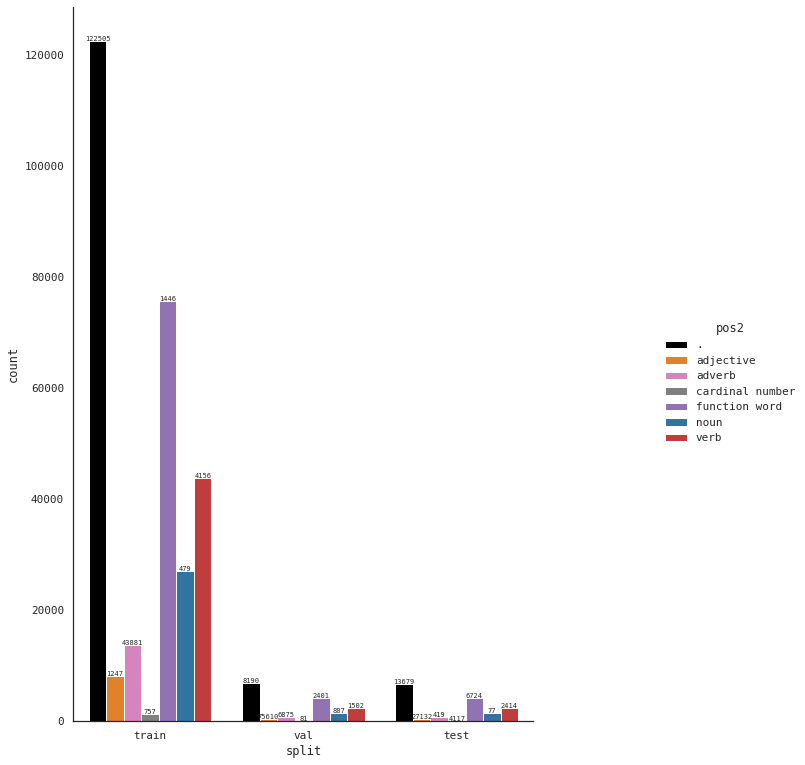

In [12]:
# plot statistics of syntactic categories

pos_tag_dfs = []

splits = ['train', 'val', 'test']

for split in splits:
    dataloader_fn = dataloader_fns[split]
    pos_tags = get_pos_tags(dataloader_fn(), dataset_name, split)

    pos_tag_df = pd.DataFrame(data=list(itertools.chain.from_iterable(pos_tags)), columns=['pos'])
    pos_tag_df['split'] = split
    pos_tag_dfs.append(pos_tag_df)

pos_tag_df = pd.concat(pos_tag_dfs)

for pos_field, pos_mapping in pos_mappings:
    pos_tag_df[pos_field] = pos_tag_df['pos'].map(pos_mapping).astype('category')

pos_field = 'pos2'

g = sns.catplot(kind='count', data=pos_tag_df, x='split', hue=pos_field, palette=pos_palette)
g.figure.set_size_inches(*figsize)

for split in splits:
    print(f'{split:5s} #examples: {len(data.datasets[split]):5d}')

for split in splits:
    split_cnt = len(pos_tag_df[(pos_tag_df['split'] == split)])
    print(f'{split:5s} #tokens: {split_cnt:6d}')

for (split, pos), bar in zip(itertools.product(splits, pos_tag_df.dtypes[pos_field].categories), g.ax.patches):
    split_cnt = len(pos_tag_df[(pos_tag_df['split'] == split)])
    split_pos_cnt = len(pos_tag_df[(pos_tag_df['split'] == split) & (pos_tag_df[pos_field] == pos)])
    print(f'{split:5s} {pos:15s} #tokens: {split_pos_cnt:6d} {split_pos_cnt / split_cnt :7.2%}')
    g.ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 40, f'{split_pos_cnt:d}', ha="center", fontsize='xx-small')

plt.show()

In [13]:
test_model_ns = [model_n for model_n, model in enumerate(models) if model.text_encoder.regressional and not model.text_encoder.captioning and 'contrastive' not in names[model_n]]


# use arbitrary image x as a placeholder
x = next(examples_from_dataloader(dataloader_fns['val']()))[0]

def test(prefix):
    prefix = prefix.lower().split()
    y = [SOS_TOKEN_ID] + [word2idx.get(word, UNK_TOKEN_ID) for word in prefix] + [EOS_TOKEN_ID]
    print('converted:', ' '.join(idx2word[idx] for idx in y))
    y = torch.tensor(y, dtype=torch.long)
    y_len = len(y)
    y_len = torch.tensor(y_len, dtype=torch.long)

    for model_n in test_model_ns:
        model, name = models[model_n], names[model_n]
        print(f'{name}:')
        outputs, losses, logits, attns, labels = run_model(model, x, y, y_len, single_example=True, return_all=True)
        probs = logits.softmax(-1)
        print_top_probs(probs, steps=[len(probs) - 1])


for prefix in [
    "the horse ran past",
    "the horse ran past the",
    "the doggy ran past the",
    "the birdie flew past the",
    "what the truck has to",
    "what the truck is",
    "the girl the boys like",
]:
    test(prefix)

converted: <sos> the horse ran past <eos>
lm:
(0.228) ,        (0.168) the      (0.101) .        (0.079) and      (0.039) to      
converted: <sos> the horse ran past the <eos>
lm:
(0.060) clock    (0.059) <unk>    (0.030) farm     (0.028) boat     (0.028) hole    
converted: <sos> the doggy ran past the <eos>
lm:
(0.108) clock    (0.080) car      (0.070) <unk>    (0.038) boat     (0.033) sea     
converted: <sos> the birdie flew past the <eos>
lm:
(0.131) boat     (0.054) tree     (0.053) <unk>    (0.043) sky      (0.032) mouse   
converted: <sos> what the truck has to <eos>
lm:
(0.421) be       (0.093) play     (0.072) put      (0.056) do       (0.043) get     
converted: <sos> what the truck is <eos>
lm:
(0.170) on       (0.144) in       (0.093) there    (0.079) ?        (0.064) ,       
converted: <sos> the girl the boys like <eos>
lm:
(0.192) the      (0.061) that     (0.053) a        (0.051) to       (0.037) looking 


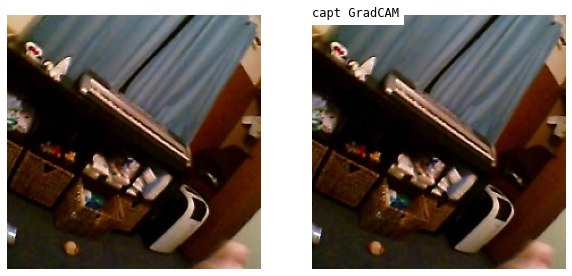

i know .


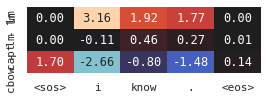

lm:

capt:

cbow:
(0.182) <sos>    | (0.182) <sos>    (0.097) think    (0.088) know     (0.052) ,        (0.051) 'm      



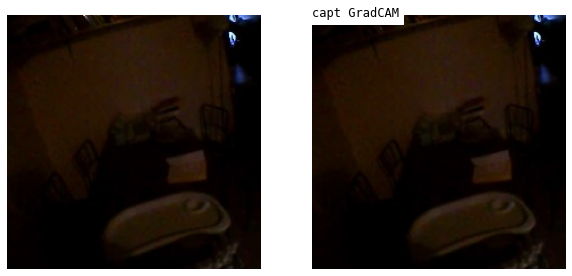

we should turn on some lights , huh ?


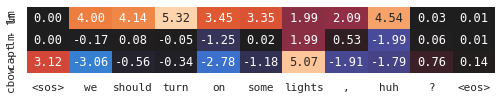

lm:

capt:

cbow:
(0.044) <sos>    | (0.061) should   (0.053) go       (0.044) <sos>    (0.044) can      (0.042) have    



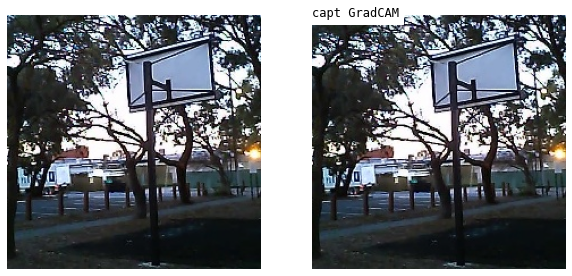

yeahh .


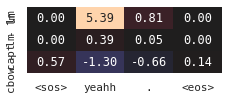

lm:

capt:

cbow:
(0.568) <sos>    | (0.568) <sos>    (0.218) <eos>    (0.116) ,        (0.015) ..       (0.014) "       



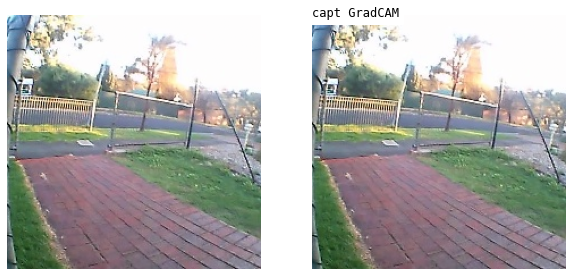

here , let me show you .


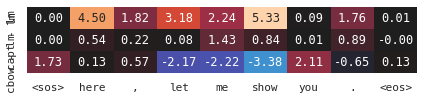

lm:

capt:

cbow:
(0.178) <sos>    | (0.178) <sos>    (0.104) ,        (0.078) 's       (0.047) is       (0.042) over    



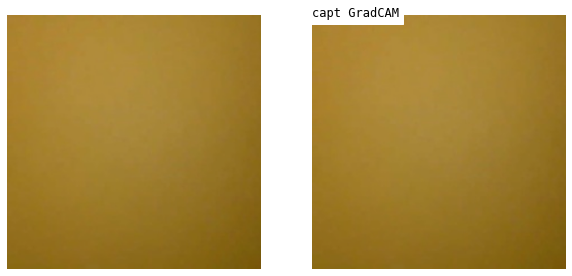

yeah it 's this this one that 's really


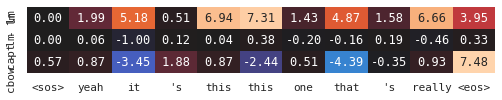

lm:

capt:

cbow:
(0.564) <sos>    | (0.564) <sos>    (0.177) <eos>    (0.175) ,        (0.006) ...      (0.004) "       



In [14]:
searched_word = None
visualize_models = True
n_print_example = 5
textgen_model_ns = [model_n for model_n, (name, model) in enumerate(zip(names, models)) if 'attn' in name] if False else []
multiple_views = False
all_steps = False

gradcam_model_ns = [model_n for model_n, model in enumerate(models) if model.text_encoder.captioning or model.text_encoder.has_attention]
attn_model_ns = [model_n for model_n, model in enumerate(models) if model.text_encoder.has_attention]
if not visualize_models:
    gradcam_model_ns = []
    attn_model_ns = []
n_visualized_models = len(gradcam_model_ns) + len(attn_model_ns)

if searched_word:
    if searched_word is True:
        searched_word = input("search word: ")
    searched_token_id = word2idx.get(searched_word, UNK_TOKEN_ID)
    if searched_token_id == UNK_TOKEN_ID:
        print(f"mapping {searched_word} to UNK")


def get_views(x, grid=(2, 2)):
    """Get multiple views of image x.
    """
    img = n_inv(x)
    views = [img]
    h = img.size(-2) // grid[0]
    w = img.size(-1) // grid[1]
    for grid_i in range(grid[0]):
        for grid_j in range(grid[1]):
            x = grid_i * h
            y = grid_j * w
            views.append(resized_crop(img, x, y, h, w, img.shape[-2:]))
    views = list(map(normalizer, views))
    return views


show_image = functools.partial(plot_image, overlying=True, blur=False, interpolation='nearest')


def visualize_example(x, y, y_len, raw_y, steps=None, model_first=True, prepend_x=False, use_losses=None):
    """Visualize an example.
    Inputs:
        steps: list of steps to visualize; None for all steps
        model_first: if True, then the axes are of n_visualized_models * len(steps), else it is transposed
        prepend_x: if True, prepend raw image x before the models
        use_losses: use the designated losses; must be a list of losses, where each losses is a list of loss at each step;
            for example, split_items[split].losses[example_i]; if None, use the losses generated by running the models
    """
    img = torch_to_numpy_image(n_inv(x))
    y_labels = [idx2word[y_id.item()] for y_id in y]
    if steps is None:
        steps = list(range(y_len.item()))

    n_rows, n_cols = int(prepend_x) + n_visualized_models, len(steps)
    if not model_first:
        n_rows, n_cols = n_cols, n_rows
    n_axes = n_rows * n_cols
    ax_size = 5
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(ax_size * n_cols, ax_size * n_rows), squeeze=False)
    if not model_first:
        axes = [[axes[j][i] for j in range(n_rows)] for i in range(n_cols)]
    axes_iter = itertools.chain.from_iterable(axes)

    if prepend_x:
        for step_i, step in enumerate(steps):
            show_image(next(axes_iter), img)

    for model_n in gradcam_model_ns:
        model, name = models[model_n], names[model_n]
        gradcams = gradCAM_for_captioning_lm(model, x, y, y_len, steps=steps)
        prefix = f'{name} GradCAM'
        for step_i, (step, gradcam) in enumerate(zip(steps, gradcams)):
            if step == 0:
                show_image(next(axes_iter), img, text=prefix)
            else:
                text = y_labels[step]
                if step_i == 0:
                    text = prefix + ' ' + text
                show_image(next(axes_iter), img, gradcam, text=text)

    for model_n in attn_model_ns:
        model, name = models[model_n], names[model_n]
        attns = attention_for_attention_lm(model, x, y, y_len, steps=steps)
        prefix = f'{name} attn'
        for step_i, (step, attn) in enumerate(zip(steps, attns)):
            text = y_labels[step]
            if step_i == 0:
                text = prefix + ' ' + text
            show_image(next(axes_iter), img, attn, text=text)

    for ax in axes_iter:
        ax.axis("off")
    plt.show()

    if use_losses is None:
        with torch.no_grad():
            rets = [run_model(model, x, y, y_len, single_example=True, return_all=True) for model in models]
            losses = [ret[1].cpu().numpy() for ret in rets]
    else:
        losses = use_losses
    print(raw_y[0])
    names_, losses_ = zip(*[(name, loss) for name, loss in zip(names, losses) if 'contrastive' not in name])
    plot_model_y_value_heatmap(names_, losses_, y_labels)
    
    if use_losses is None:
        for name, model, ret in zip(names, models, rets):
            if not isinstance(model, MultiModalLitModel) or 'contrastive' in name:
                continue
            print(f'{name}:')
            if model.language_model.text_encoder.regressional:
                steps_ = [step - 1 for step in steps if step > 0]
            else:
                steps_ = steps
            logits, labels = ret[2], ret[4]
            probs = logits.softmax(-1)
            print_top_probs(probs, labels, steps=steps_)
            print()


examples = examples_from_dataloader(dataloader_fns['val']())

example_i = 0
print_example_i = 0

for example_i, (x, y, y_len, raw_y) in enumerate(examples):
    y = y[:y_len]

    if searched_word:
        searched_word_steps = [idx for idx, y_id in enumerate(y) if y_id == searched_token_id]
        if not searched_word_steps:
            continue

    if all_steps:
        steps = None
    else:
        steps = searched_word_steps if searched_word else [0]

    for x_view_i, x_view in enumerate(get_views(x) if multiple_views else [x]):
        visualize_example(x_view, y, y_len, raw_y, steps=steps, model_first=all_steps, prepend_x=not all_steps)

    for model_n in textgen_model_ns:
        name = names[model_n]
        print(f"generating text from {name}:")
        model = models[model_n]
        image_features, image_feature_map = model.model.encode_image(x.unsqueeze(0).to(device))
        beam_seq, log_prob = model.language_model.beam_search_decode(
            batch_size=1,
            beam_width=model.beam_width,
            decode_length=model.decode_length,
            length_penalty_alpha=model.length_penalty_alpha,
            image_features=image_features if model.language_model.text_encoder.captioning else None,
            image_feature_map=image_feature_map if model.language_model.text_encoder.has_attention else None,
        )
        gen_text_ids = beam_seq[0, 0]
        gen_text_len = len(gen_text_ids)
        while gen_text_len > 0 and gen_text_ids[gen_text_len - 1] == PAD_TOKEN_ID:
            gen_text_len -= 1
        gen_text_len = torch.tensor(gen_text_len, device=device)
        gen_text_labels = [idx2word[y_id.item()] for y_id in gen_text_ids]
        gen_text = ' '.join(gen_text_labels)
        visualize_example(x, gen_text_ids, gen_text_len, [gen_text], steps=None, model_first=True, prepend_x=False)

    print_example_i += 1
    if print_example_i >= n_print_example:
        break

In [15]:
vector_attr = ['mean_vector', 'embedding'][1]

cosine matrices:



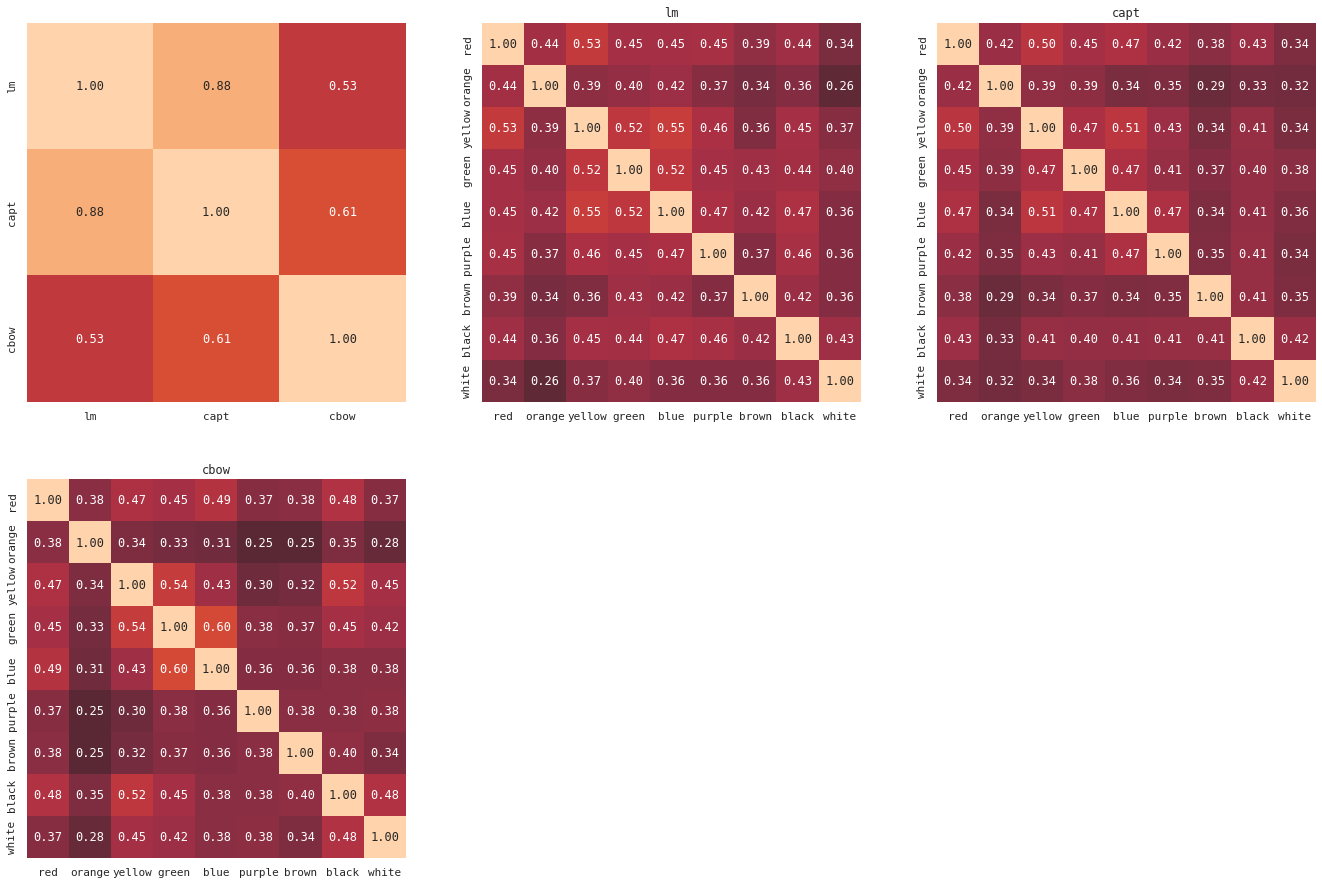

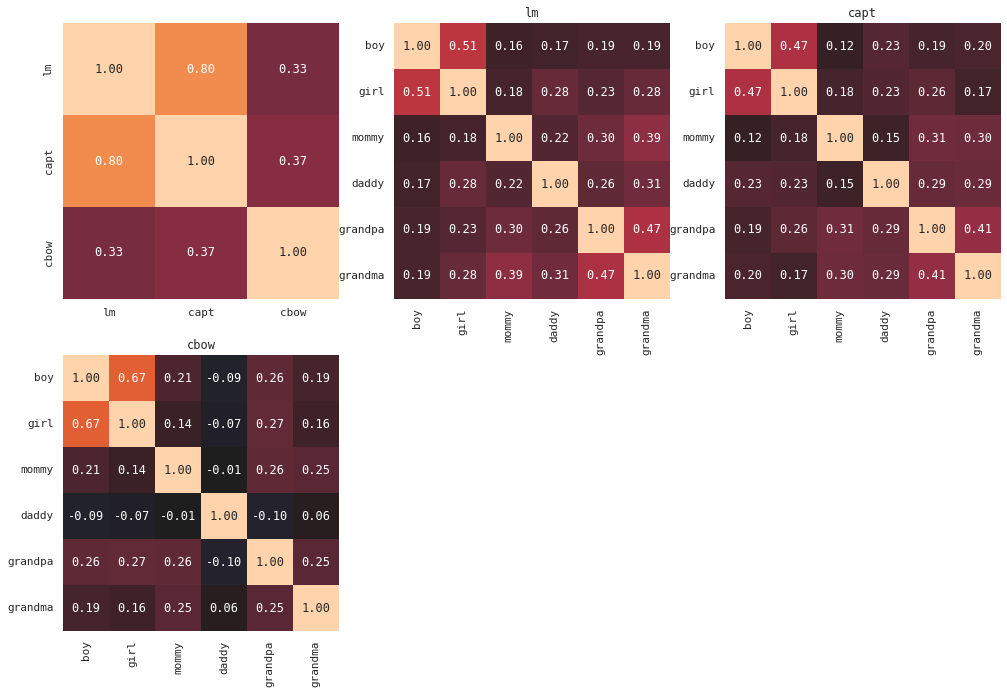

cosine matrices for the differentiations:

mapping eats to UNK
mapping flies to UNK
mapping drives to UNK
mapping drove to UNK
mapping stood to UNK
mapping crawled to UNK


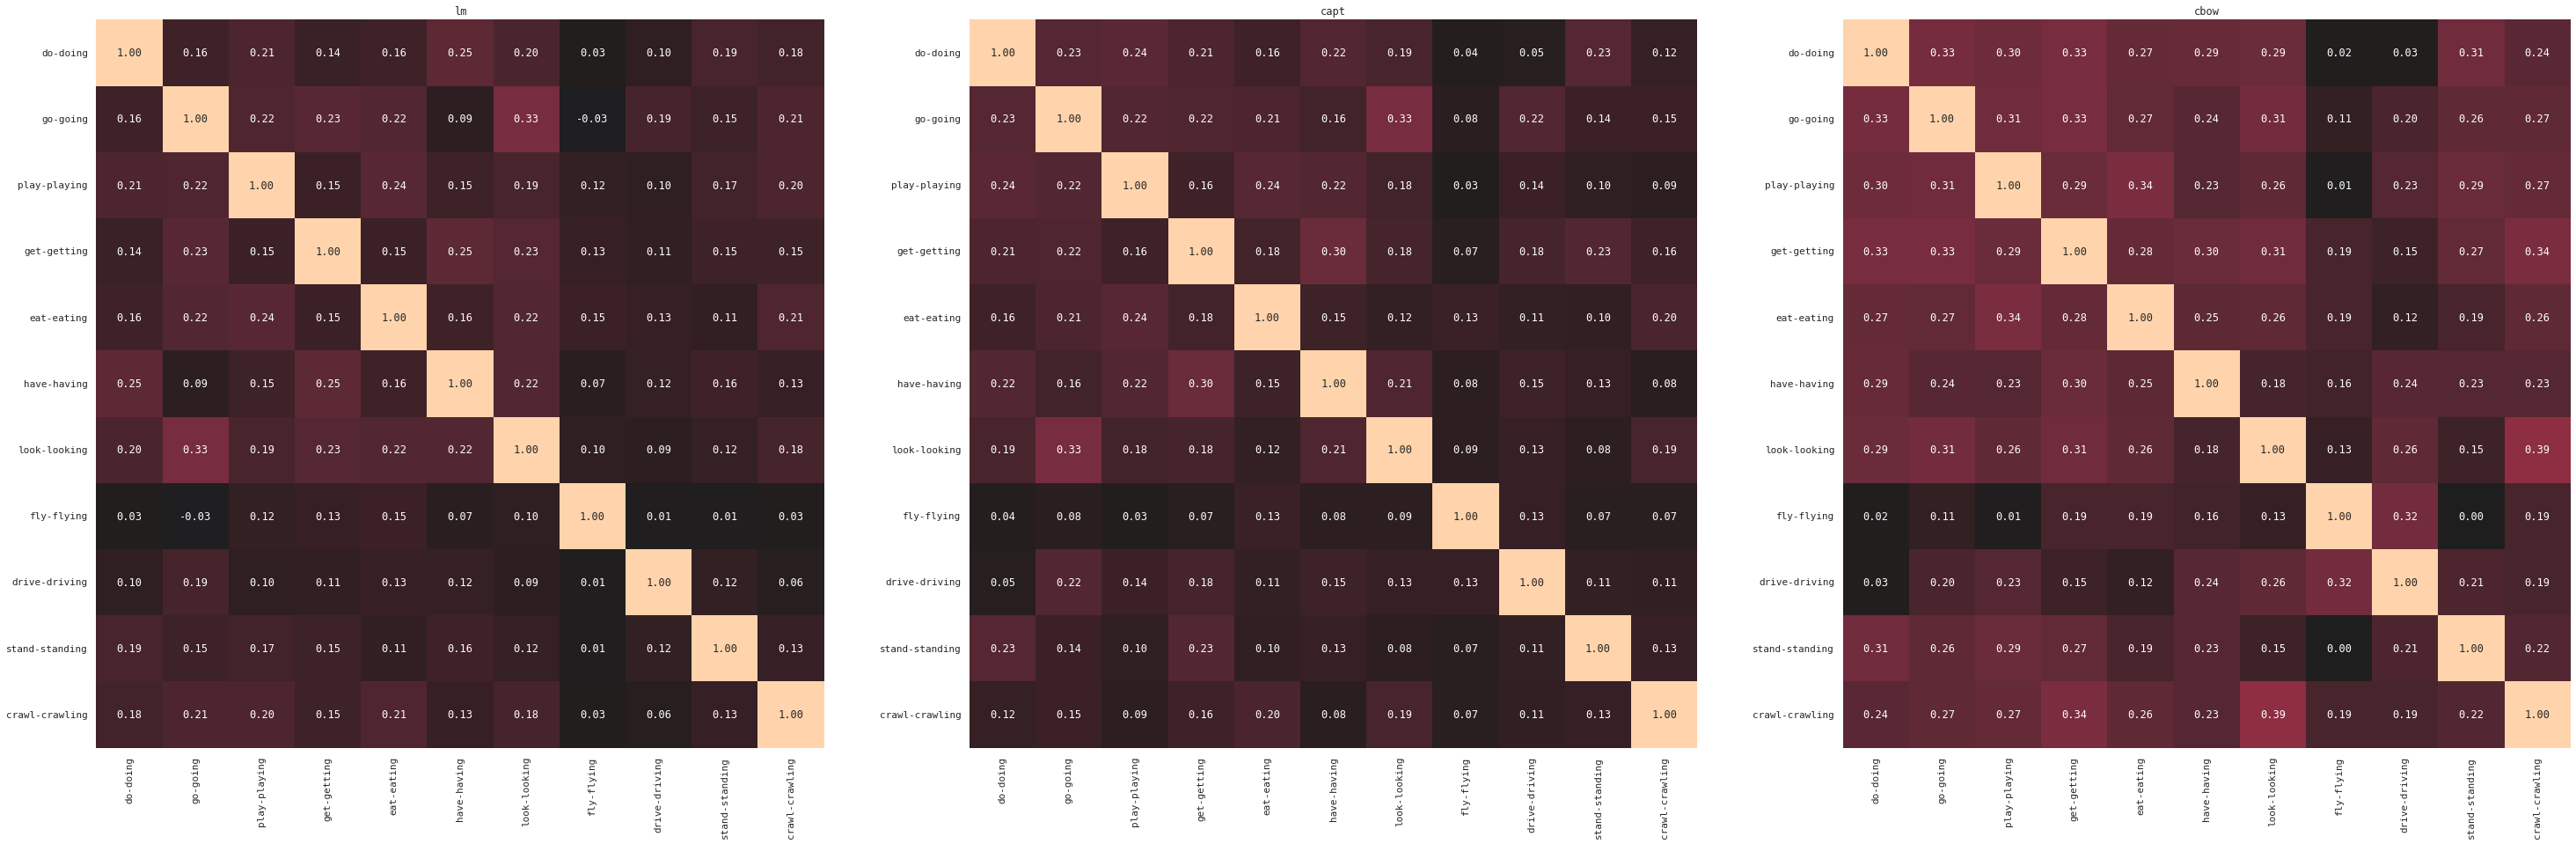

mapping doesn't to UNK
mapping didn't to UNK
mapping shouldn't to UNK
mapping hasn't to UNK
mapping haven't to UNK
mapping won't to UNK


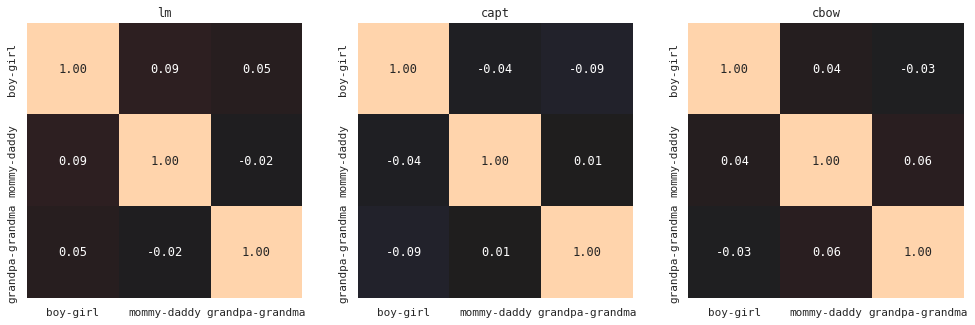

In [16]:
# cosine matrices for some tested words

def get_items_from_inp(inp, token_items=split_items['train'].token_items):
    token_ids = split_tokens(inp)
    if UNK_TOKEN_ID in token_ids:
        raise KeyError
    return token_items.loc[token_ids]


# cosine matrices
print('cosine matrices:')
print()
for inp in [
    "red orange yellow green blue purple brown black white",
    "boy girl mommy daddy grandpa grandma",
]:
    try:
        items = get_items_from_inp(inp)
    except KeyError:
        continue
    plot_vector_sim_heatmap(items, names, vector_attr=vector_attr, one_figure=True)

# cosine matrices for the differentiations (vector1 - vector0)
print('cosine matrices for the differentiations:')
print()
for inp in [
    "do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives",
    "do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled",
    "do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling",
    "do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't",
    "boy girl mommy daddy grandpa grandma",
]:
    try:
        items = get_items_from_inp(inp)
    except KeyError:
        continue
    plot_vector_sim_heatmap(items, names, diff=True, vector_attr=vector_attr, one_figure=True)

In [17]:
for split in used_splits:
    token_items = split_items[split].token_items

    for n, name in enumerate(names):
        print(f'{name}:')
        get_tsne_points(token_items[name], get_attr=vector_attr)
        extend_point_items(token_items, name, 'tsne')
        get_eigen_points(token_items[name], get_attr=vector_attr)
        extend_point_items(token_items, name, 'eigen')

lm:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
capt:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
cbow:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
lm:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
capt:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.
cbow:


/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


T-SNE done.
SVD done.


In [18]:
split_pos_items, split_pos_pos_items, split_all_pos_items = {}, {}, {}

for split in used_splits:
    print(f'{split} split:')

    top_token_items = split_items[split].token_items.sort_values('cnt', ascending=False, kind='stable')   # sort by cnt
    top_token_items = top_token_items[~top_token_items[token_field].isin(untypical_words)]  # remove untypical words
    pos_field = 'pos2'
    used_poses = top_token_items.dtypes[pos_field].categories
    pos_items = {pos: top_token_items[top_token_items[pos_field] == pos] for pos in used_poses}
    split_pos_items[split] = pos_items
    for pos in used_poses:
        items = pos_items[pos]
        print(f'number of {pos}s: {len(items)}')
        for _, row in items[:50].iterrows():
            print(row_str(row, names))

    interleaving_step = 1

    pos_pos_items = {}
    for i_pos in range(len(used_poses)):
        for j_pos in range(len(used_poses)):
            if i_pos != j_pos:
                pos_i = used_poses[i_pos]
                pos_i_items = pos_items[pos_i]
                pos_j = used_poses[j_pos]
                pos_j_items = pos_items[pos_j]
                interleaved_dfs = []
                i = -interleaving_step
                for i in range(0, min(len(pos_i_items), len(pos_j_items)), interleaving_step):
                    interleaved_dfs.append(pos_i_items[i:i+interleaving_step])
                    interleaved_dfs.append(pos_j_items[i:i+interleaving_step])
                else:
                    i += interleaving_step
                    interleaved_dfs.append(pos_i_items[i:])
                    interleaved_dfs.append(pos_j_items[i:])
                pos_pos_items[(pos_i, pos_j)] = pd.concat(interleaved_dfs)
    split_pos_pos_items[split] = pos_pos_items

    interleaved_dfs = []
    for i in range(0, max(map(len, pos_items.values())), interleaving_step):
        for pos in used_poses:
            items = pos_items[pos]
            interleaved_dfs.append(items[i:i+interleaving_step])
    all_pos_items = pd.concat(interleaved_dfs)
    split_all_pos_items[split] = all_pos_items

    # check some items
    for _, row in top_token_items[:100].iterrows():
        print(row_str(row, names))
    print()
    for word in ['look', 'need', 'draw']:
        try:
            token_id = word2idx[word]
            for _, row in top_token_items.loc[token_id].iterrows():
                print(row_str(row, names))
        except KeyError:
            pass

train split:
number of .s: 221
<sos>      .     33737:     1.000     1.000     9.869
<eos>      .     33370:     1.462     1.409     2.862
.          .     16566:     3.050     2.802     1.817
,          ,      9479:     5.927     5.832     6.801
?          .      8420:     2.382     2.105     3.315
yeah       UH     4923:     8.659     8.512     4.786
"          ``     2043:    13.632     5.386    20.110
!          .      1819:    12.186     9.430    12.480
okay       UH     1760:    26.081    25.654    18.520
oh         UH     1272:    30.678    31.567    16.537
ok         UH      812:    62.735    53.224    52.453
...        ,       748:    45.401    35.485   125.832
no         UH      668:    67.770    52.507    50.516
alright    UH      642:    75.060    69.066    38.375
-          ,       486:    18.118    13.404    23.628
huh        UH      253:    13.403    10.324    28.507
well       UH      250:    82.771    70.561   112.284
yea        UH      244:   149.527    51.817    55.7

<sos>      .     33737:     1.000     1.000     9.869
<eos>      .     33370:     1.462     1.409     2.862
.          .     16566:     3.050     2.802     1.817
,          ,      9479:     5.927     5.832     6.801
you        PRP    9235:     5.436     5.131     3.463
?          .      8420:     2.382     2.105     3.315
the        DT     5841:     5.862     5.071     3.255
yeah       UH     4923:     8.659     8.512     4.786
to         TO     4540:     2.349     2.202     2.492
a          DT     4539:     6.554     5.162     3.592
it         PRP    4435:     9.466     8.726     8.141
<unk>      NN     4364:    27.586    24.645    37.825
and        CC     3813:    10.125     8.347     9.804
that       DT     3742:    17.595    15.068     9.711
we         PRP    3273:    12.192    10.776     5.585
i          PRP    3032:    19.200    18.311     4.120
there      EX     2921:    18.062    14.930    12.888
do         VBP    2850:    17.917    16.139     8.508
want       VBP    2816:     

<sos>      .      1874:     1.000     1.000     9.994
<eos>      .      1857:     1.556     1.526     3.042
.          .       941:     3.684     3.575     1.886
,          ,       543:     7.732     8.272     8.293
you        PRP     512:     5.923     5.827     3.533
?          .       452:     2.990     2.758     3.444
the        DT      311:     8.950     8.374     4.620
<unk>      NN      295:    35.634    34.953    38.935
yeah       UH      251:     9.072     9.071     4.668
it         PRP     242:    11.236    10.751     9.312
a          DT      238:     7.951     6.829     3.719
that       DT      226:    24.554    22.002    10.493
to         TO      220:     3.882     3.904     3.425
and        CC      220:    16.097    15.848    14.038
we         PRP     190:    16.151    14.660     5.782
there      EX      167:    24.307    20.305    13.323
i          PRP     162:    21.951    21.078     4.043
do         VBP     153:    21.250    20.322    10.201
"          ``      129:    2

noun_verb:


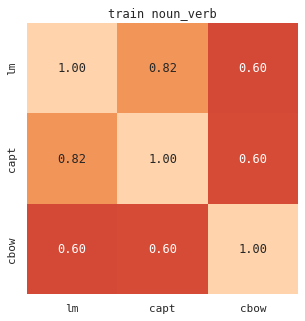

lm:


/home/ww2135/.local/lib/python3.9/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


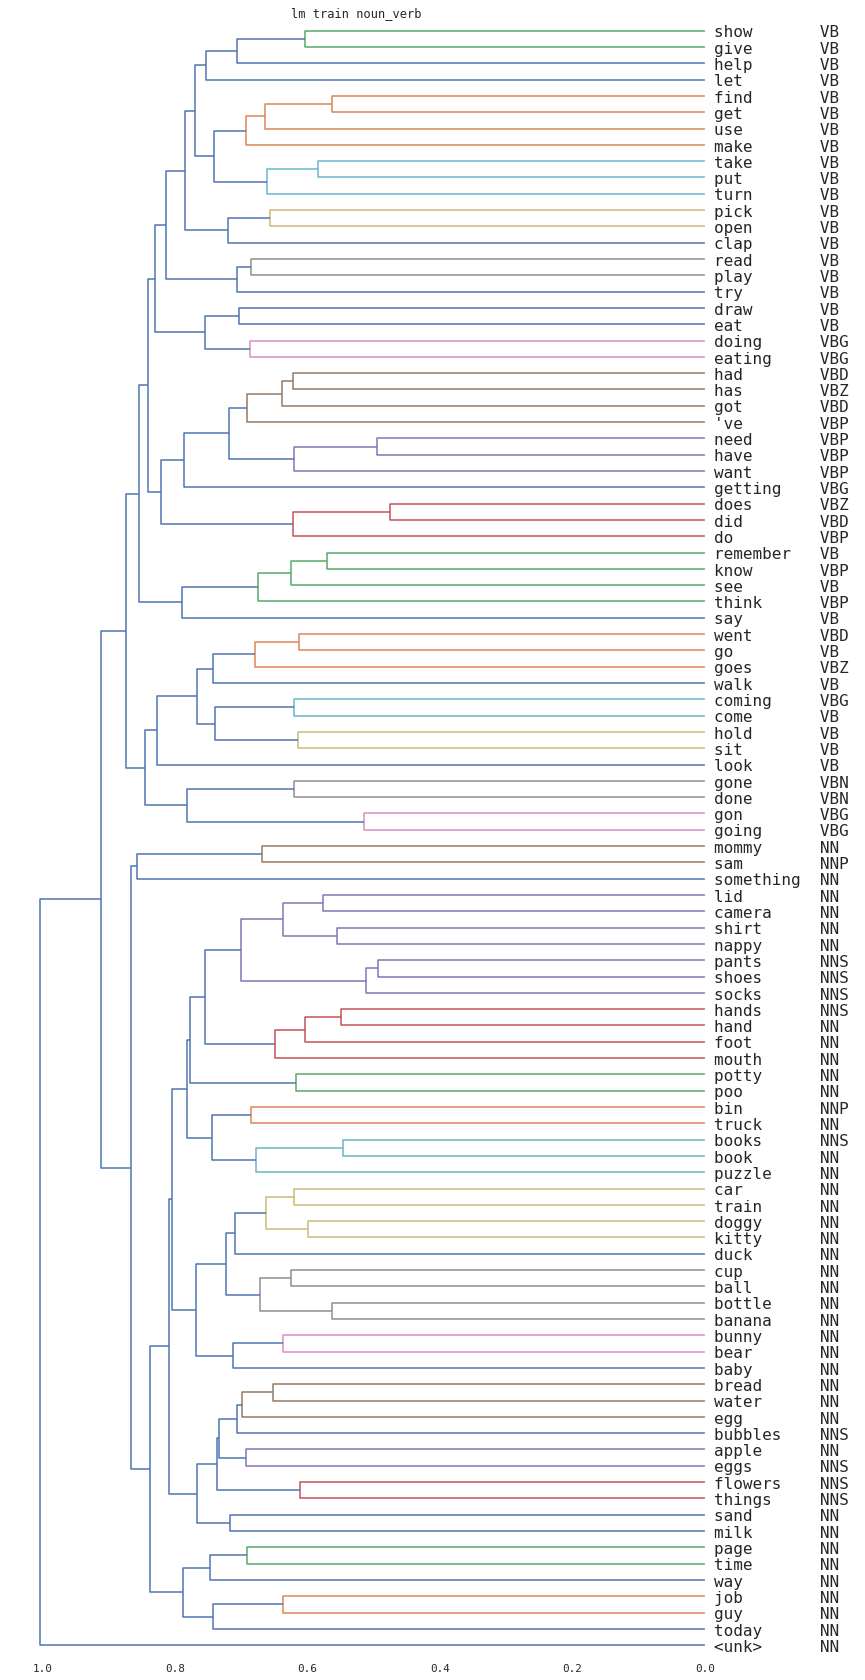

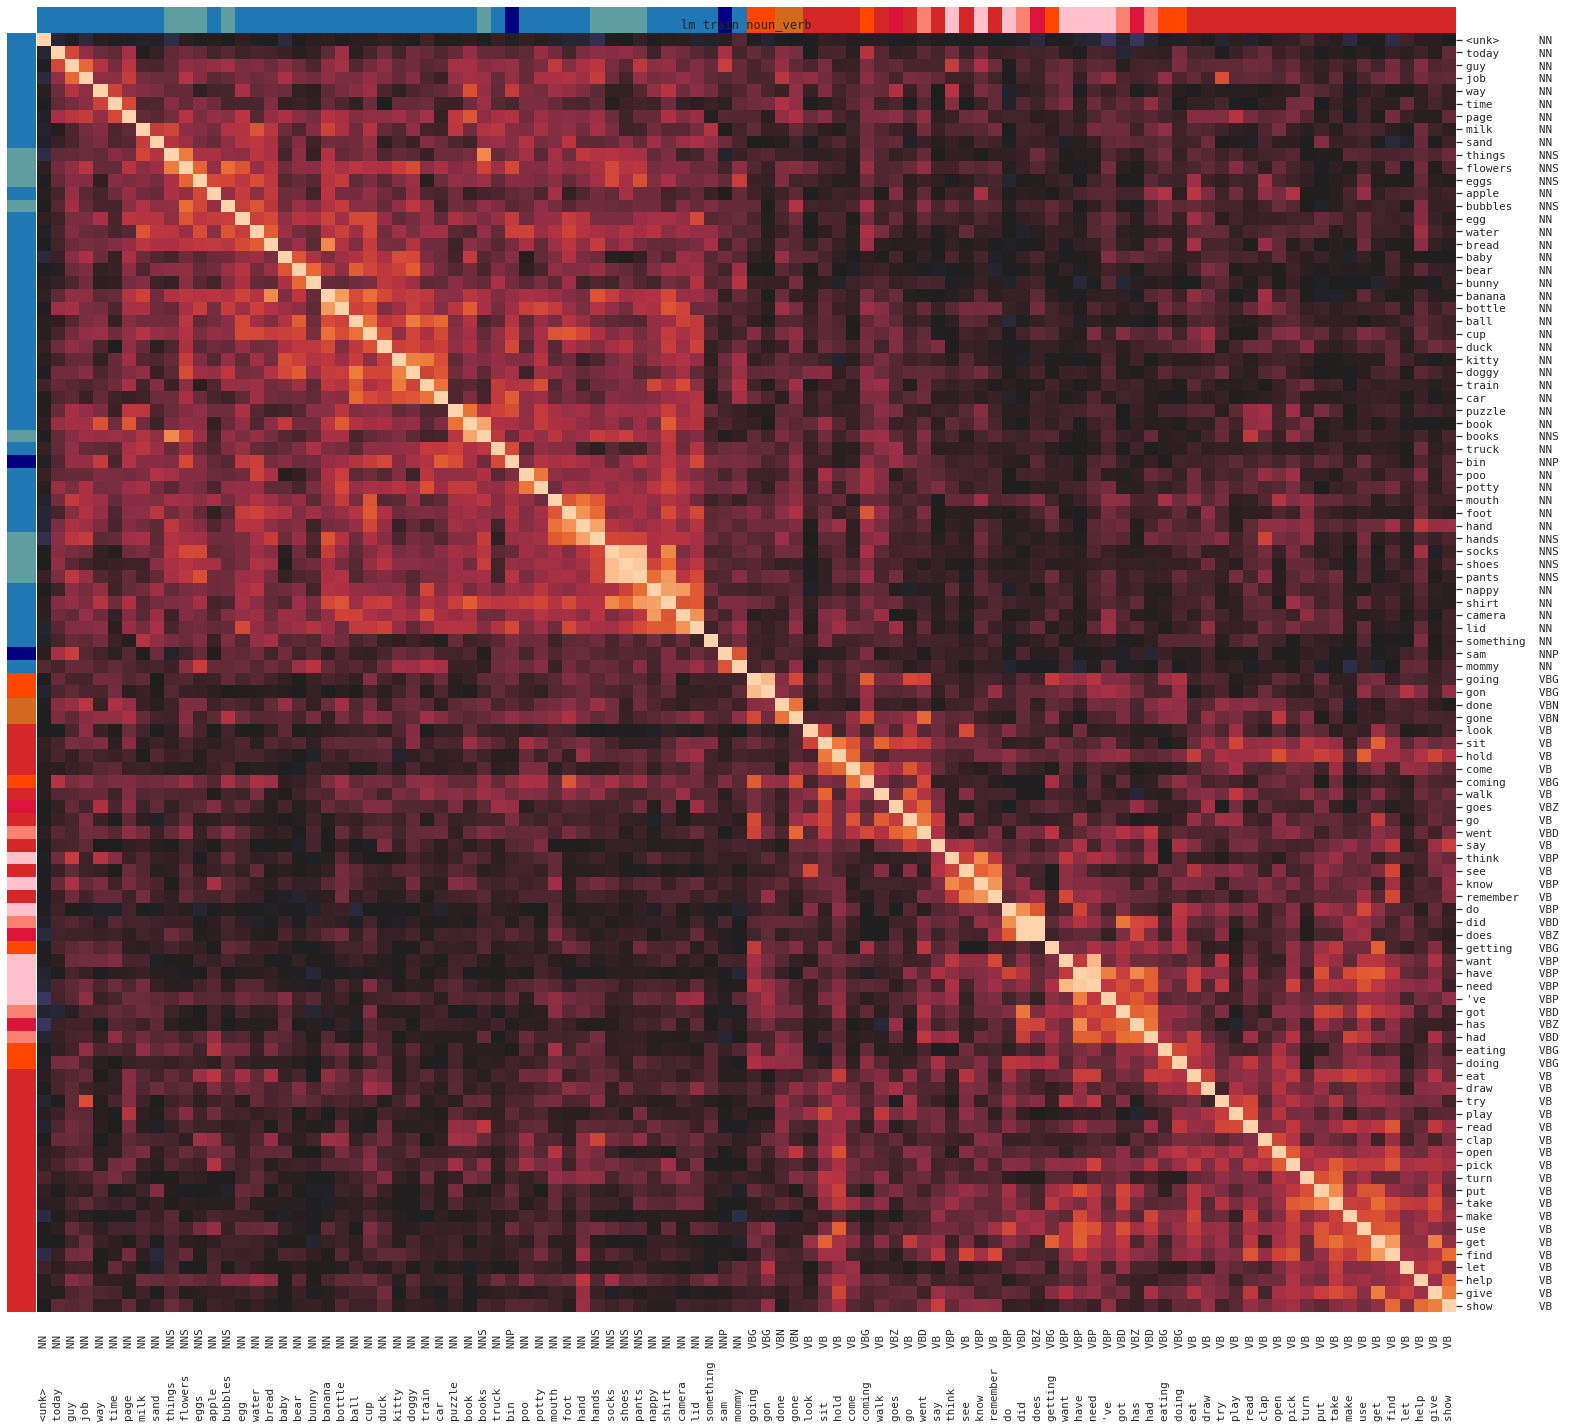

capt:


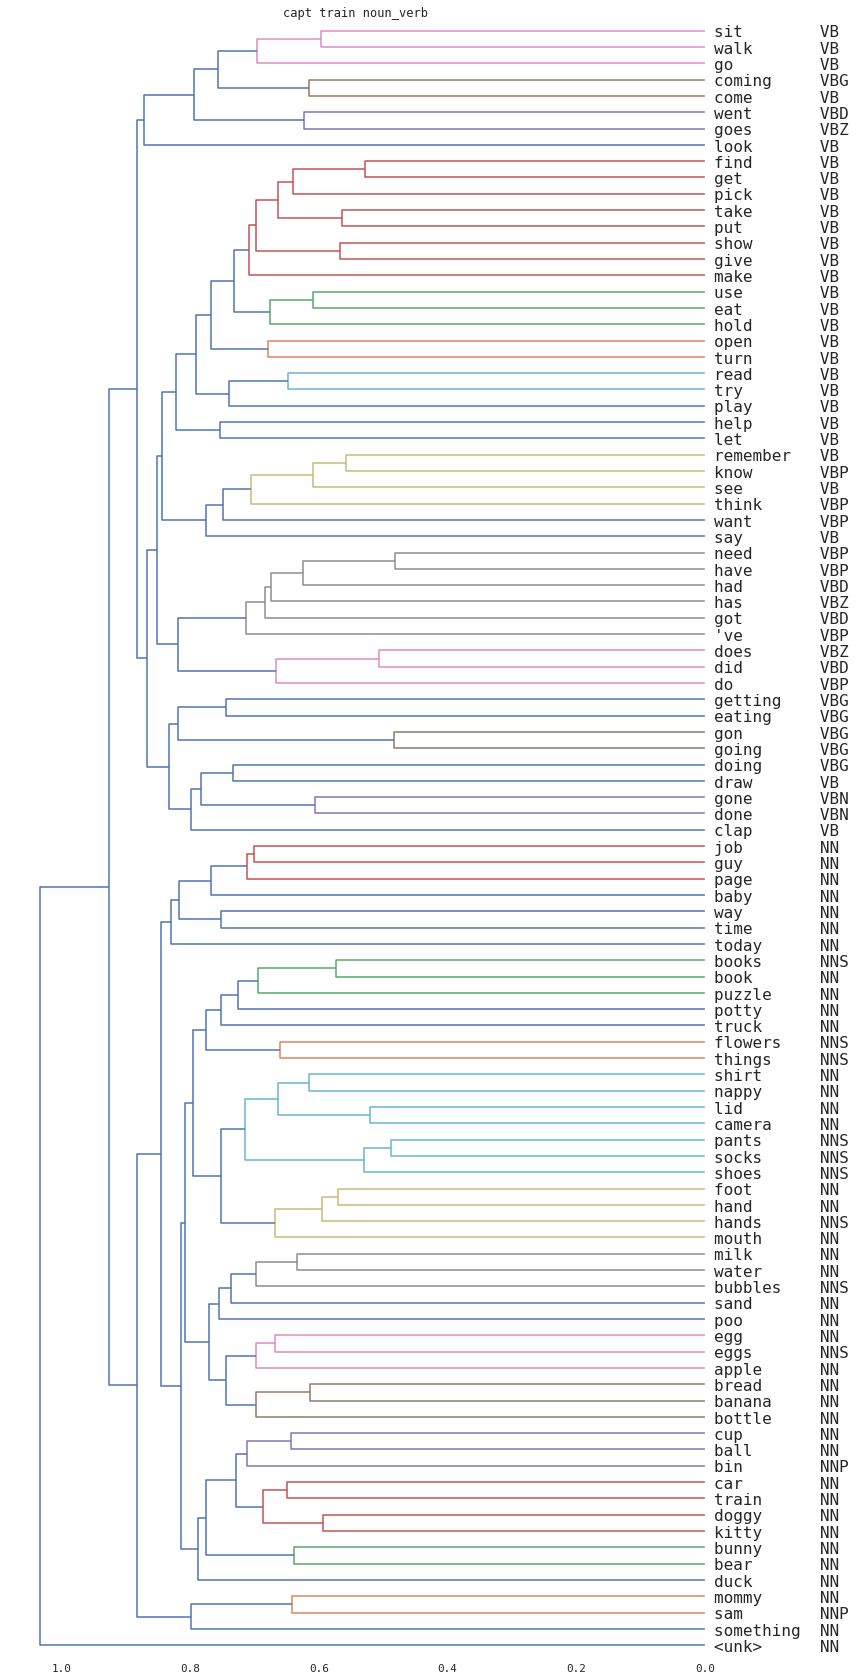

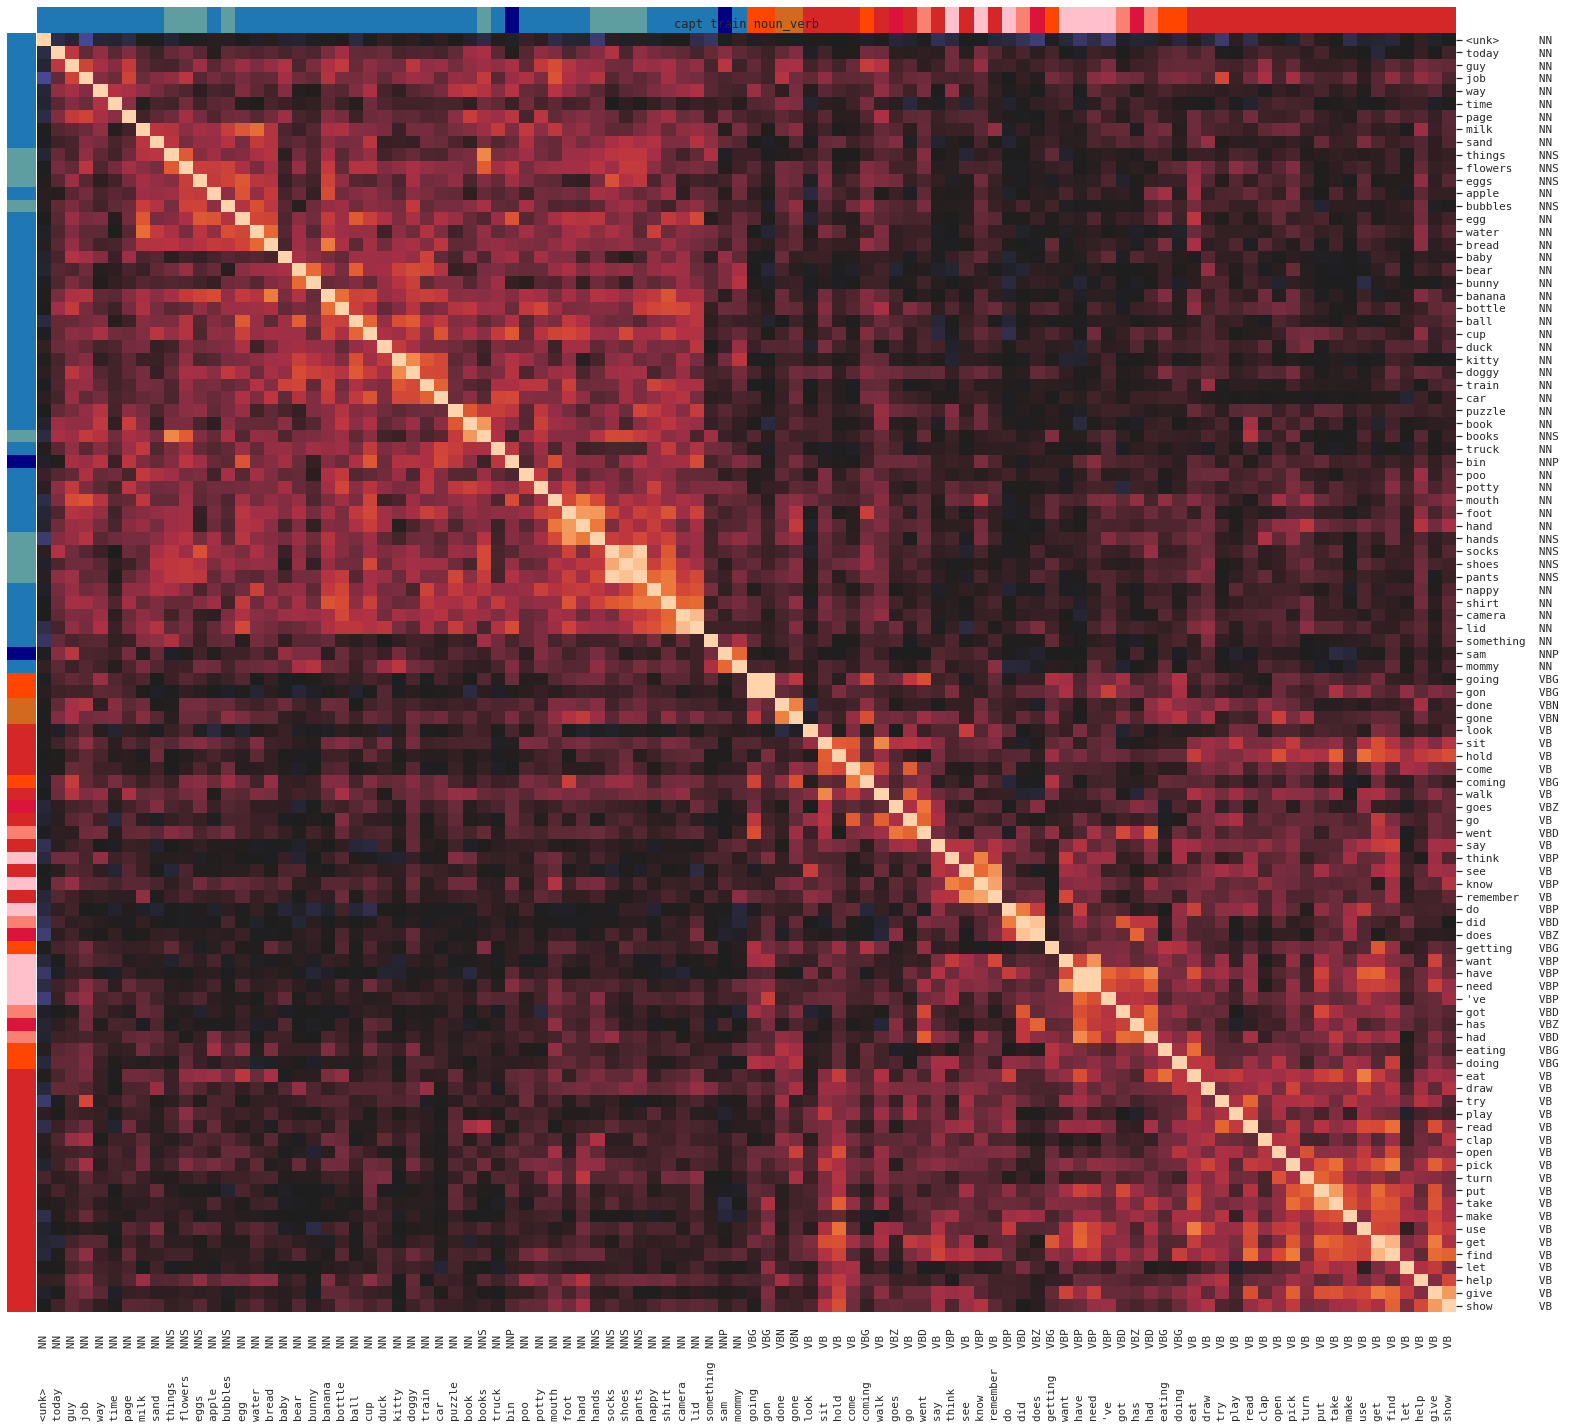

cbow:


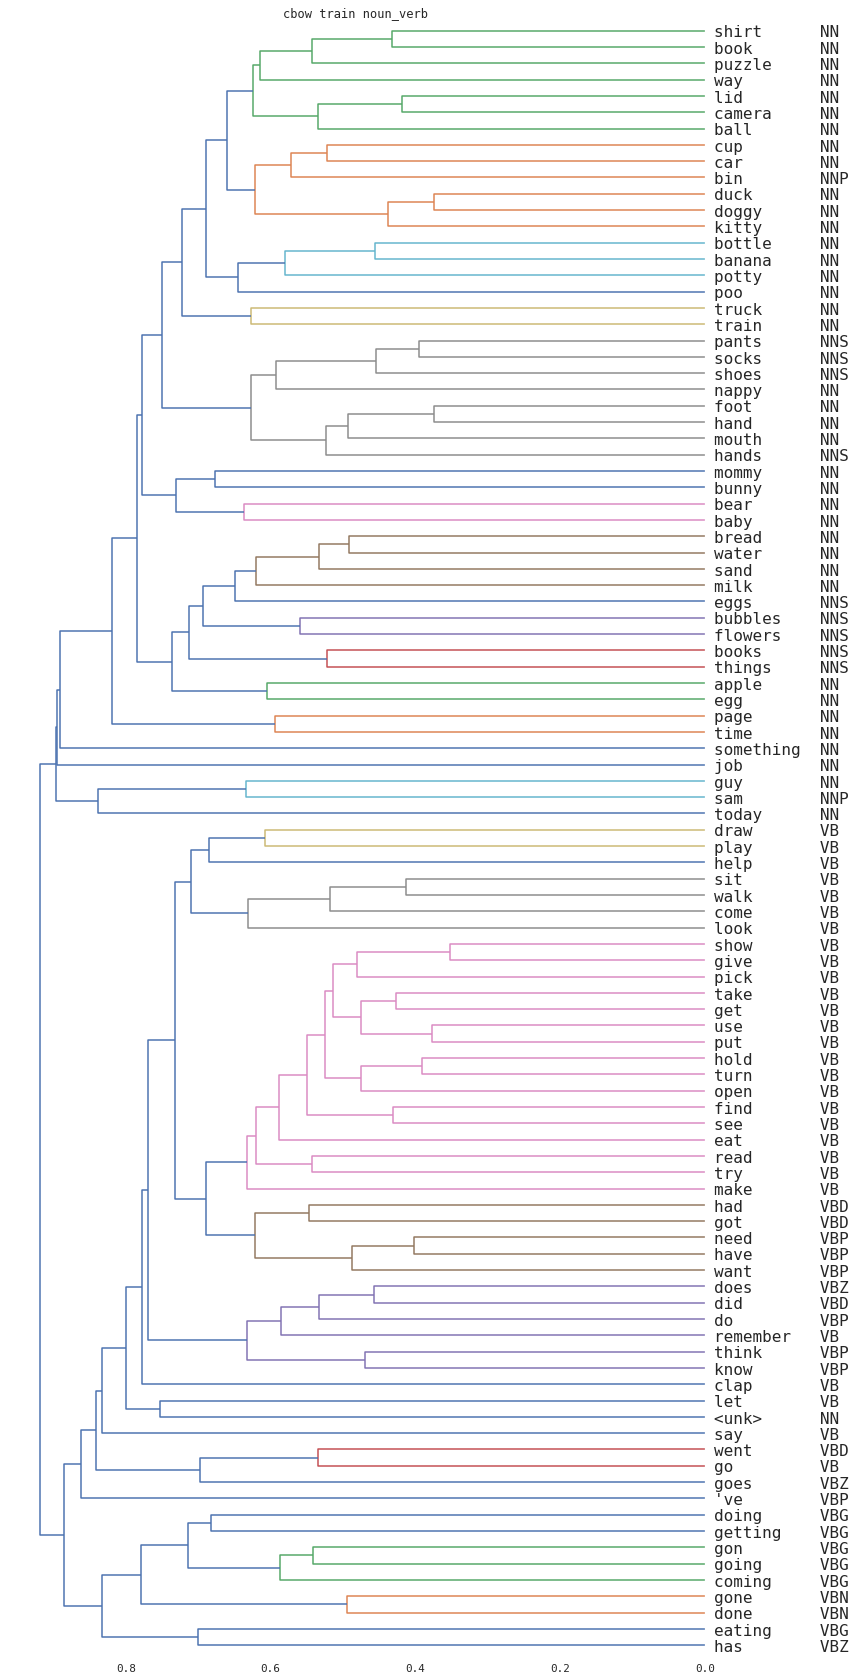

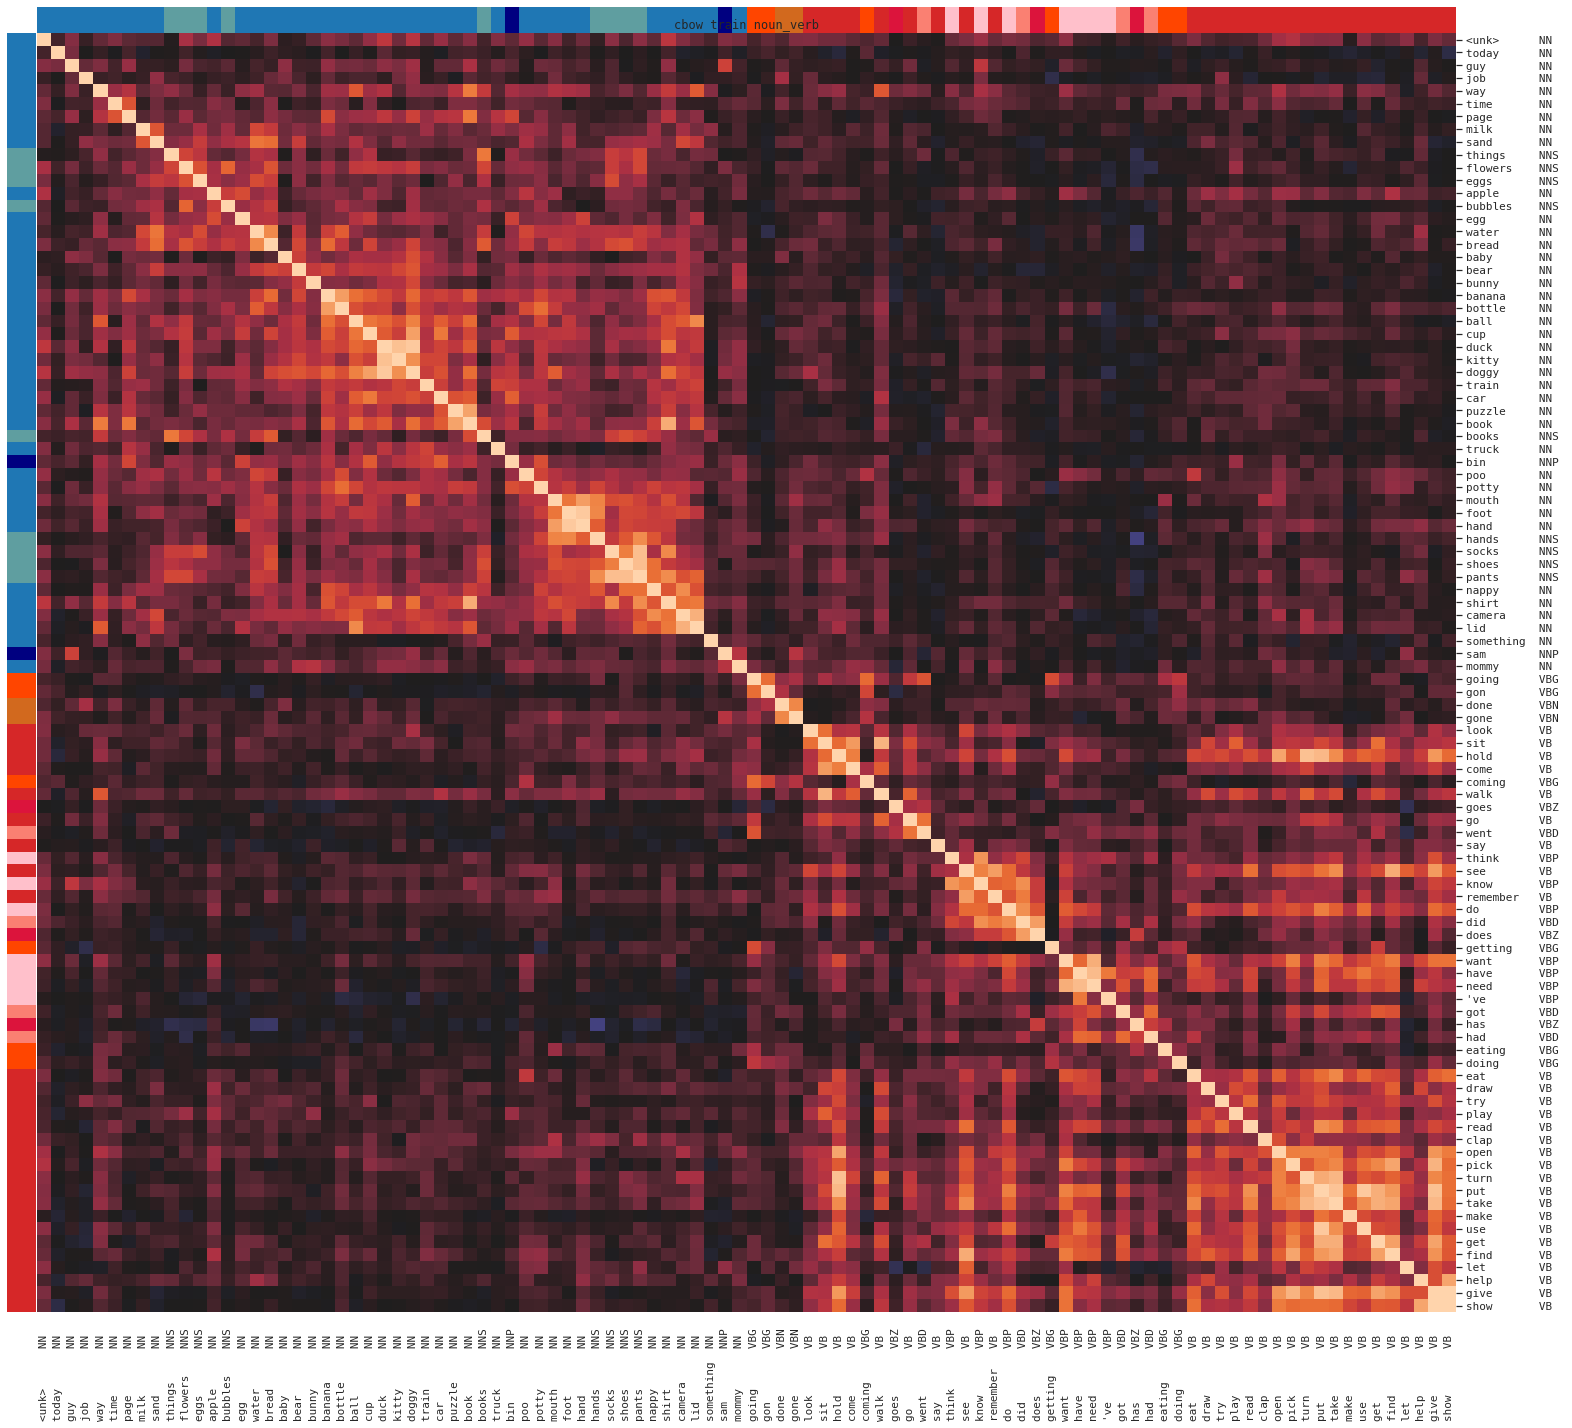

noun:


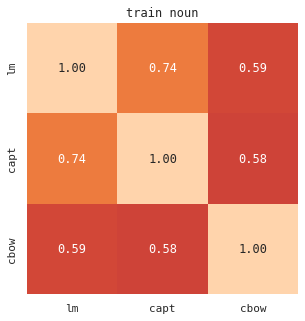

lm:


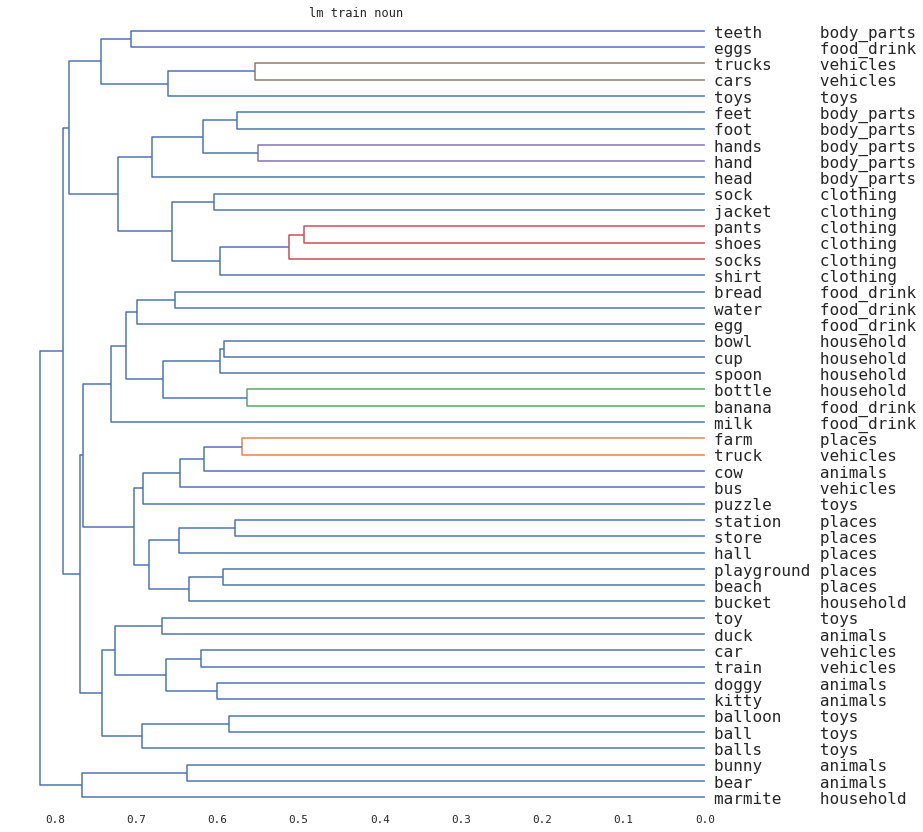

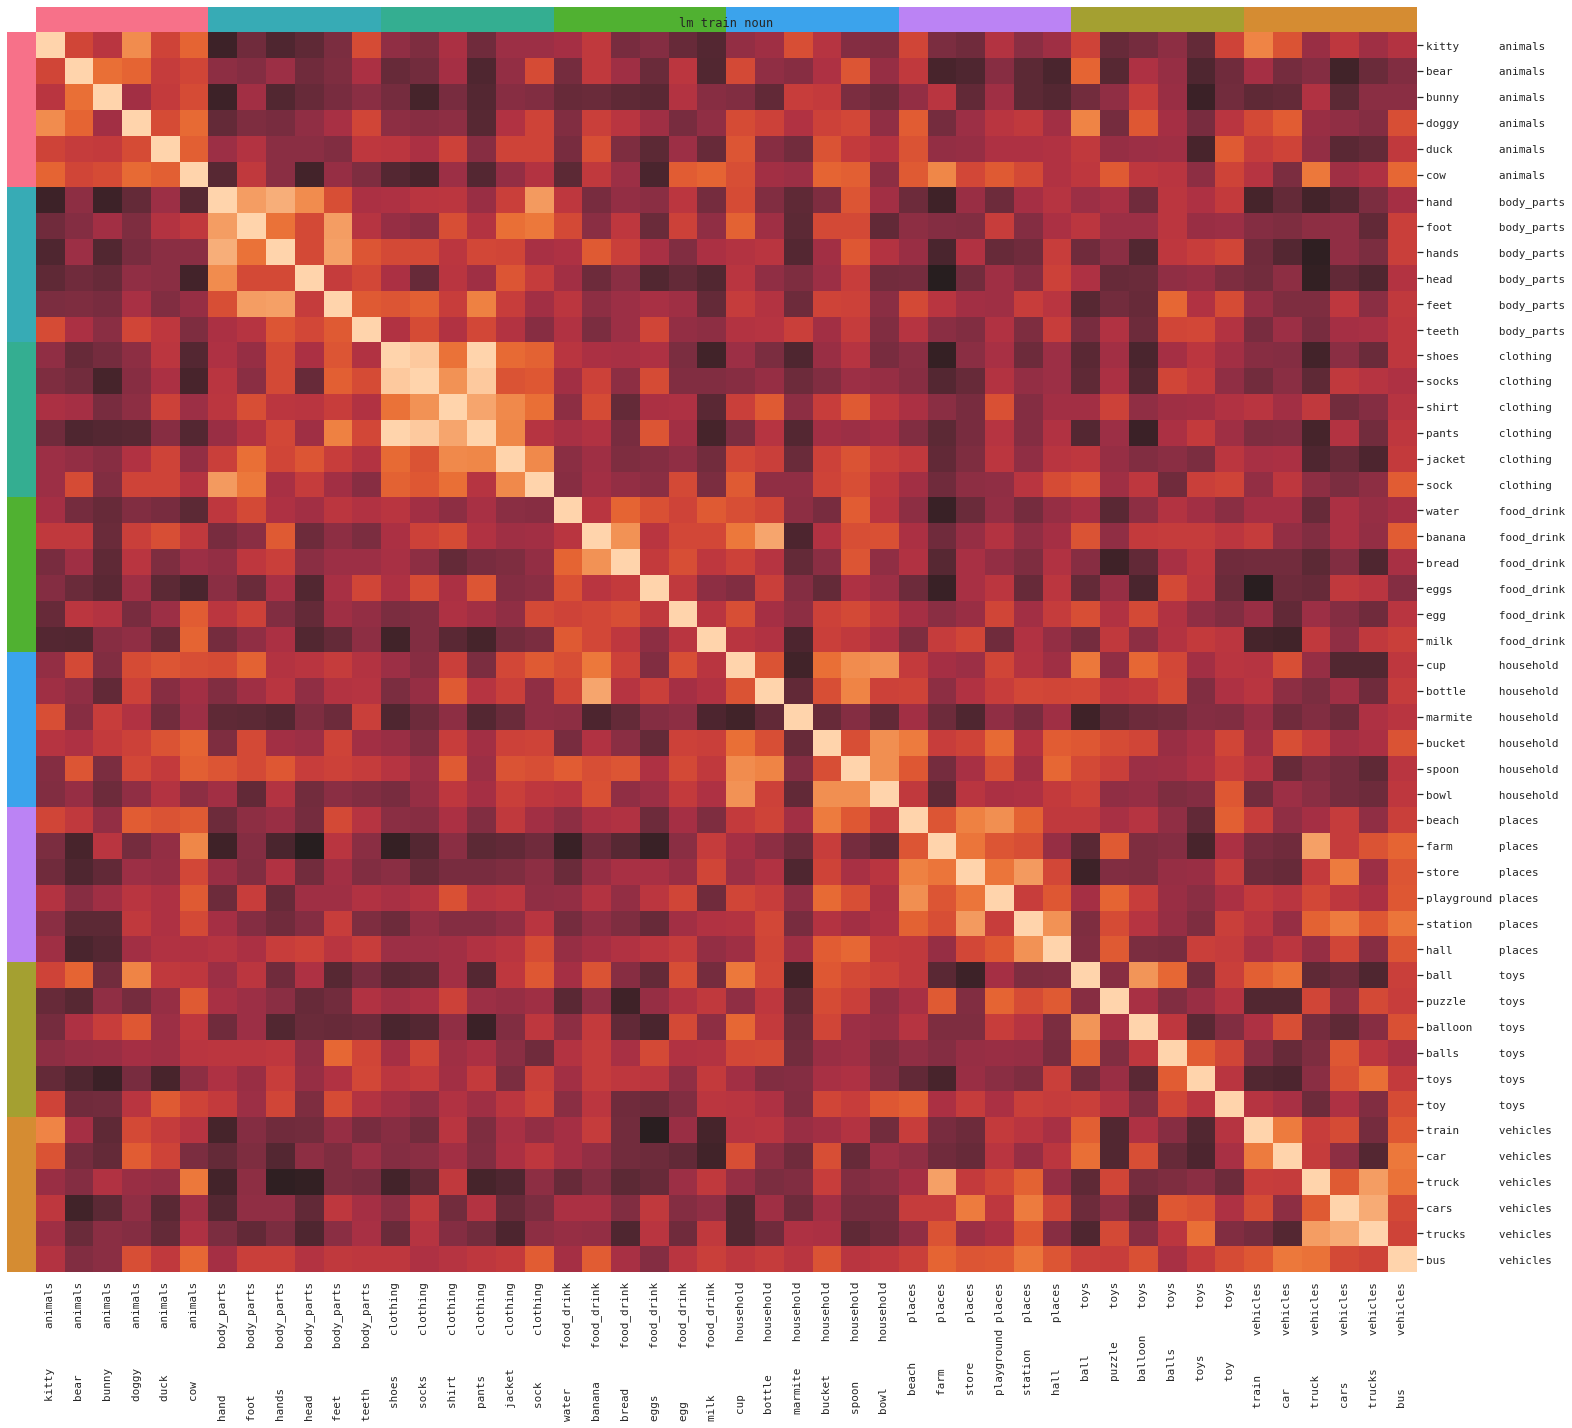

capt:


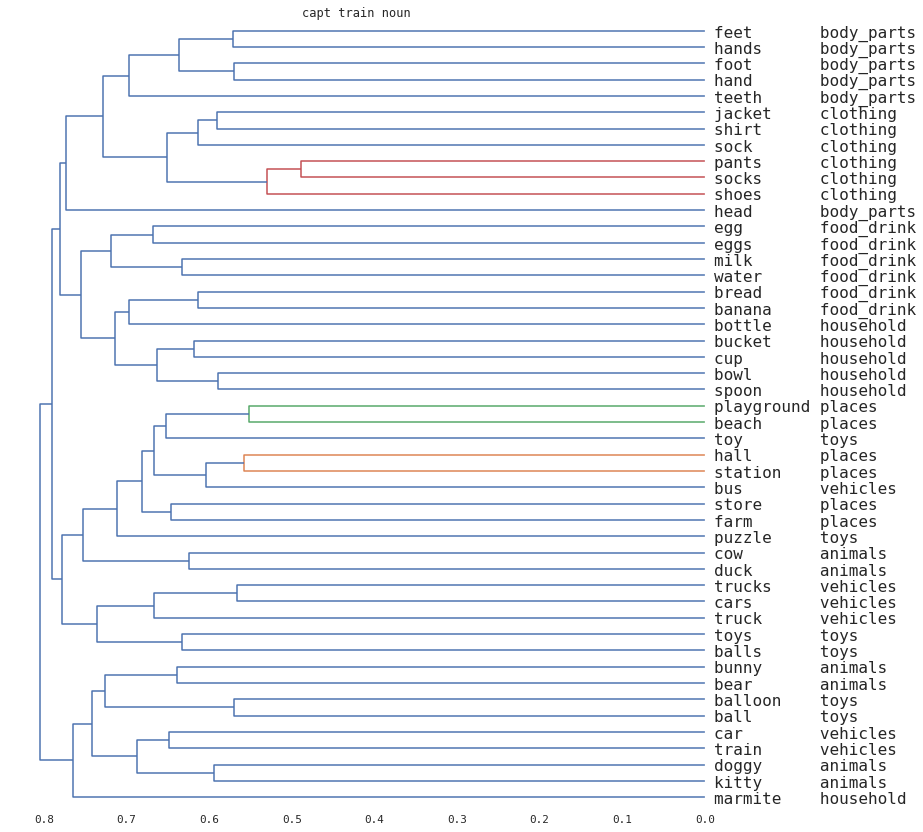

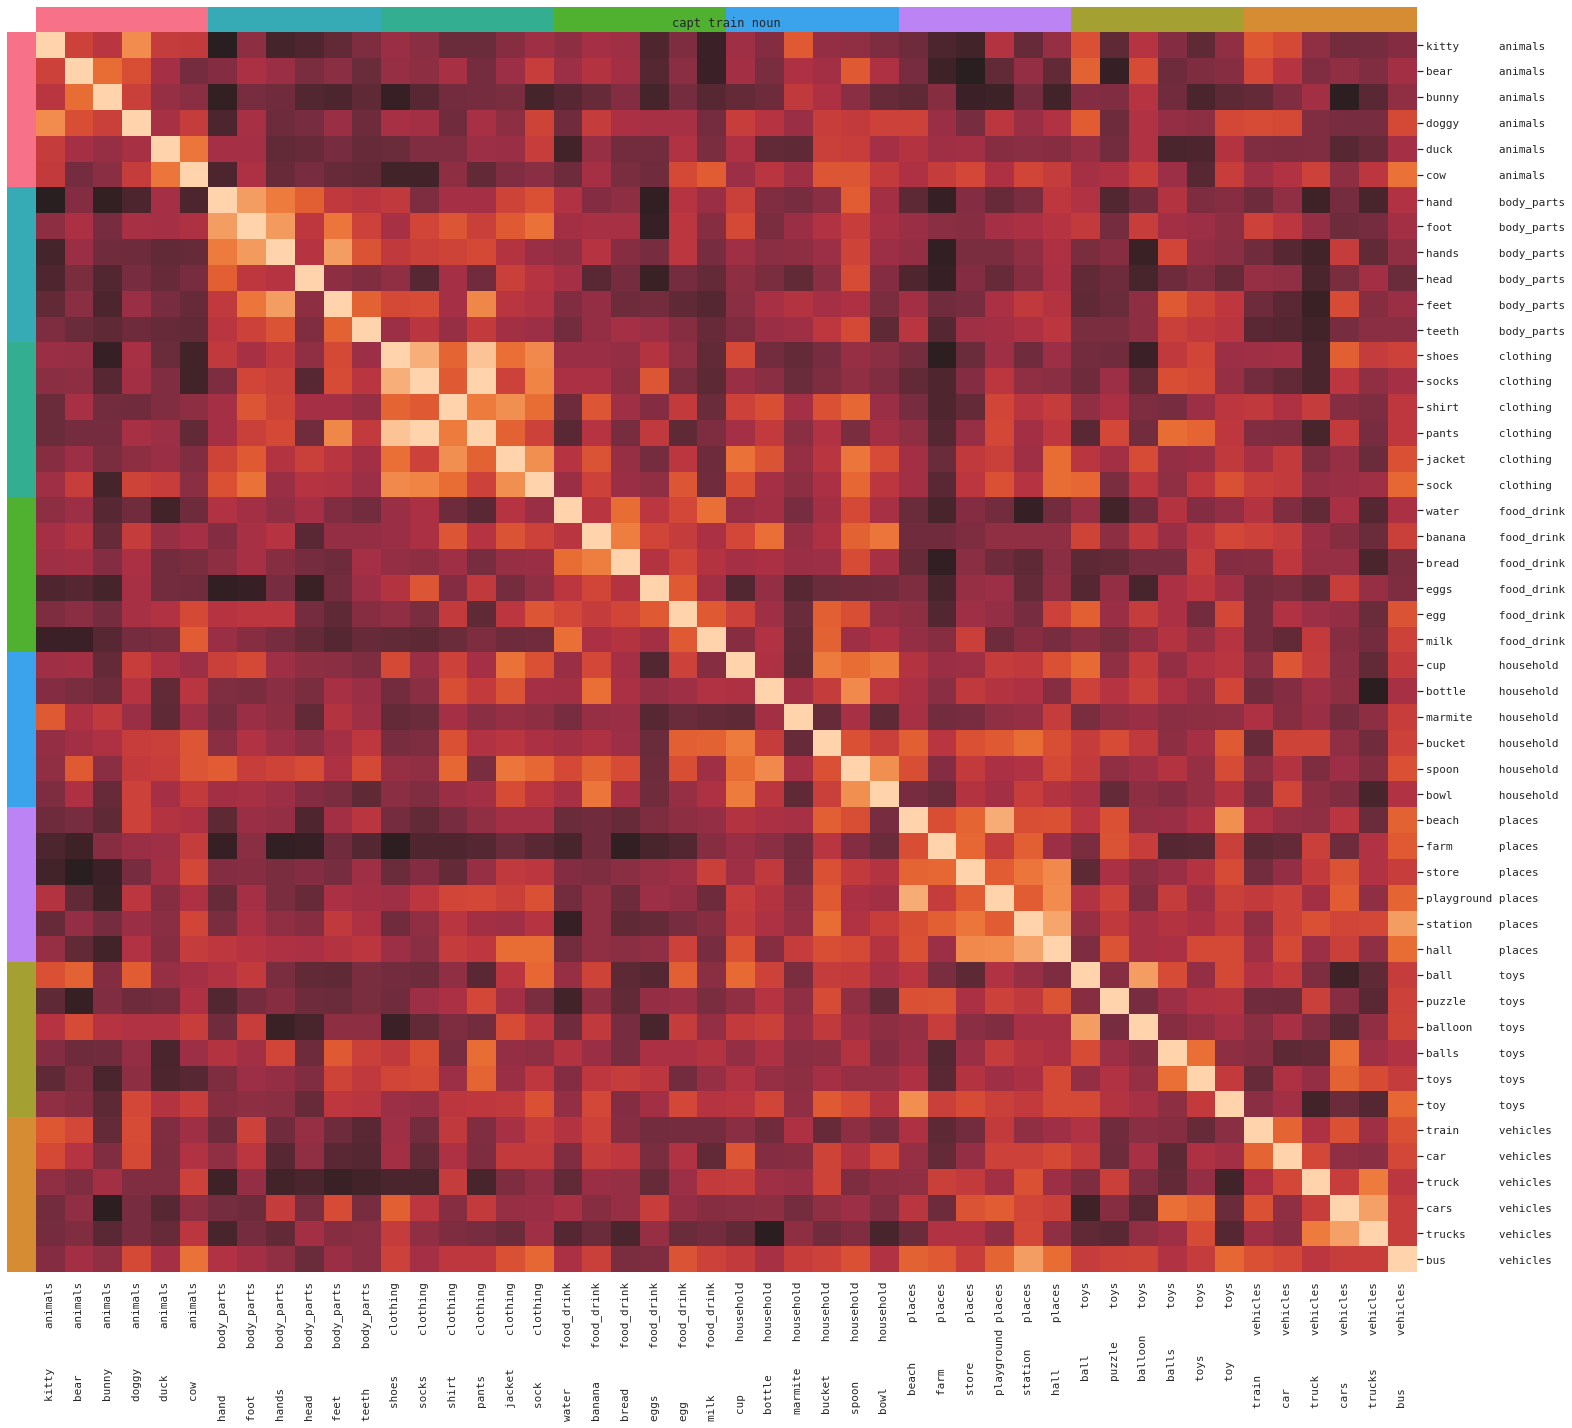

cbow:


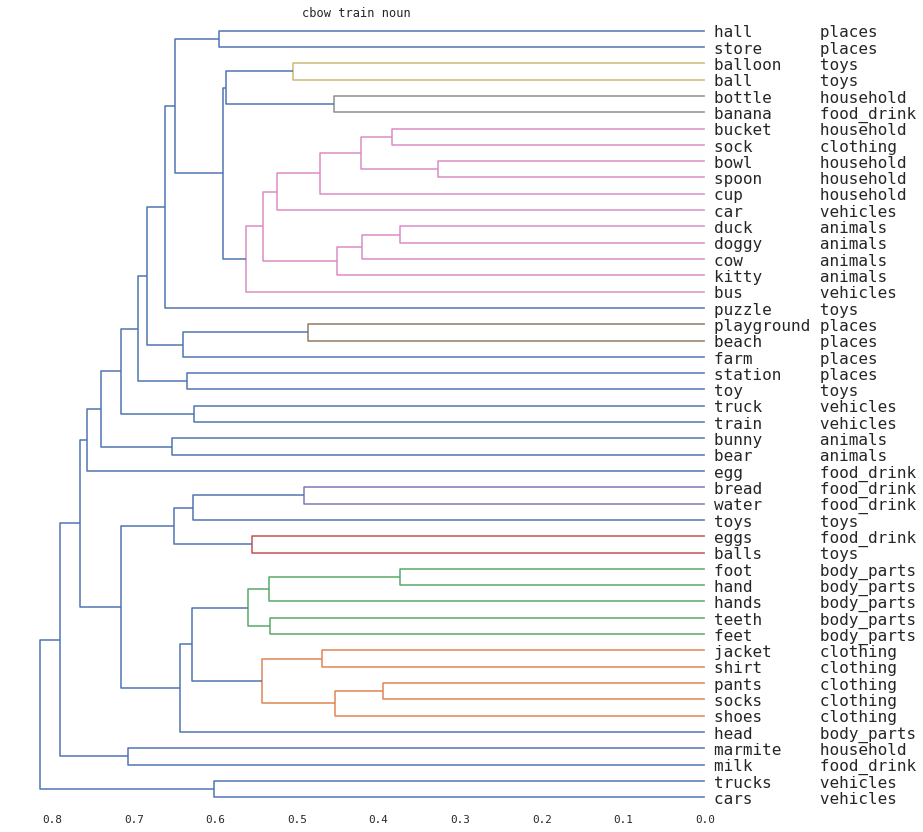

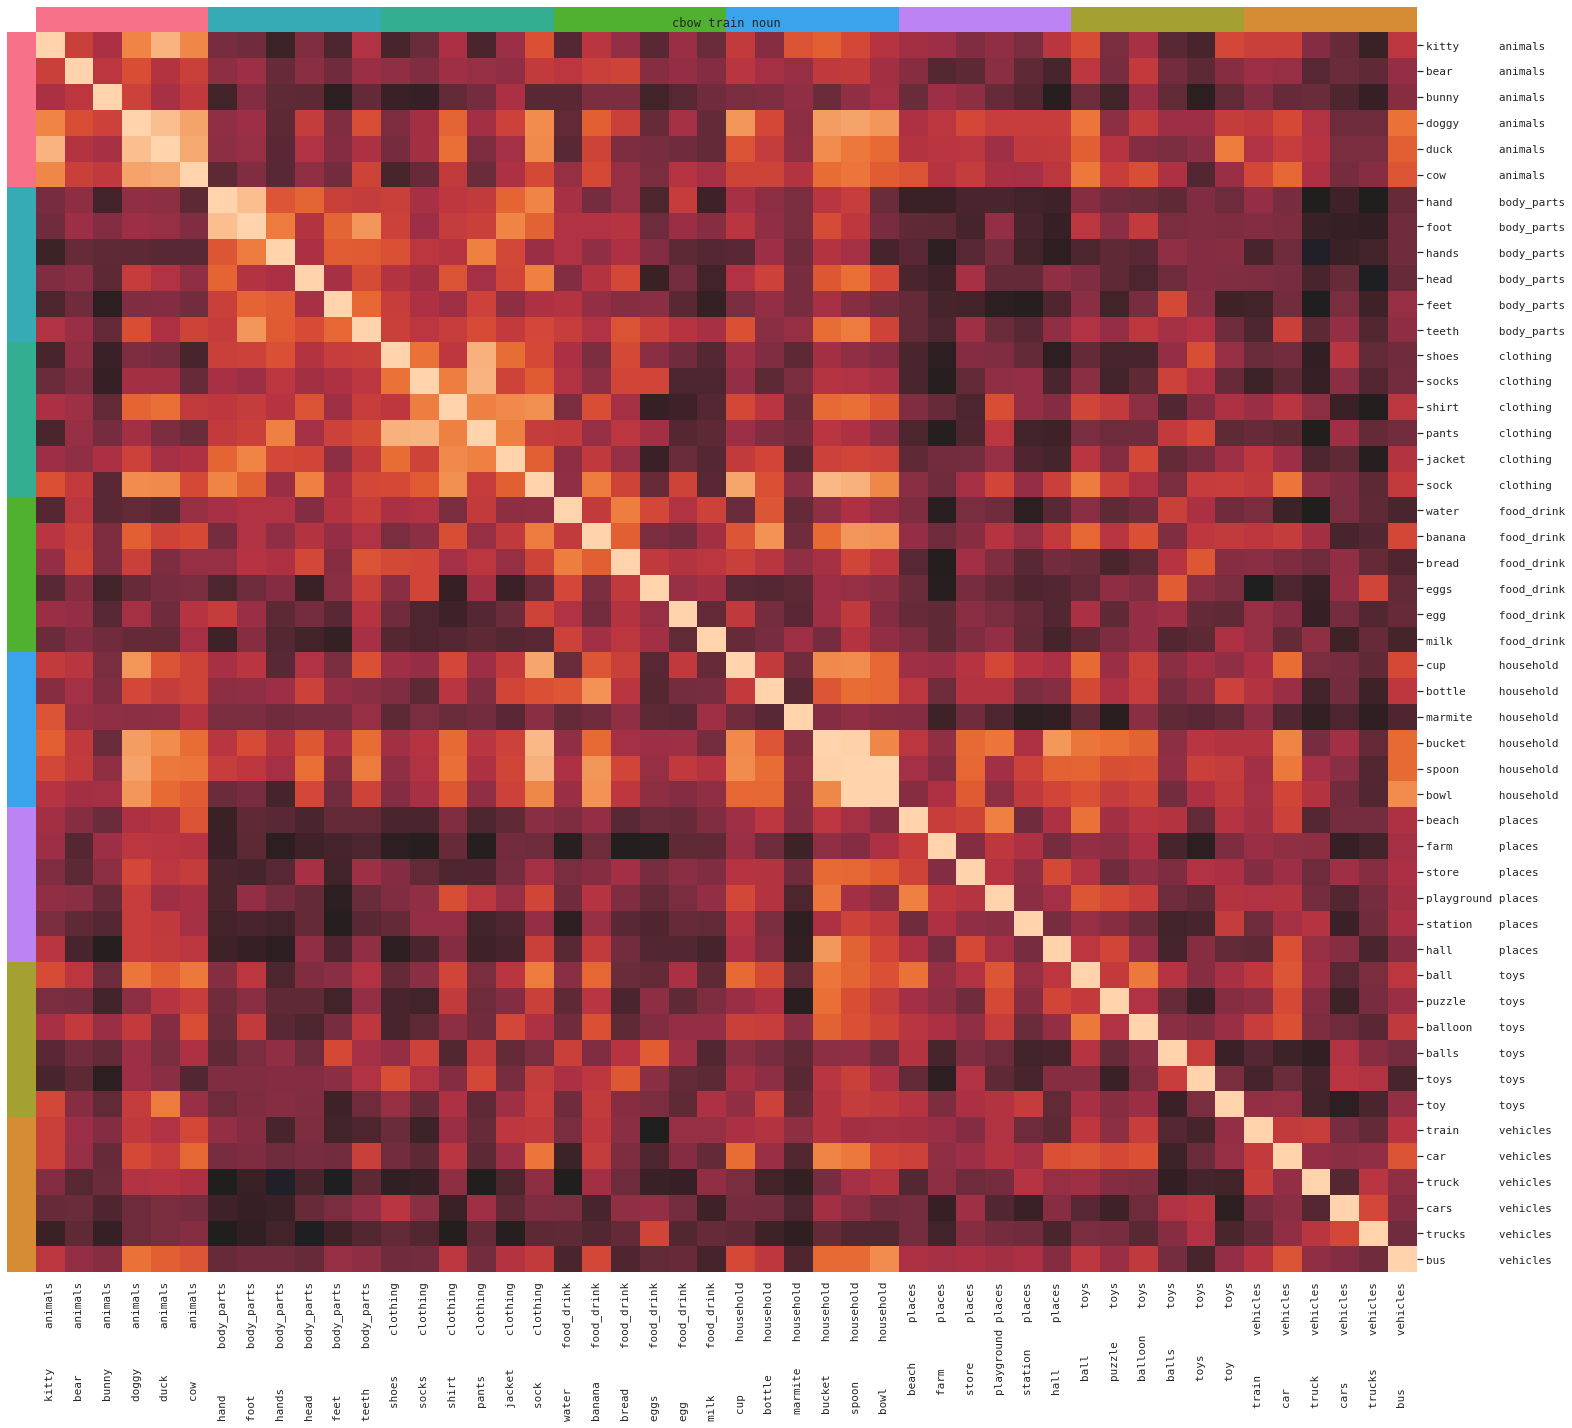

verb:


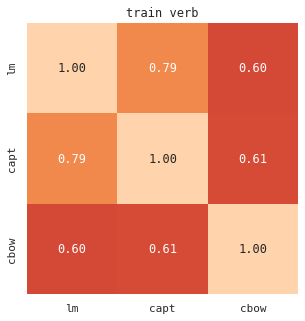

lm:


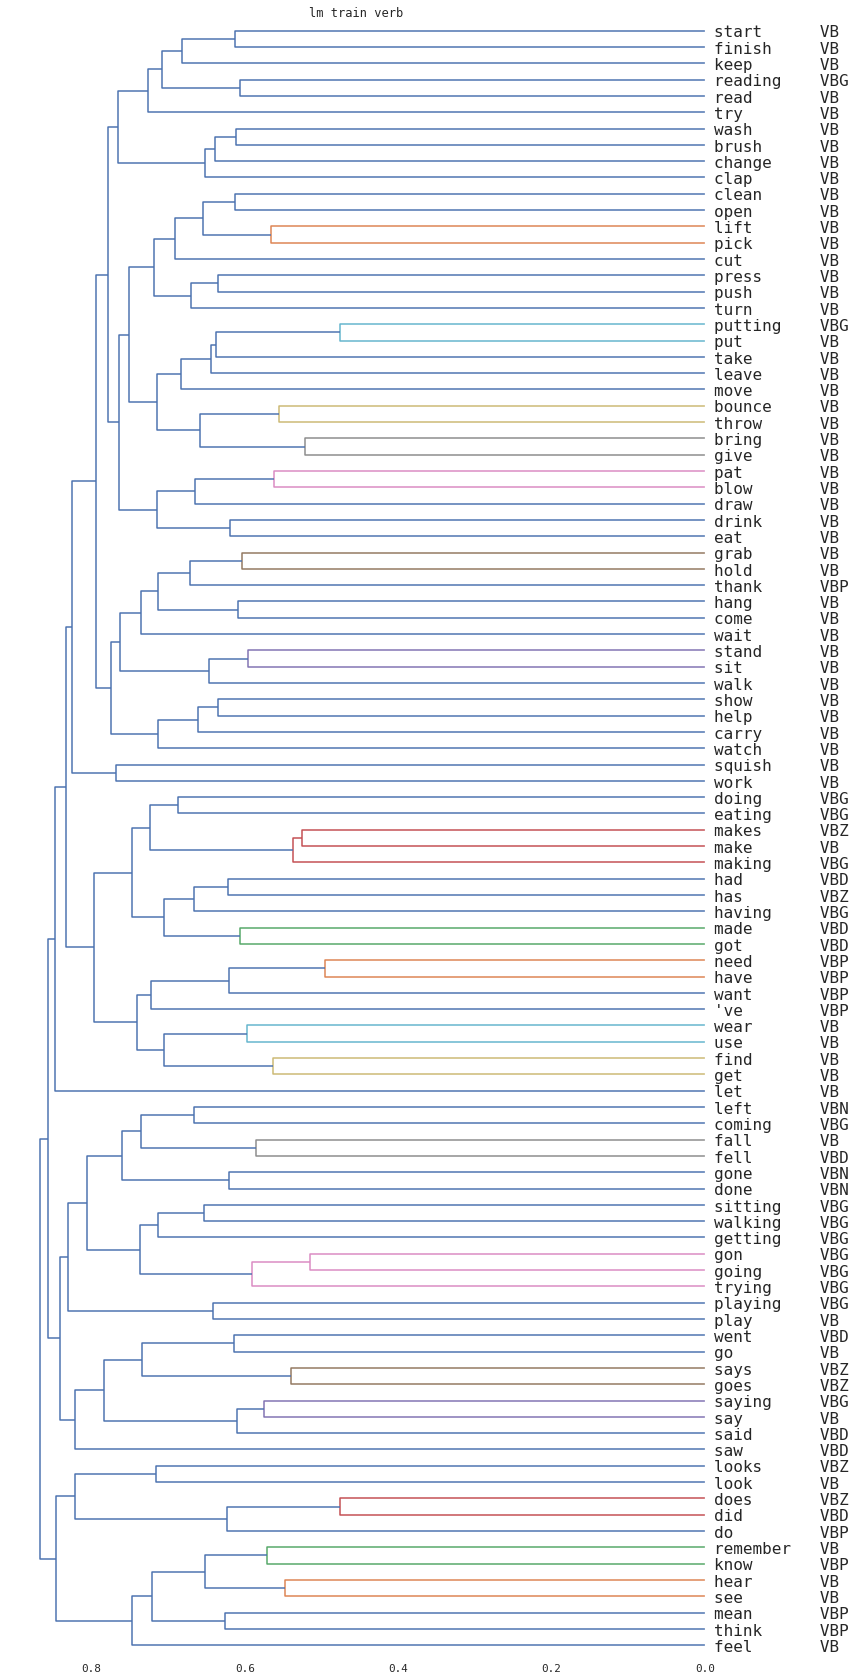

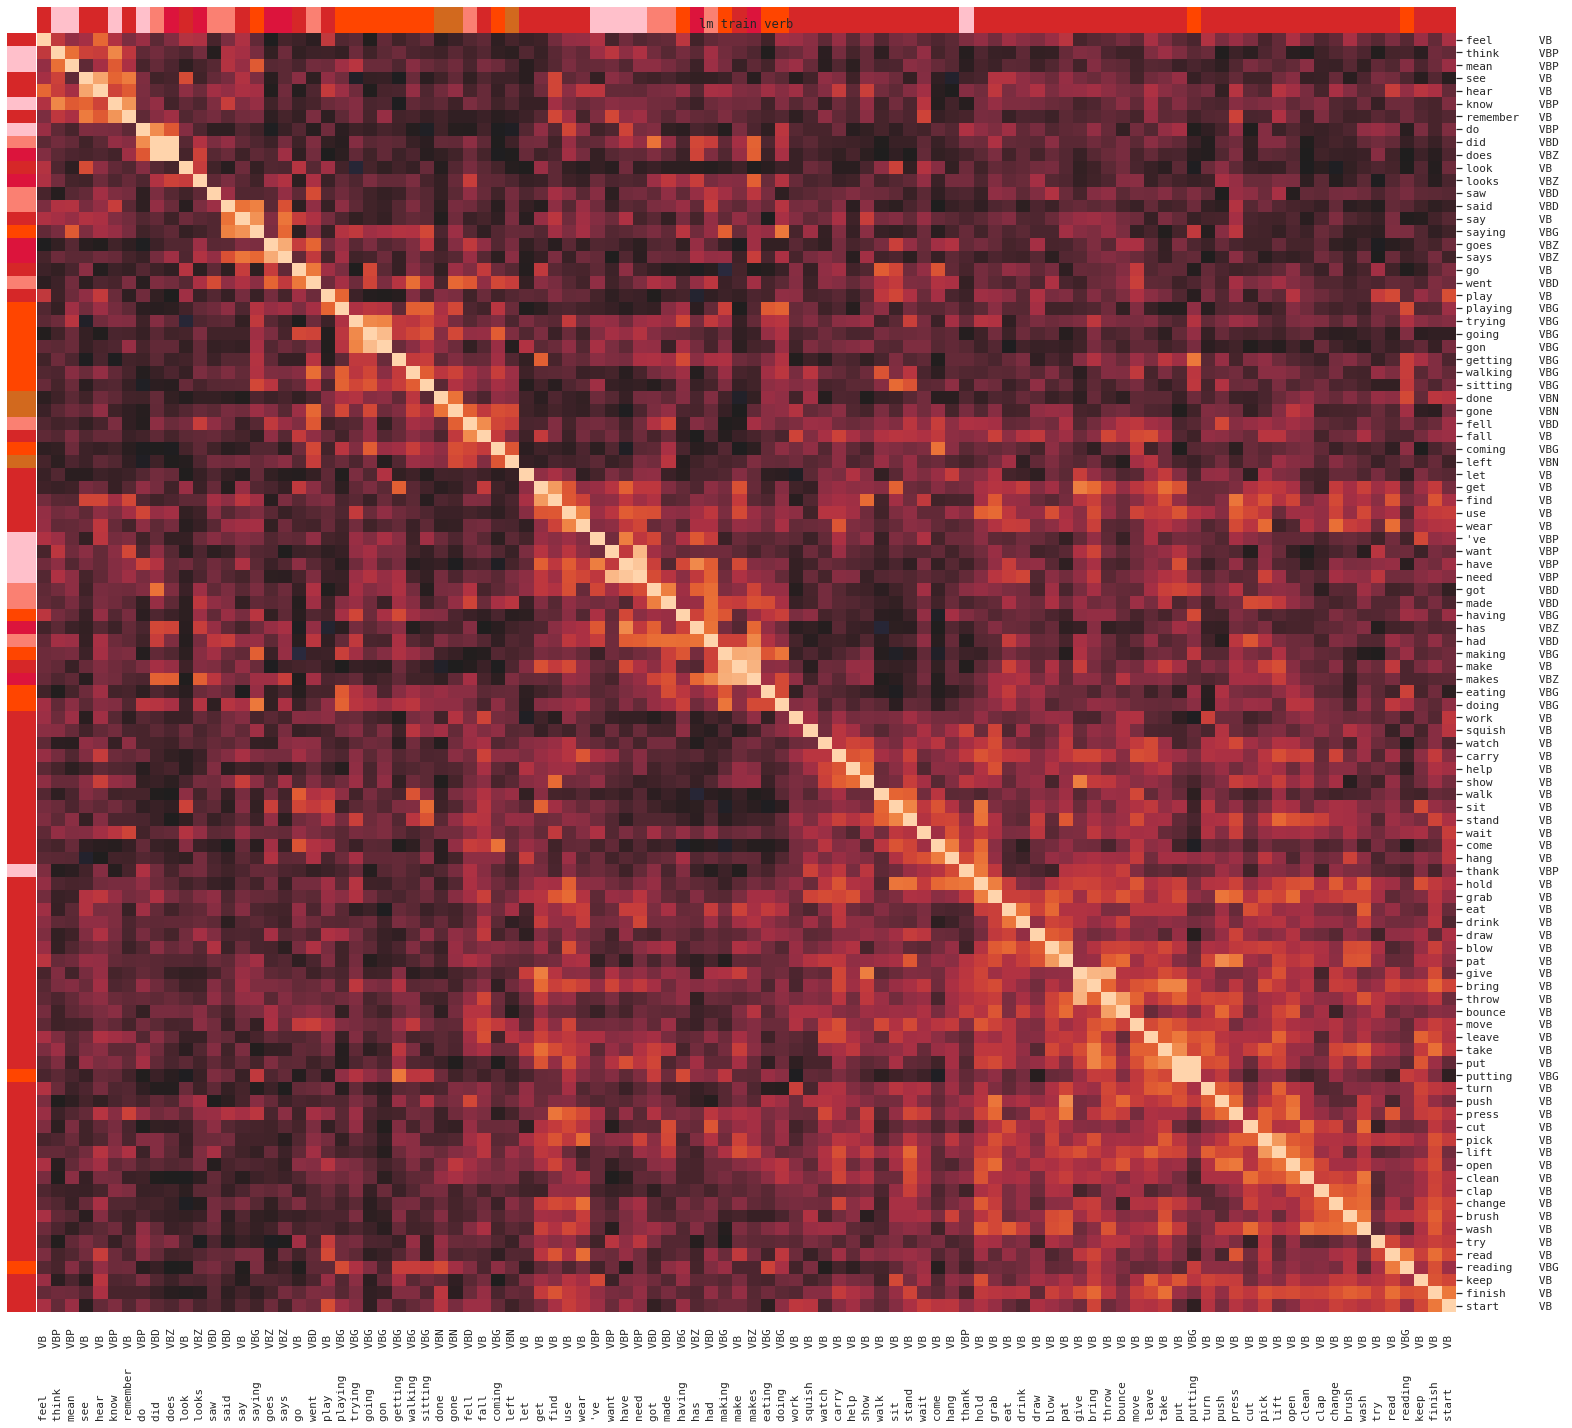

capt:


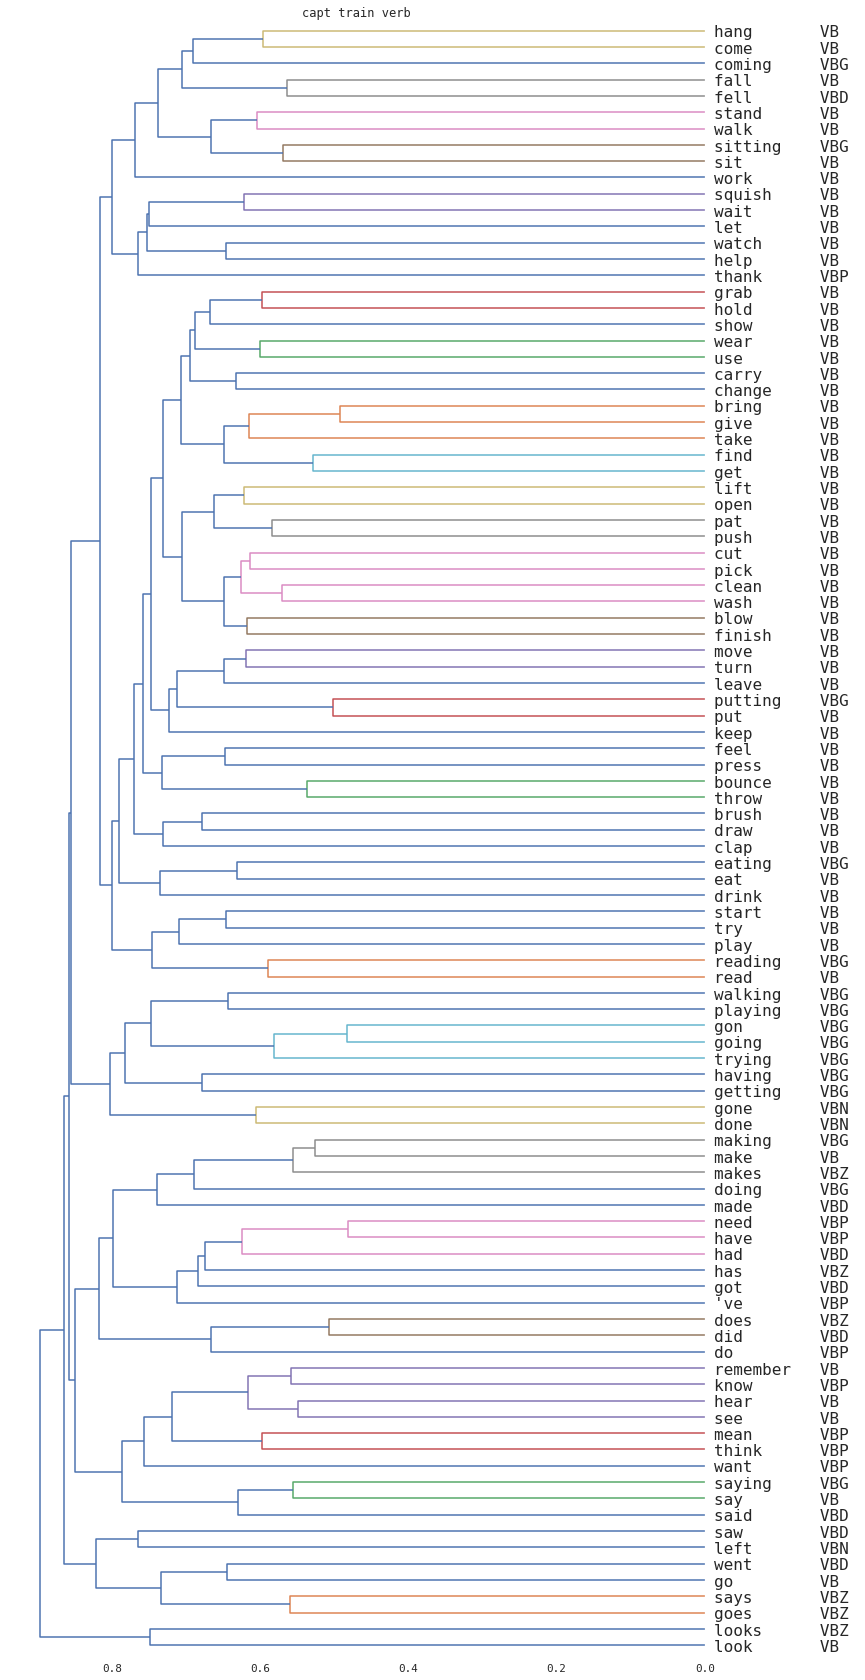

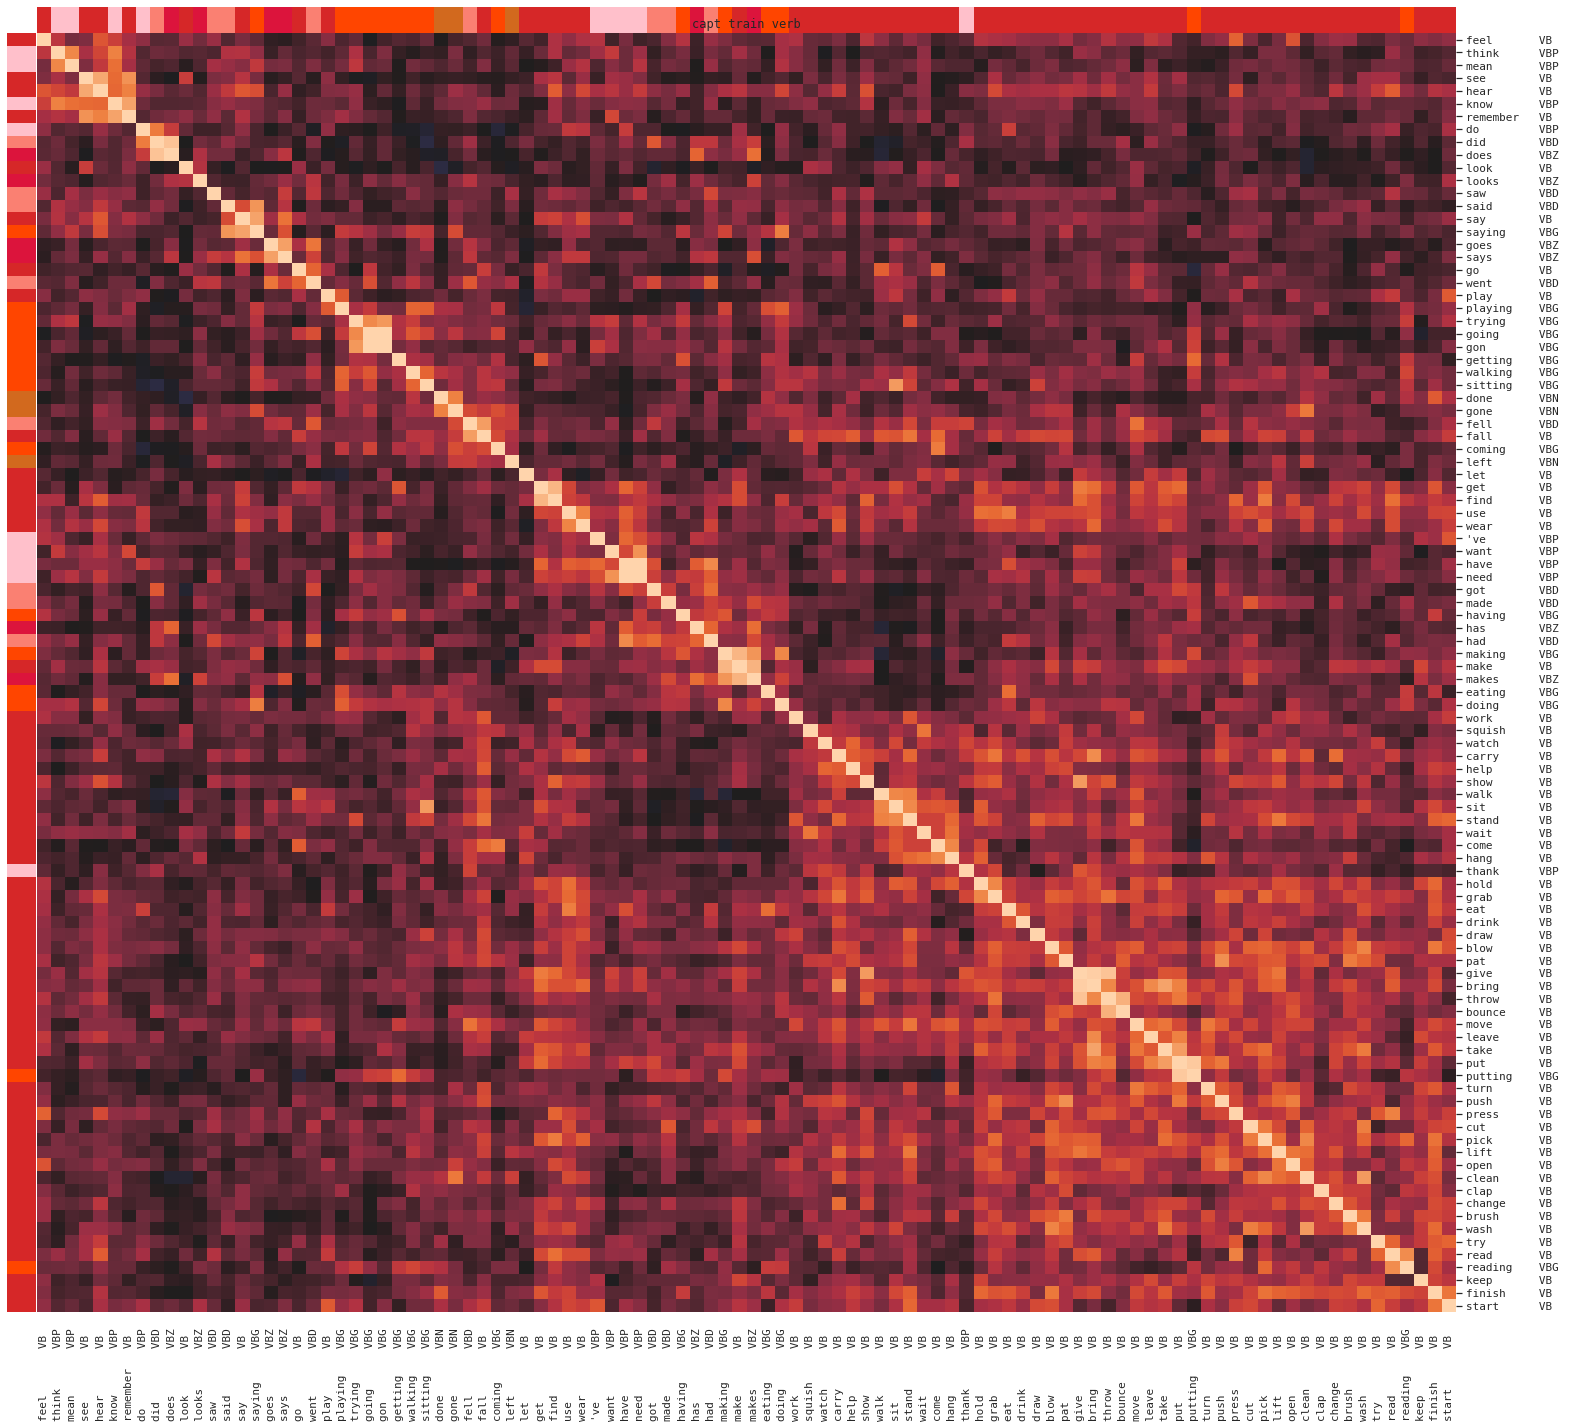

cbow:


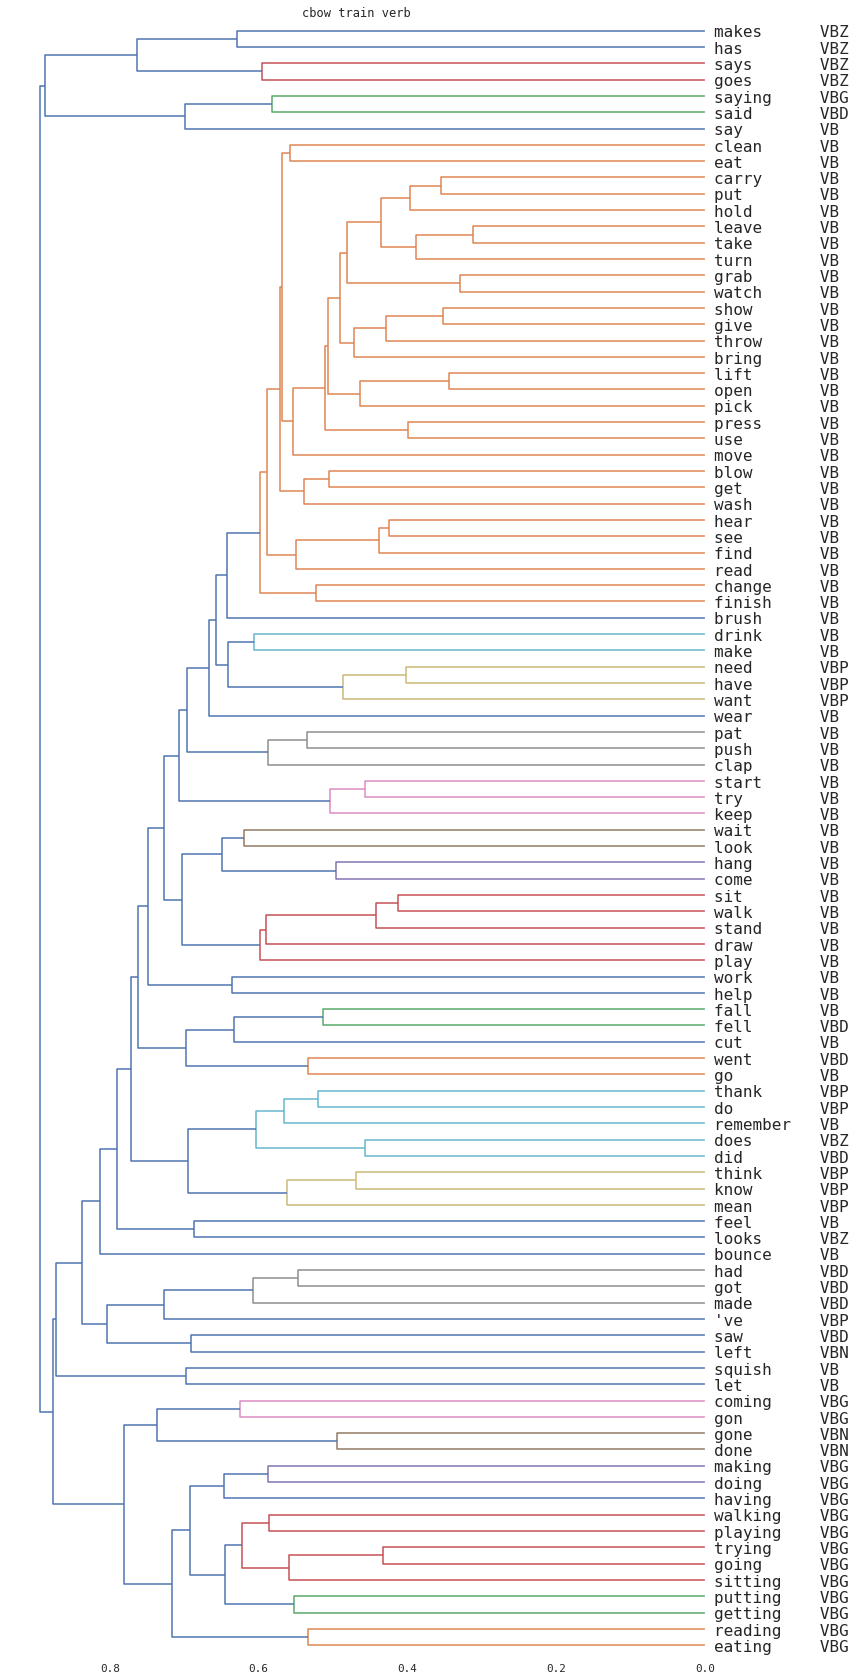

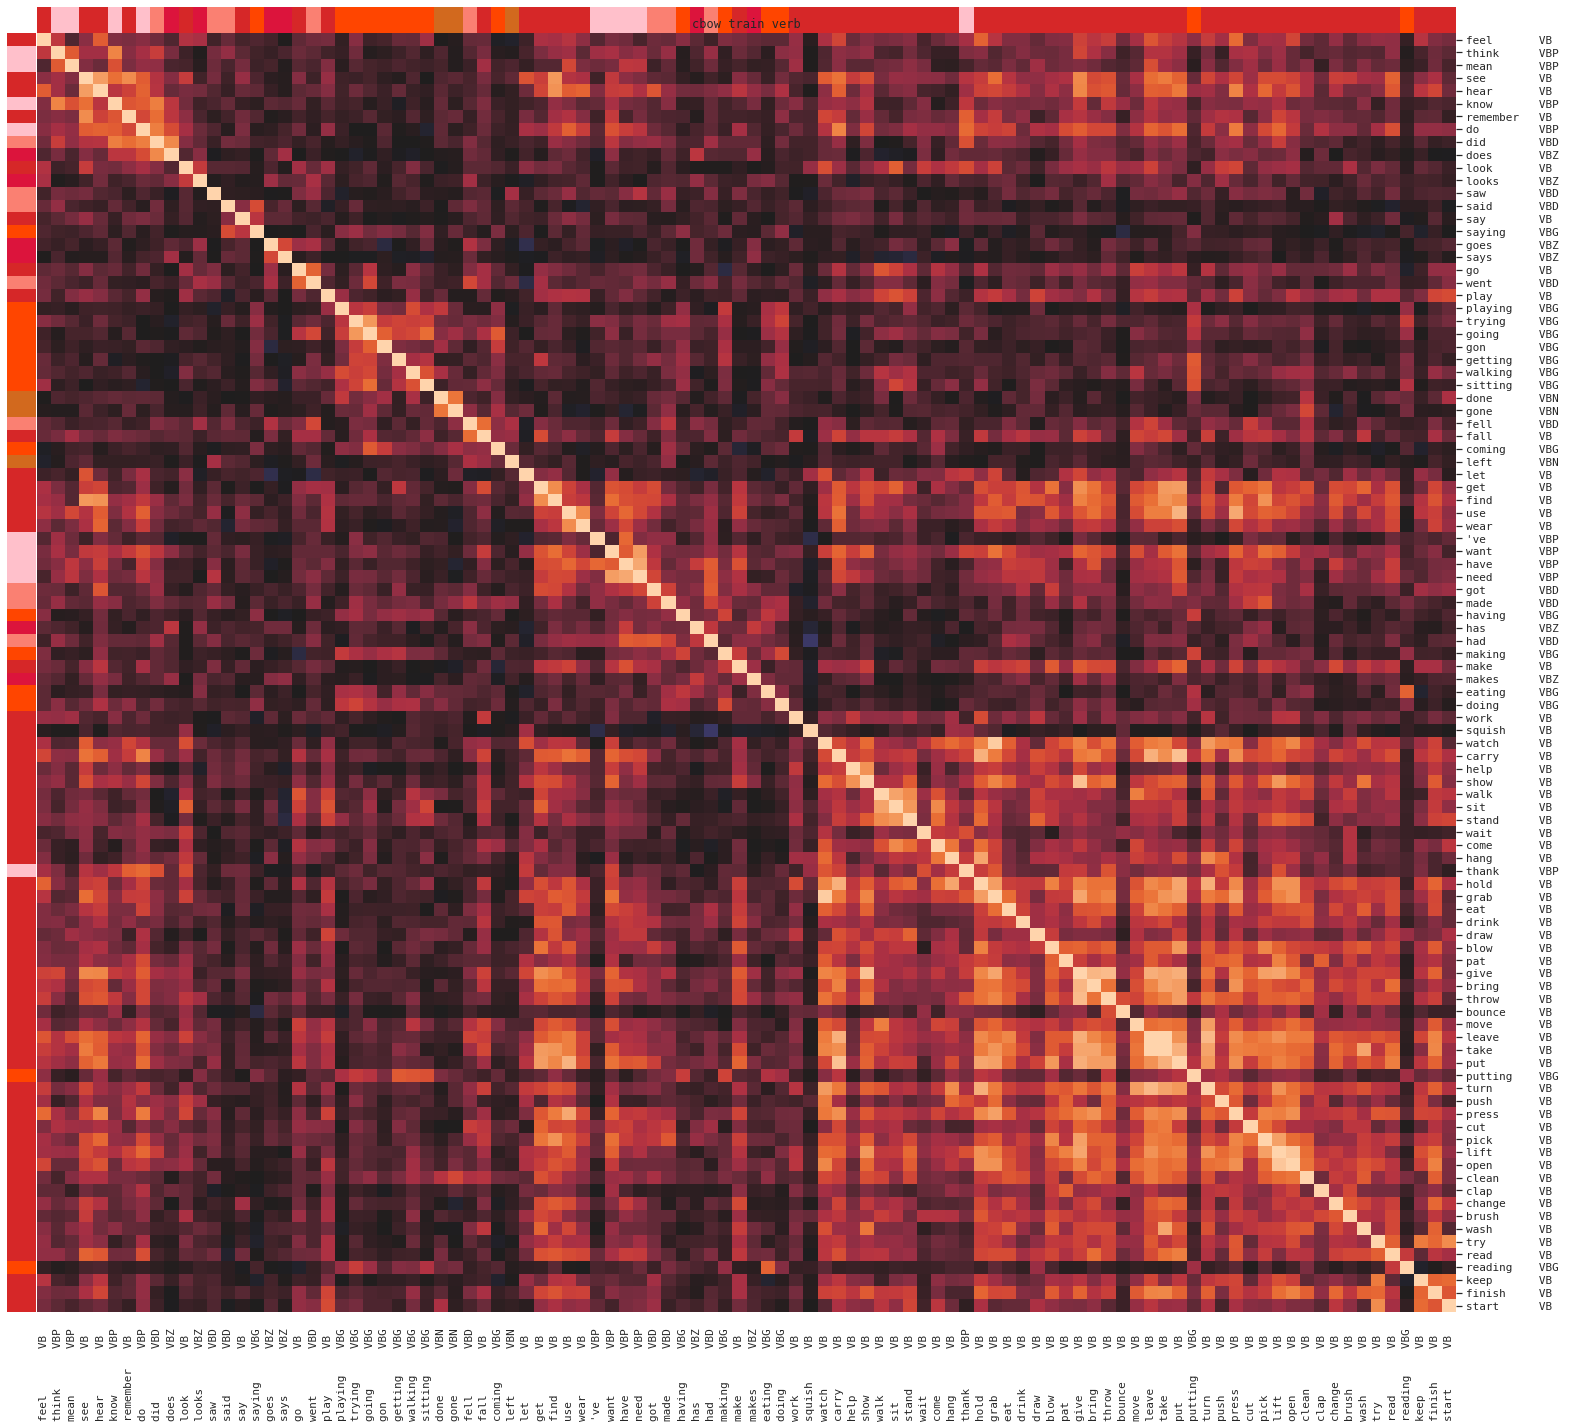

In [19]:
sns.set_theme(
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.grid': False,
        'axes.facecolor': 'white',
    }
)


def get_subcat_items(items, n_items_from_each_cat=6):
    dfs = []
    for cat_name, words in subcats:
        df = items[items[token_field].isin(words)].copy()
        if len(df) >= n_items_from_each_cat:
            dfs.append(df[:n_items_from_each_cat])
    items = pd.concat(dfs)
    items[subcat_field] = items[token_field].map(word2subcat).astype('category')
    return items


for split in ['train']:
    for name, items, tag_field, ll_tag_field, heatmap_linkage in (
        ('token', split_all_pos_items[split][:100], 'pos0', 'pos', 'first'),
        ('noun_verb', split_pos_pos_items[split][('noun', 'verb')][:100], 'pos0', 'pos', 'first'),
        ('noun', get_subcat_items(split_pos_items[split]['noun']), subcat_field, subcat_field, 'tag'),
        ('verb', split_pos_items[split]['verb'][:100], 'pos0', 'pos', 'first'),
    )[1:]:
        print(f'{name}:')
        plot_dendrogram(
            items,
            names,
            heatmap=True,
            heatmap_linkage=heatmap_linkage,
            title=f'{split} {name}',
            vector_attr=vector_attr,
            tag_field=tag_field,
            ll_tag_field=ll_tag_field,
            ll_with_cnt=False,
            ll_with_ppl=False,
        )

.               #: 65
adjective       #: 44
adverb          #: 45
cardinal number #: 11
function word   #: 82
noun            #: 220
verb            #: 150
plotting 1234/1234 = 100.00% items...


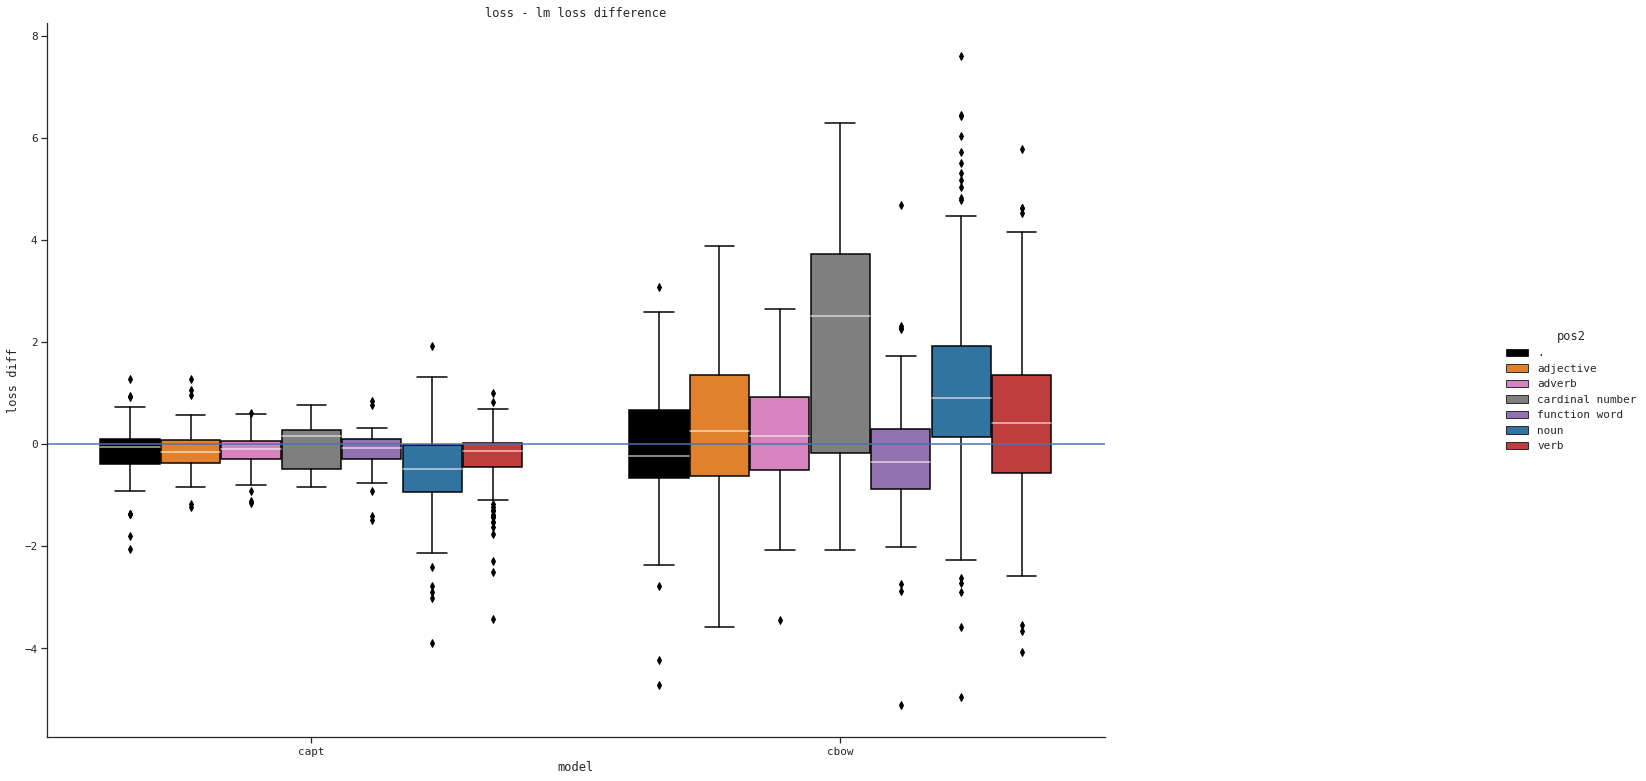

capt:
plotting 617/617 = 100.00% items...


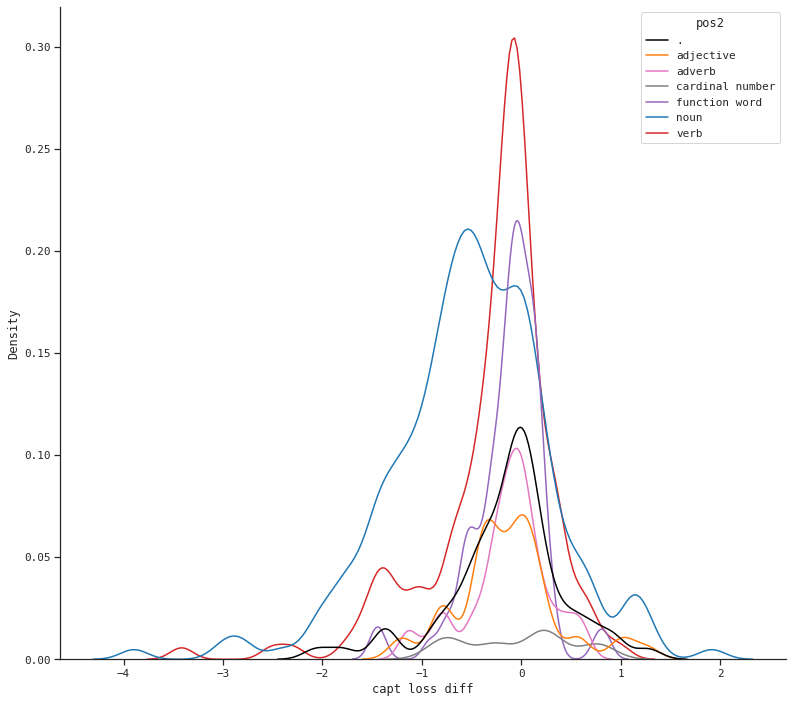

.               #examples:    65 mean: -0.155763 t-test result: statistic:  -2.09 pvalue: 0.040257
adjective       #examples:    44 mean: -0.136634 t-test result: statistic:  -1.75 pvalue: 0.086912
adverb          #examples:    45 mean: -0.135714 t-test result: statistic:  -2.23 pvalue: 0.030758
cardinal number #examples:    11 mean: -0.031279 t-test result: statistic:  -0.18 pvalue: 0.859079
function word   #examples:    82 mean: -0.130262 t-test result: statistic:  -3.25 pvalue: 0.001673
noun            #examples:   220 mean: -0.512436 t-test result: statistic:  -9.44 pvalue: 0.000000
verb            #examples:   150 mean: -0.285722 t-test result: statistic:  -5.58 pvalue: 0.000000
all tokens      #examples:   617 mean: -0.306099 t-test result: statistic: -11.42 pvalue: 0.000000
cbow:
plotting 617/617 = 100.00% items...


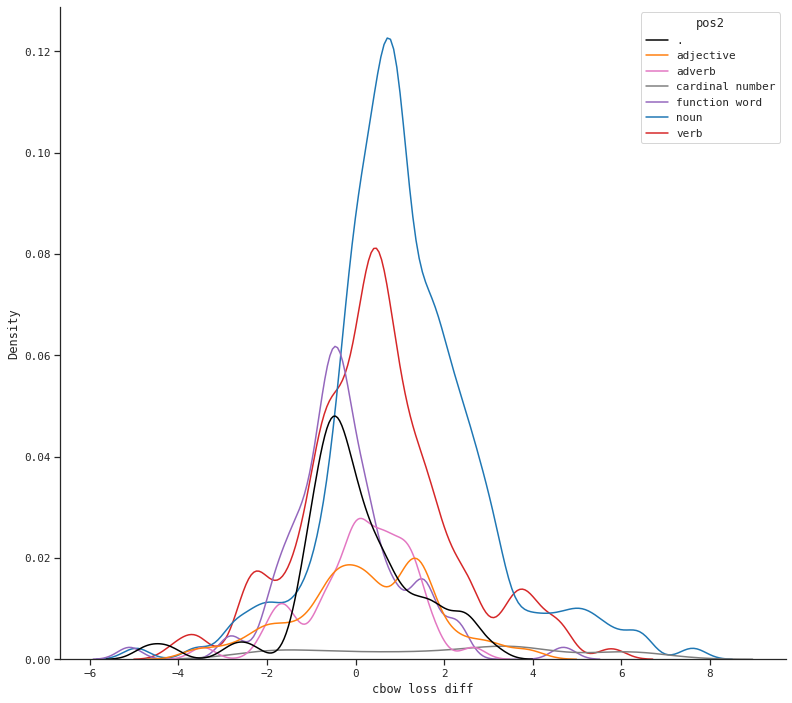

.               #examples:    65 mean: -0.032155 t-test result: statistic:  -0.18 pvalue: 0.853947
adjective       #examples:    44 mean:  0.244316 t-test result: statistic:   1.02 pvalue: 0.312841
adverb          #examples:    45 mean:  0.111819 t-test result: statistic:   0.63 pvalue: 0.529048
cardinal number #examples:    11 mean:  2.089115 t-test result: statistic:   2.40 pvalue: 0.037471
function word   #examples:    82 mean: -0.265710 t-test result: statistic:  -1.82 pvalue: 0.072510
noun            #examples:   220 mean:  1.131919 t-test result: statistic:   9.58 pvalue: 0.000000
verb            #examples:   150 mean:  0.491474 t-test result: statistic:   3.54 pvalue: 0.000542
all tokens      #examples:   617 mean:  0.547207 t-test result: statistic:   7.92 pvalue: 0.000000
.               #: 6811
adjective       #: 413
adverb          #: 740
cardinal number #: 80
function word   #: 4042
noun            #: 1406
verb            #: 2346
plotting 31676/31690 = 99.96% items...


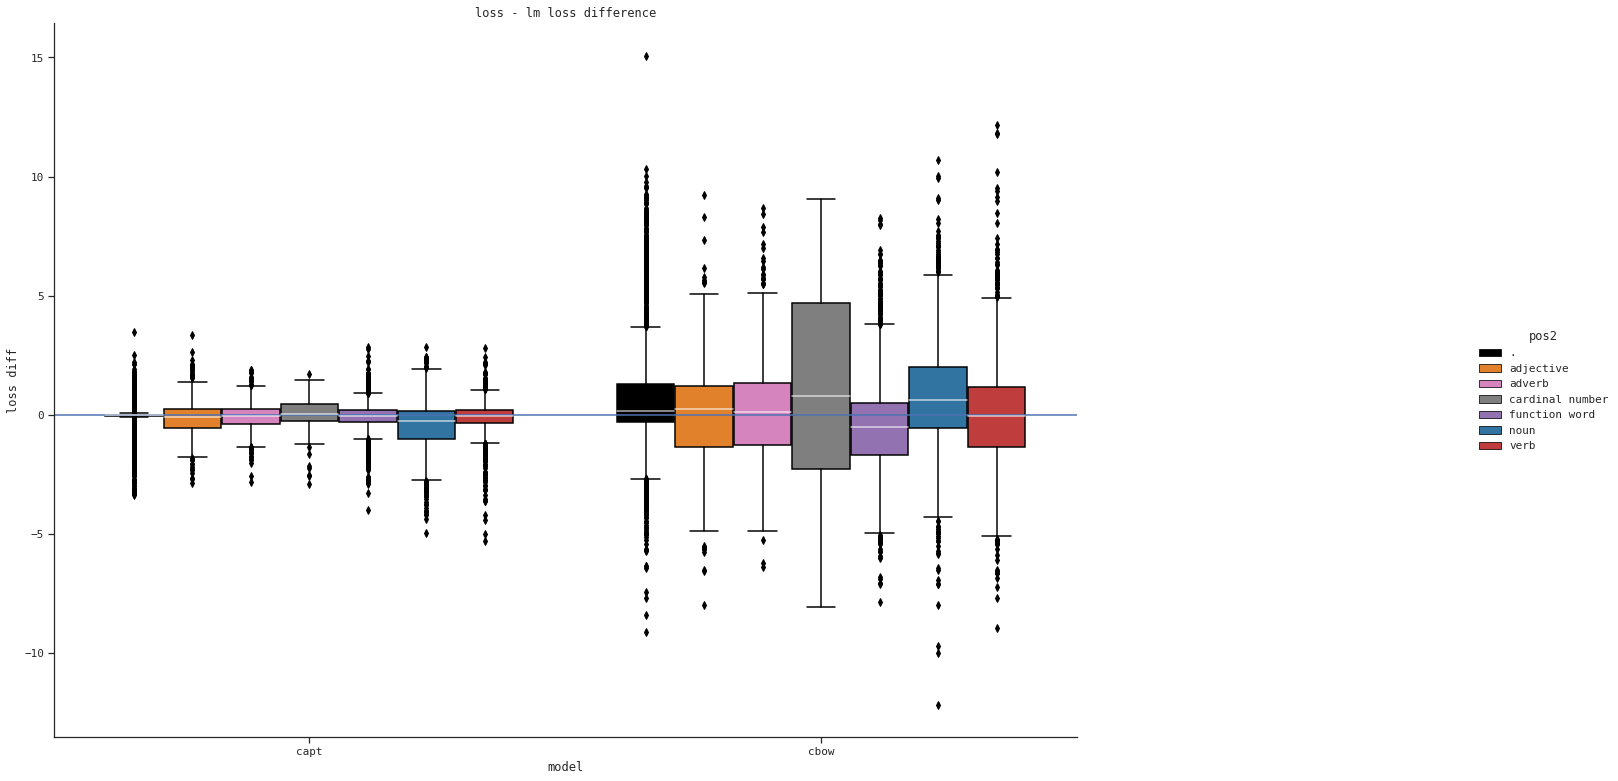

capt:
.               #examples:  6811 mean: -0.031484 t-test result: statistic:  -6.73 pvalue: 0.000000
adjective       #examples:   413 mean: -0.147666 t-test result: statistic:  -3.53 pvalue: 0.000457
adverb          #examples:   740 mean: -0.068404 t-test result: statistic:  -3.14 pvalue: 0.001736
cardinal number #examples:    80 mean: -0.058789 t-test result: statistic:  -0.58 pvalue: 0.561255
function word   #examples:  4042 mean: -0.059458 t-test result: statistic:  -7.00 pvalue: 0.000000
noun            #examples:  1406 mean: -0.422224 t-test result: statistic: -14.96 pvalue: 0.000000
verb            #examples:  2346 mean: -0.114733 t-test result: statistic:  -8.64 pvalue: 0.000000
all tokens      #examples: 15845 mean: -0.090558 t-test result: statistic: -19.27 pvalue: 0.000000
cbow:
.               #examples:  6811 mean:  0.696543 t-test result: statistic:  29.18 pvalue: 0.000000
adjective       #examples:   413 mean:  0.057357 t-test result: statistic:   0.49 pvalue: 0.62542

In [20]:
from scipy.stats import ttest_rel


def get_best_split_accuracy(label_0, label_1):
    n_label_0 = label_0.value_counts()[True]
    n_label_1 = label_1.value_counts()[True]

    i = 0
    count_0 = 0
    count_1 = n_label_1

    best_i, best_n = i, count_0 + count_1

    for label_i_0, label_i_1 in zip(label_0, label_1):
        count_0 += label_i_0
        count_1 -= label_i_1
        i += 1

        if count_0 + count_1 > best_n:
            best_i, best_n = i, count_0 + count_1

    print(f'n_label_0: {n_label_0}, n_label_1: {n_label_1}, best_accuracy: {best_n / (n_label_0 + n_label_1):.2%}')
    return best_i, best_n / (n_label_0 + n_label_1)


def plot_ROC(y_true, y_score, pos_label=None, label="", **kwargs):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{label} (AUC = {roc_auc:0.2f})",
        **kwargs,
    )


def plot_ROC_end(title="", **kwargs):
    plt.plot([0, 1], [0, 1], **kwargs)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} ROC")
    plt.legend(loc="lower right")
    plt.show()


def ttest(a, label, alternative):
    result = ttest_rel(a, np.zeros_like(a), alternative=alternative)
    print(f'{label:15} #examples: {len(a):5} mean: {np.mean(a):9.6f} t-test result: statistic: {result.statistic:6.2f} pvalue: {result.pvalue:8.6f}')


sns.set_theme(
    style="ticks",
    font='monospace',
    rc={
        'figure.figsize': figsize,
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)


def analyze_value_diff(
    value_diff_items,
    value_attr,
    names,
    baseline_name=None,
    cat_field="pos2",
    palette=pos_palette,
    find_best_threshold=False,
    plotting=True,
    ROC=False,
    ttest_alternative='less',
):
    """
    value_diff_items: items
    value_attr: column in value_diff_items; e.g., 'loss', 'prob'
    names: names of the models to analyze
    baseline_name: name of the model as the baseline
    cat_field: the category field
    palette: the palette for the categories; a dict mapping each category name to a color
    """

    for cat in value_diff_items.dtypes[cat_field].categories:
        items = value_diff_items[value_diff_items[cat_field] == cat]
        if len(items) > 0:
            print(f'{cat:15} #: {len(items)}')
    value_diff_items_long = value_diff_items.melt(id_vars=[cat_field], value_vars=[f'{name} {value_attr} diff' for name in names[1:] if 'contrastive' not in name], var_name='model', value_name=f'{value_attr} diff')
    value_diff_items_long['model'] = value_diff_items_long['model'].map(lambda s: s[:-len(f' {value_attr} diff')])
    plot(sns.catplot, value_diff_items_long, x='model', y=f'{value_attr} diff', hue=cat_field, palette=palette, hlines=[0], kind="box", figsize=(26, 12), medianprops=dict(color="white", alpha=0.7), title=f"{value_attr} - lm {value_attr} difference")

    # use the first name as the baseline by default
    if baseline_name is None:
        baseline_name = names[0]

    for name in filter(lambda name: name != baseline_name and 'contrastive' not in name, names):
        print(f'{name}:')
        value_diff_field = f"{name} {value_attr} diff"
        items = value_diff_items.sort_values(value_diff_field)

        if find_best_threshold:
            assert cat_field == "pos2"
            label_0 = items[cat_field].isin(["noun"])
            label_1 = ~label_0 #items[cat_field].isin(["function word", "adjective", "adverb", "cardinal number"])
            best_split_i, best_split_acc = get_best_split_accuracy(label_0, label_1)
            print(f'best_split_accuracy: {best_split_acc:.2%}')
            threshold = items.iloc[min(best_split_i, len(items)-1)][value_diff_field]

        if plotting:
            plot(sns.kdeplot, items, x=value_diff_field, hue=cat_field, palette=palette, bw_adjust=.5)

            if ROC:
                for cat in items.dtypes[cat_field].categories:
                    plot_ROC(items[cat_field], -items[value_diff_field], pos_label=cat, label=f"{cat} vs others", color=palette[cat])
                plot_ROC_end(title=value_diff_field)

        for cat in items.dtypes[cat_field].categories:
            ttest(items.loc[items[cat_field] == cat, value_diff_field], cat, ttest_alternative)
        ttest(items[value_diff_field], "all tokens", ttest_alternative)


value_field = 'loss'
ttest_alternative = 'two-sided'

for split in ['val']:
    token_items = split_items[split].token_items
    analyze_value_diff(token_items[token_items['cnt'] >= 2], value_field, names, ttest_alternative=ttest_alternative)

    all_token_items = split_items[split].all_token_items
    if all_token_items is not None:
        print('=' * 100)
        analyze_value_diff(all_token_items.reset_index(drop=True), value_field, names, plotting=False, ttest_alternative=ttest_alternative)

#: 382
animals         #: 85
body_parts      #: 27
clothing        #: 38
food_drink      #: 84
games_routines  #: 13
household       #: 31
places          #: 9
toys            #: 49
vehicles        #: 46
plotting 764/764 = 100.00% items...


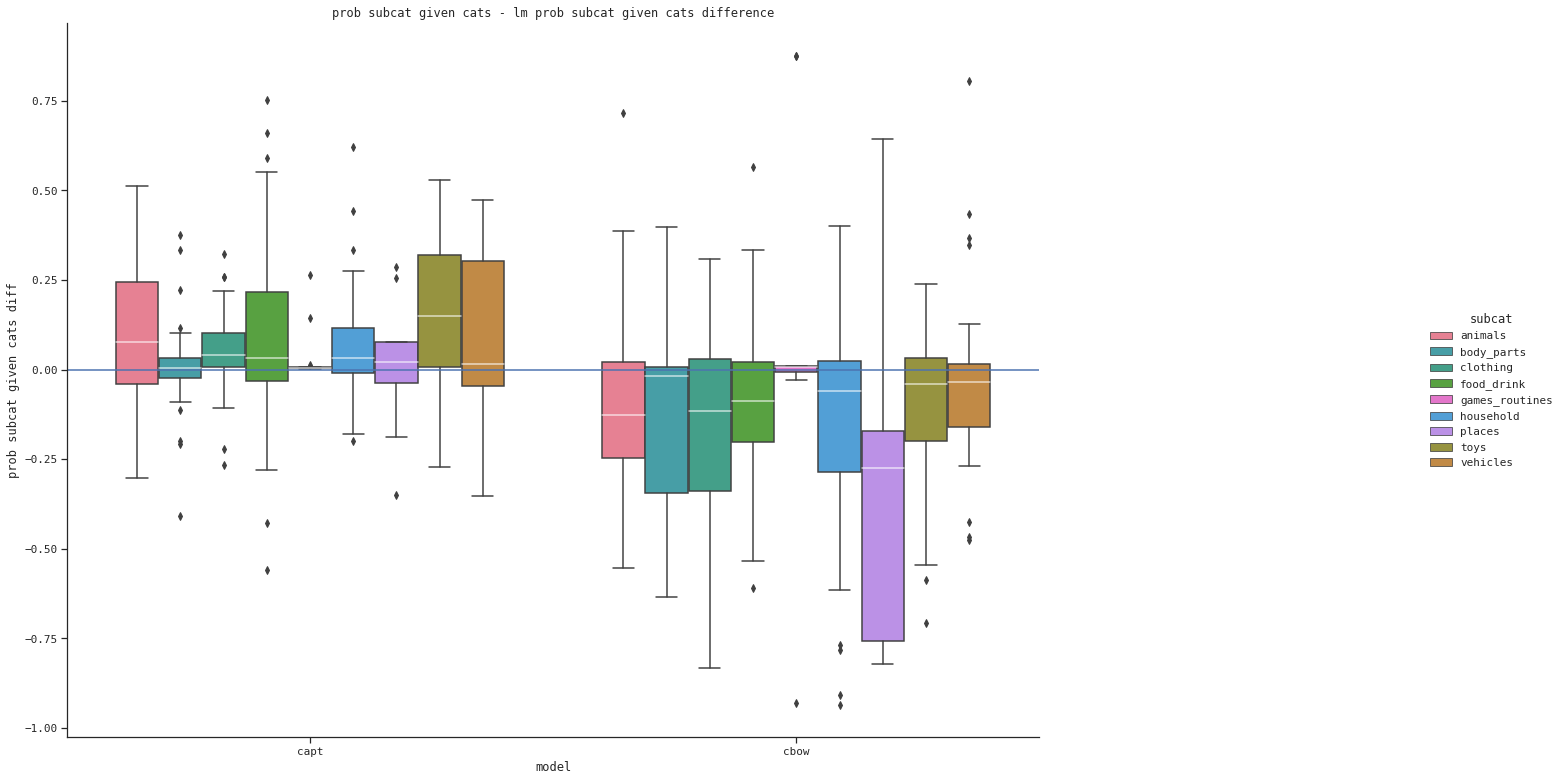

capt:
plotting 382/382 = 100.00% items...


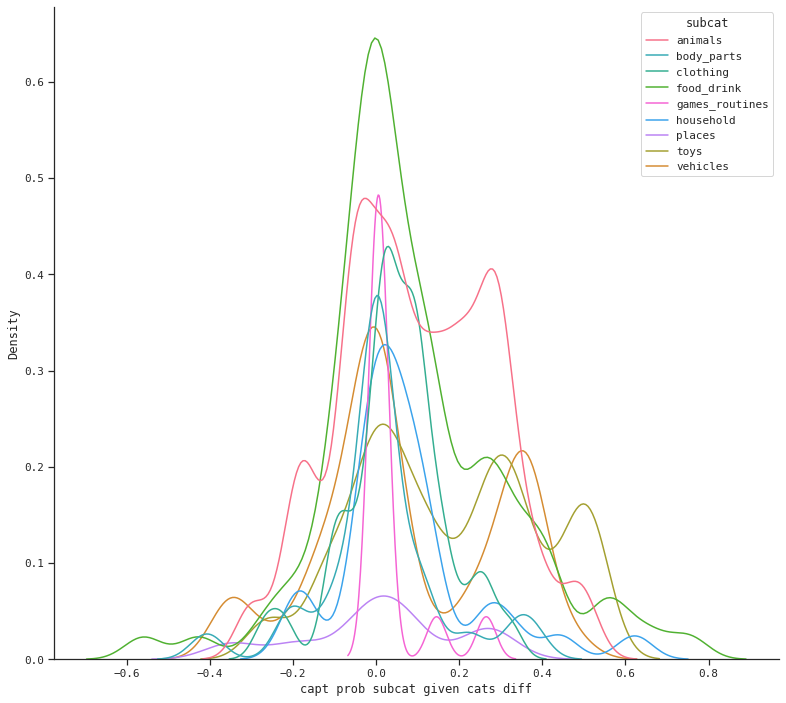

animals         #examples:    85 mean:  0.098265 t-test result: statistic:   4.89 pvalue: 0.000005
body_parts      #examples:    27 mean:  0.008959 t-test result: statistic:   0.30 pvalue: 0.763818
clothing        #examples:    38 mean:  0.048363 t-test result: statistic:   2.47 pvalue: 0.018092
food_drink      #examples:    84 mean:  0.089836 t-test result: statistic:   3.72 pvalue: 0.000365
games_routines  #examples:    13 mean:  0.036208 t-test result: statistic:   1.66 pvalue: 0.123706
household       #examples:    31 mean:  0.074607 t-test result: statistic:   2.43 pvalue: 0.021077
places          #examples:     9 mean:  0.010640 t-test result: statistic:   0.16 pvalue: 0.875978
toys            #examples:    49 mean:  0.174516 t-test result: statistic:   5.54 pvalue: 0.000001
vehicles        #examples:    46 mean:  0.075553 t-test result: statistic:   2.34 pvalue: 0.023965
all tokens      #examples:   382 mean:  0.086085 t-test result: statistic:   8.60 pvalue: 0.000000
cbow:
plot

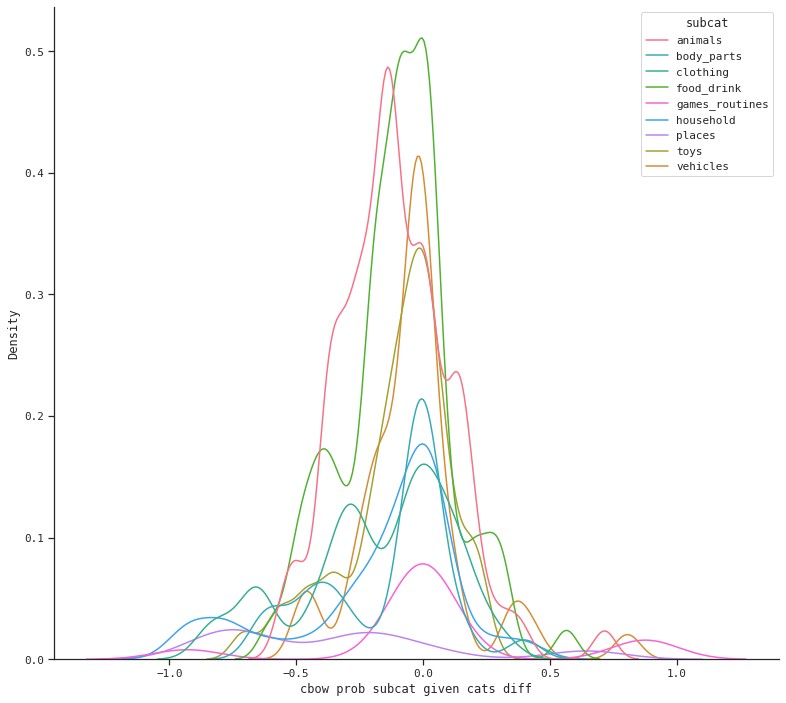

animals         #examples:    85 mean: -0.107793 t-test result: statistic:  -4.56 pvalue: 0.000017
body_parts      #examples:    27 mean: -0.132247 t-test result: statistic:  -2.70 pvalue: 0.011979
clothing        #examples:    38 mean: -0.182969 t-test result: statistic:  -3.80 pvalue: 0.000518
food_drink      #examples:    84 mean: -0.096004 t-test result: statistic:  -4.13 pvalue: 0.000087
games_routines  #examples:    13 mean:  0.062944 t-test result: statistic:   0.51 pvalue: 0.617339
household       #examples:    31 mean: -0.169832 t-test result: statistic:  -2.88 pvalue: 0.007261
places          #examples:     9 mean: -0.335551 t-test result: statistic:  -2.12 pvalue: 0.066391
toys            #examples:    49 mean: -0.097249 t-test result: statistic:  -3.23 pvalue: 0.002230
vehicles        #examples:    46 mean: -0.036176 t-test result: statistic:  -1.11 pvalue: 0.272772
all tokens      #examples:   382 mean: -0.109021 t-test result: statistic:  -8.18 pvalue: 0.000000
animals   

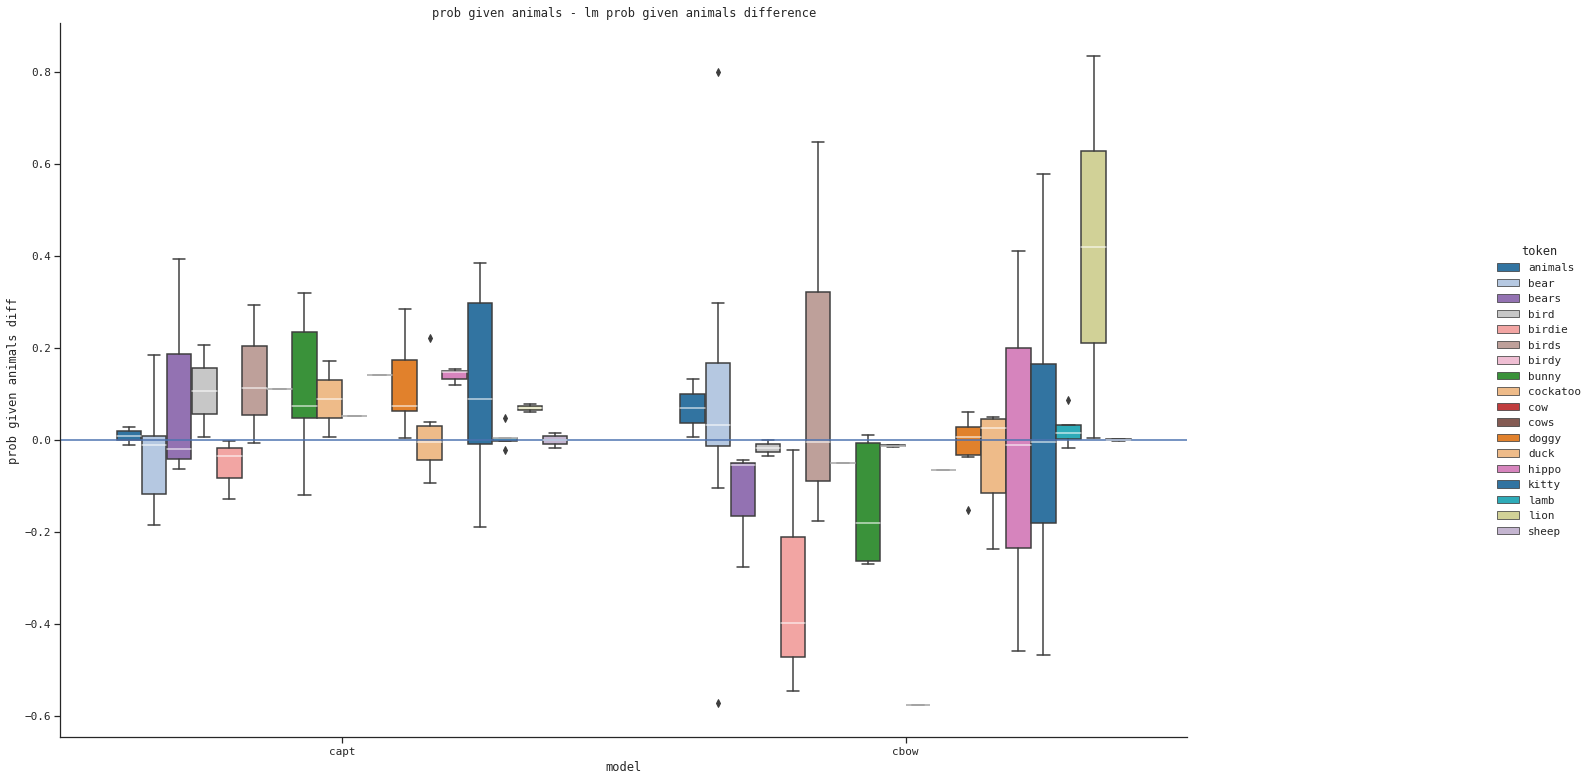

capt:
animals         #examples:     2 mean:  0.008985 t-test result: statistic:   0.45 pvalue: 0.731370
bear            #examples:    15 mean: -0.025332 t-test result: statistic:  -0.90 pvalue: 0.382169
bears           #examples:     3 mean:  0.103187 t-test result: statistic:   0.71 pvalue: 0.551125
bird            #examples:     2 mean:  0.106142 t-test result: statistic:   1.05 pvalue: 0.482978
birdie          #examples:     3 mean: -0.055517 t-test result: statistic:  -1.46 pvalue: 0.282099
birds           #examples:     3 mean:  0.133595 t-test result: statistic:   1.54 pvalue: 0.264357
birdy           #examples:     1 mean:  0.111347 t-test result: statistic:    nan pvalue:      nan
bunny           #examples:     5 mean:  0.111094 t-test result: statistic:   1.45 pvalue: 0.219856
cockatoo        #examples:     2 mean:  0.088883 t-test result: statistic:   1.09 pvalue: 0.473363
cow             #examples:     1 mean:  0.051269 t-test result: statistic:    nan pvalue:      nan
cows

/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


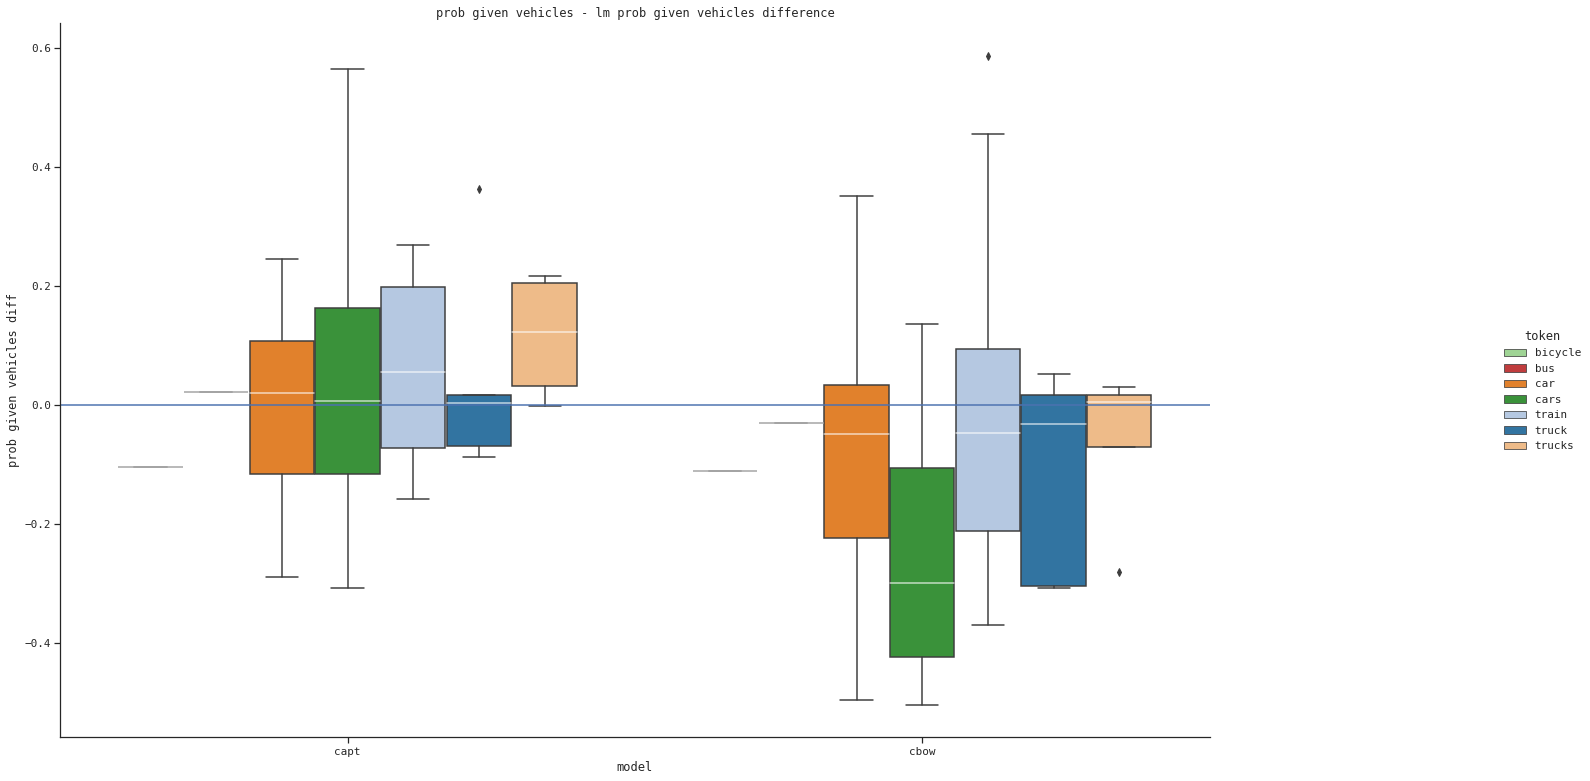

capt:
bicycle         #examples:     1 mean: -0.104261 t-test result: statistic:    nan pvalue:      nan
bus             #examples:     1 mean:  0.021129 t-test result: statistic:    nan pvalue:      nan
car             #examples:    15 mean: -0.002110 t-test result: statistic:  -0.05 pvalue: 0.959719
cars            #examples:     7 mean:  0.050741 t-test result: statistic:   0.46 pvalue: 0.662860
train           #examples:    13 mean:  0.068230 t-test result: statistic:   1.66 pvalue: 0.122178
truck           #examples:     5 mean:  0.045197 t-test result: statistic:   0.55 pvalue: 0.610478
trucks          #examples:     4 mean:  0.114840 t-test result: statistic:   2.08 pvalue: 0.128873
all tokens      #examples:    46 mean:  0.039408 t-test result: statistic:   1.52 pvalue: 0.134385
cbow:
bicycle         #examples:     1 mean: -0.111594 t-test result: statistic:    nan pvalue:      nan
bus             #examples:     1 mean: -0.029796 t-test result: statistic:    nan pvalue:      na

/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


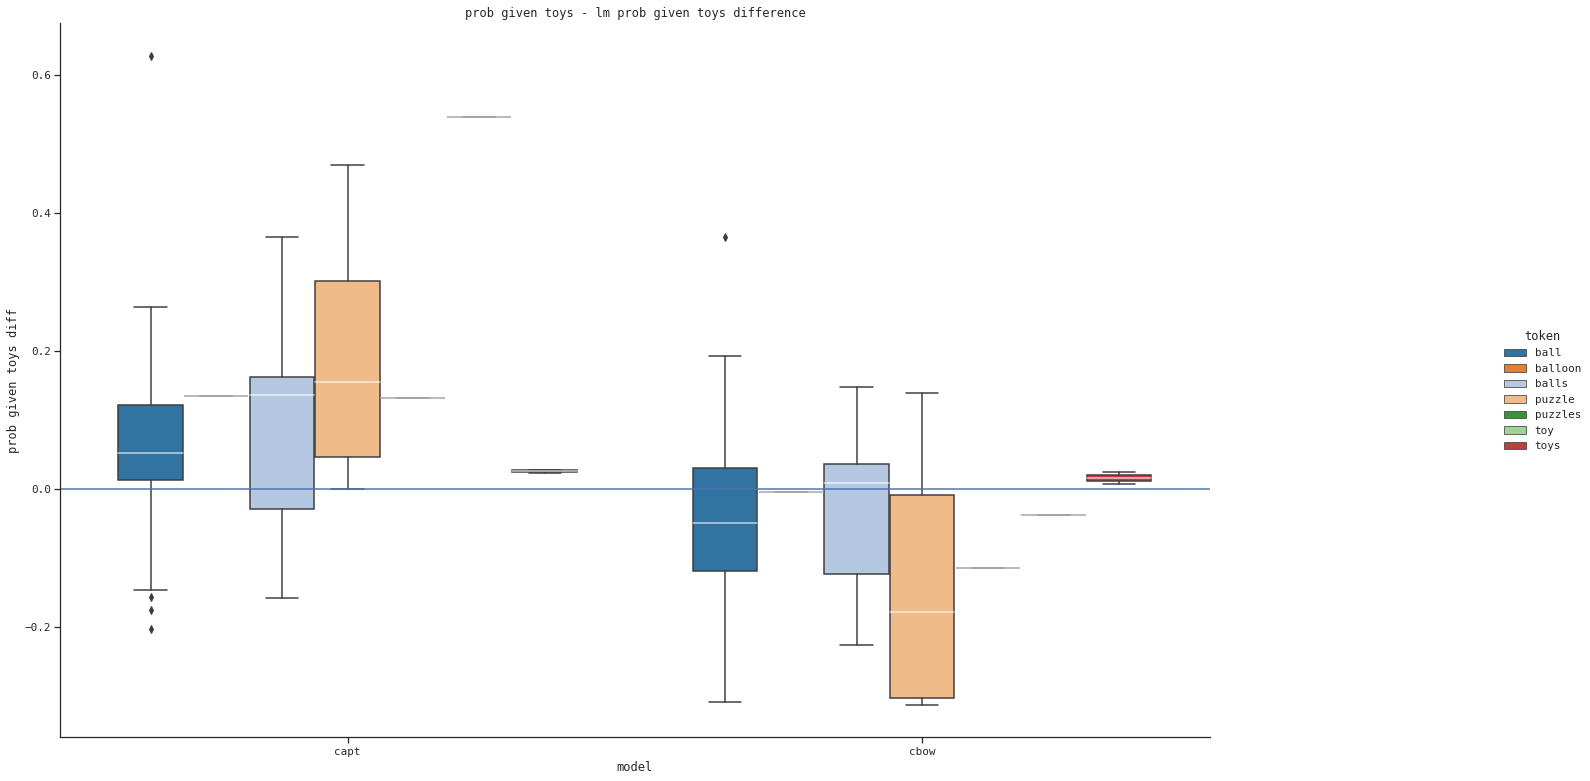

capt:
ball            #examples:    31 mean:  0.070137 t-test result: statistic:   2.56 pvalue: 0.015763
balloon         #examples:     1 mean:  0.135109 t-test result: statistic:    nan pvalue:      nan
balls           #examples:     9 mean:  0.097035 t-test result: statistic:   1.72 pvalue: 0.124522
puzzle          #examples:     4 mean:  0.194524 t-test result: statistic:   1.85 pvalue: 0.161873
puzzles         #examples:     1 mean:  0.131175 t-test result: statistic:    nan pvalue:      nan
toy             #examples:     1 mean:  0.539445 t-test result: statistic:    nan pvalue:      nan
toys            #examples:     2 mean:  0.025934 t-test result: statistic:  12.56 pvalue: 0.050567
all tokens      #examples:    49 mean:  0.095577 t-test result: statistic:   4.02 pvalue: 0.000206
cbow:
ball            #examples:    31 mean: -0.036610 t-test result: statistic:  -1.45 pvalue: 0.156231
balloon         #examples:     1 mean: -0.004330 t-test result: statistic:    nan pvalue:      na

/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


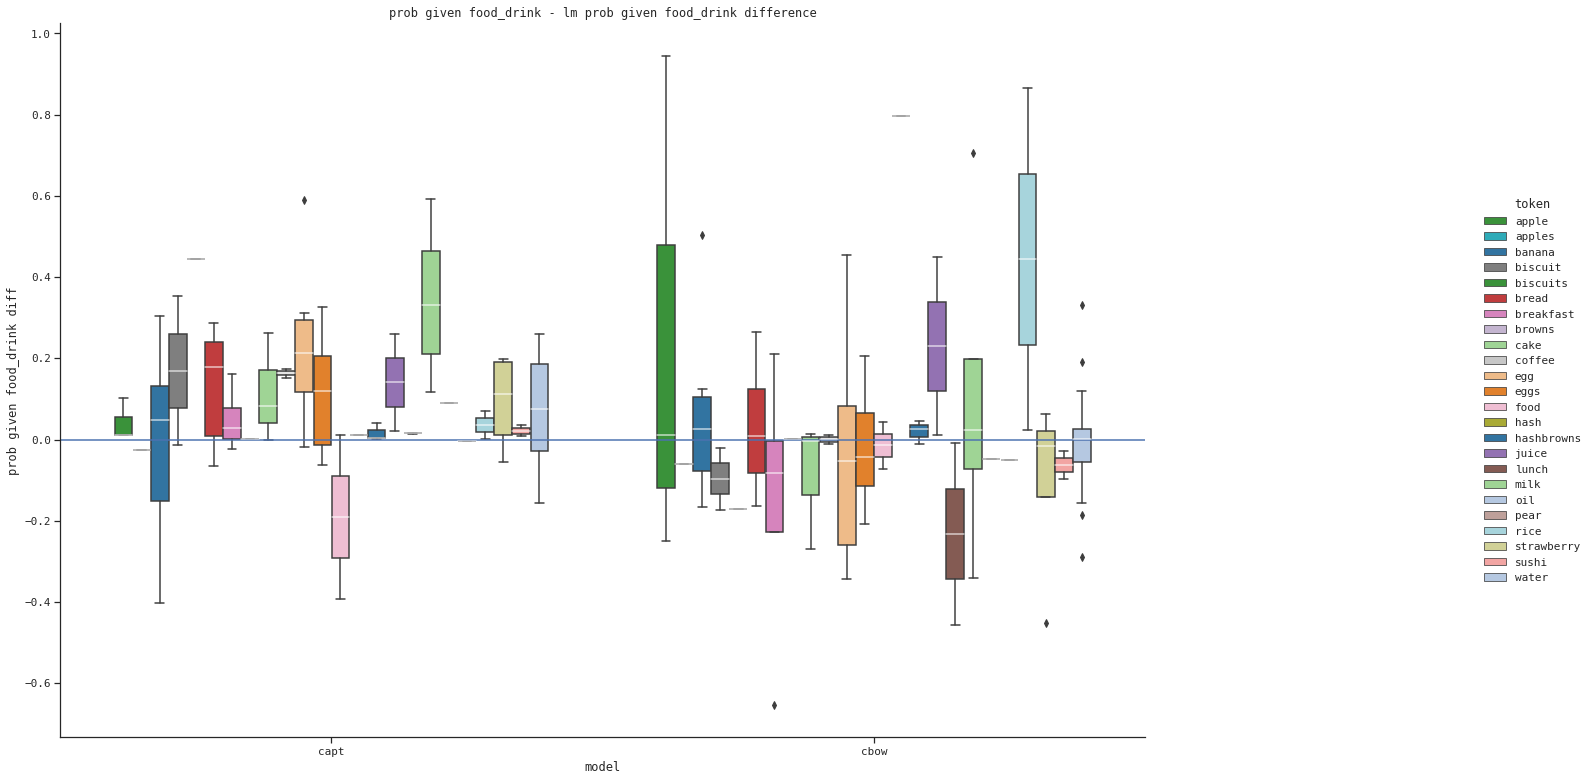

capt:
apple           #examples:     3 mean:  0.041339 t-test result: statistic:   1.36 pvalue: 0.306248
apples          #examples:     1 mean: -0.026284 t-test result: statistic:    nan pvalue:      nan
banana          #examples:     8 mean: -0.008762 t-test result: statistic:  -0.11 pvalue: 0.916439
biscuit         #examples:     2 mean:  0.169176 t-test result: statistic:   0.92 pvalue: 0.525242
biscuits        #examples:     1 mean:  0.444264 t-test result: statistic:    nan pvalue:      nan
bread           #examples:     7 mean:  0.128608 t-test result: statistic:   2.41 pvalue: 0.052877
breakfast       #examples:     4 mean:  0.049692 t-test result: statistic:   1.23 pvalue: 0.305984
browns          #examples:     1 mean:  0.001613 t-test result: statistic:    nan pvalue:      nan
cake            #examples:     3 mean:  0.114409 t-test result: statistic:   1.48 pvalue: 0.276645
coffee          #examples:     2 mean:  0.163430 t-test result: statistic:  14.82 pvalue: 0.042901
egg 

/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


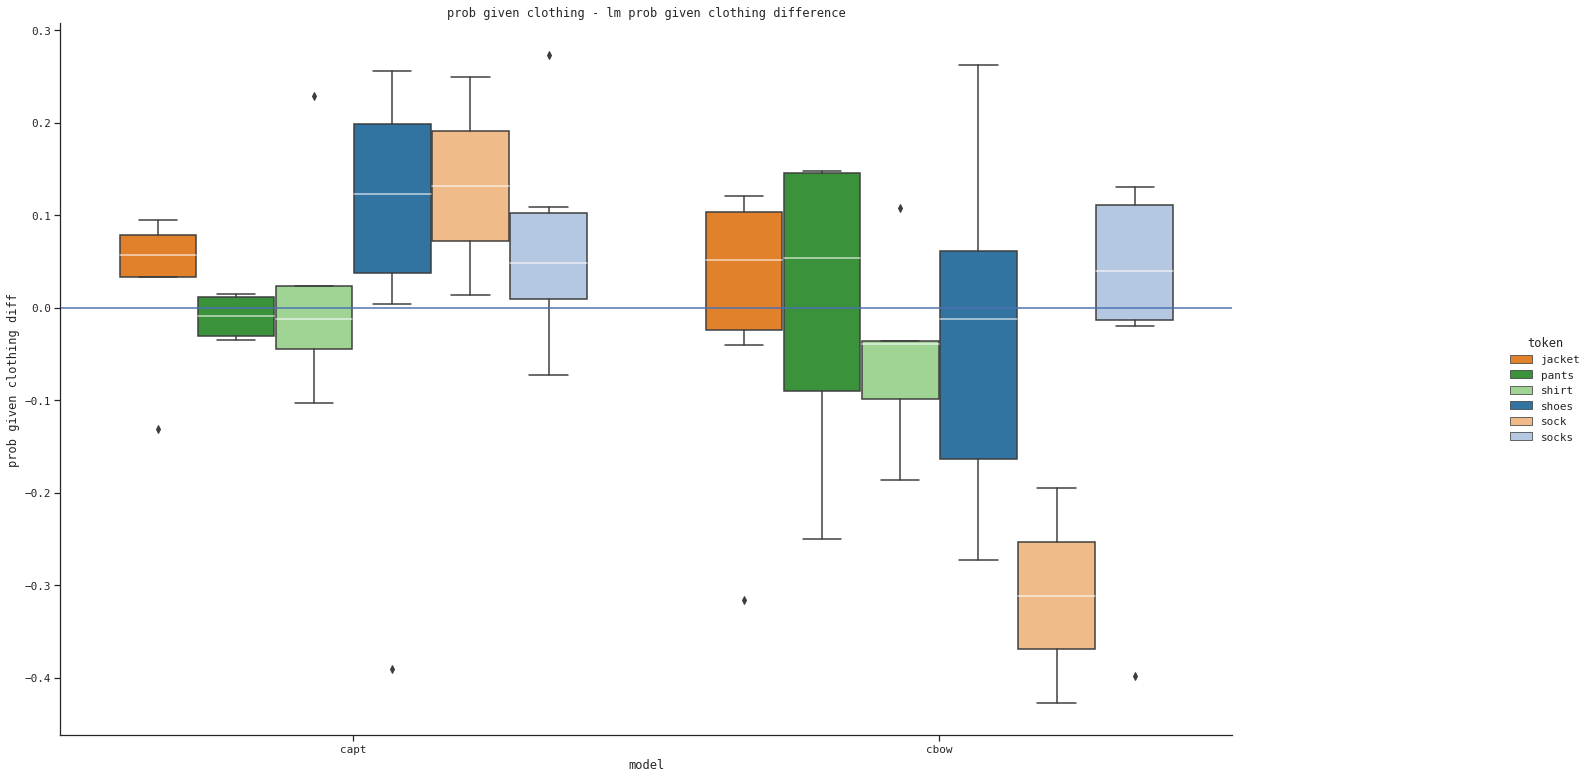

capt:
jacket          #examples:     6 mean:  0.031730 t-test result: statistic:   0.93 pvalue: 0.396261
pants           #examples:     4 mean: -0.009607 t-test result: statistic:  -0.74 pvalue: 0.510825
shirt           #examples:     5 mean:  0.018794 t-test result: statistic:   0.33 pvalue: 0.756494
shoes           #examples:    15 mean:  0.097473 t-test result: statistic:   2.36 pvalue: 0.033088
sock            #examples:     2 mean:  0.131718 t-test result: statistic:   1.11 pvalue: 0.465763
socks           #examples:     6 mean:  0.069056 t-test result: statistic:   1.42 pvalue: 0.213719
all tokens      #examples:    38 mean:  0.062784 t-test result: statistic:   2.99 pvalue: 0.004972
cbow:
jacket          #examples:     6 mean: -0.003548 t-test result: statistic:  -0.05 pvalue: 0.959916
pants           #examples:     4 mean:  0.001437 t-test result: statistic:   0.02 pvalue: 0.988818
shirt           #examples:     5 mean: -0.050644 t-test result: statistic:  -1.06 pvalue: 0.35072

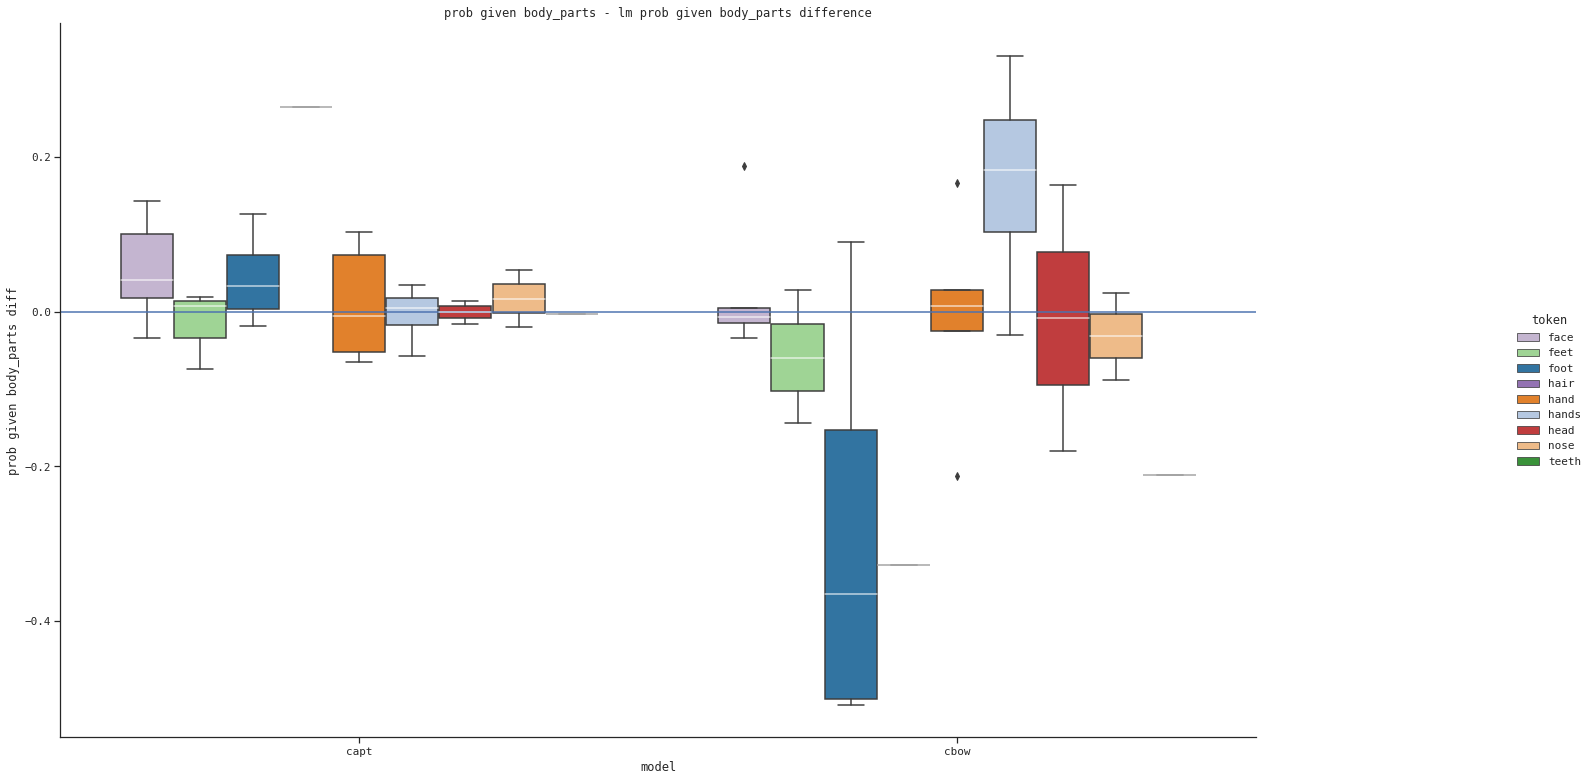

capt:
face            #examples:     5 mean:  0.053664 t-test result: statistic:   1.73 pvalue: 0.159115
feet            #examples:     3 mean: -0.015520 t-test result: statistic:  -0.53 pvalue: 0.650335
foot            #examples:     4 mean:  0.044094 t-test result: statistic:   1.39 pvalue: 0.257592
hair            #examples:     1 mean:  0.265690 t-test result: statistic:    nan pvalue:      nan
hand            #examples:     5 mean:  0.010901 t-test result: statistic:   0.33 pvalue: 0.761063
hands           #examples:     4 mean: -0.003231 t-test result: statistic:  -0.17 pvalue: 0.879058
head            #examples:     2 mean: -0.000491 t-test result: statistic:  -0.03 pvalue: 0.979314
nose            #examples:     2 mean:  0.017059 t-test result: statistic:   0.46 pvalue: 0.724606
teeth           #examples:     1 mean: -0.002101 t-test result: statistic:    nan pvalue:      nan
all tokens      #examples:    27 mean:  0.027276 t-test result: statistic:   1.92 pvalue: 0.065554
cbow

/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


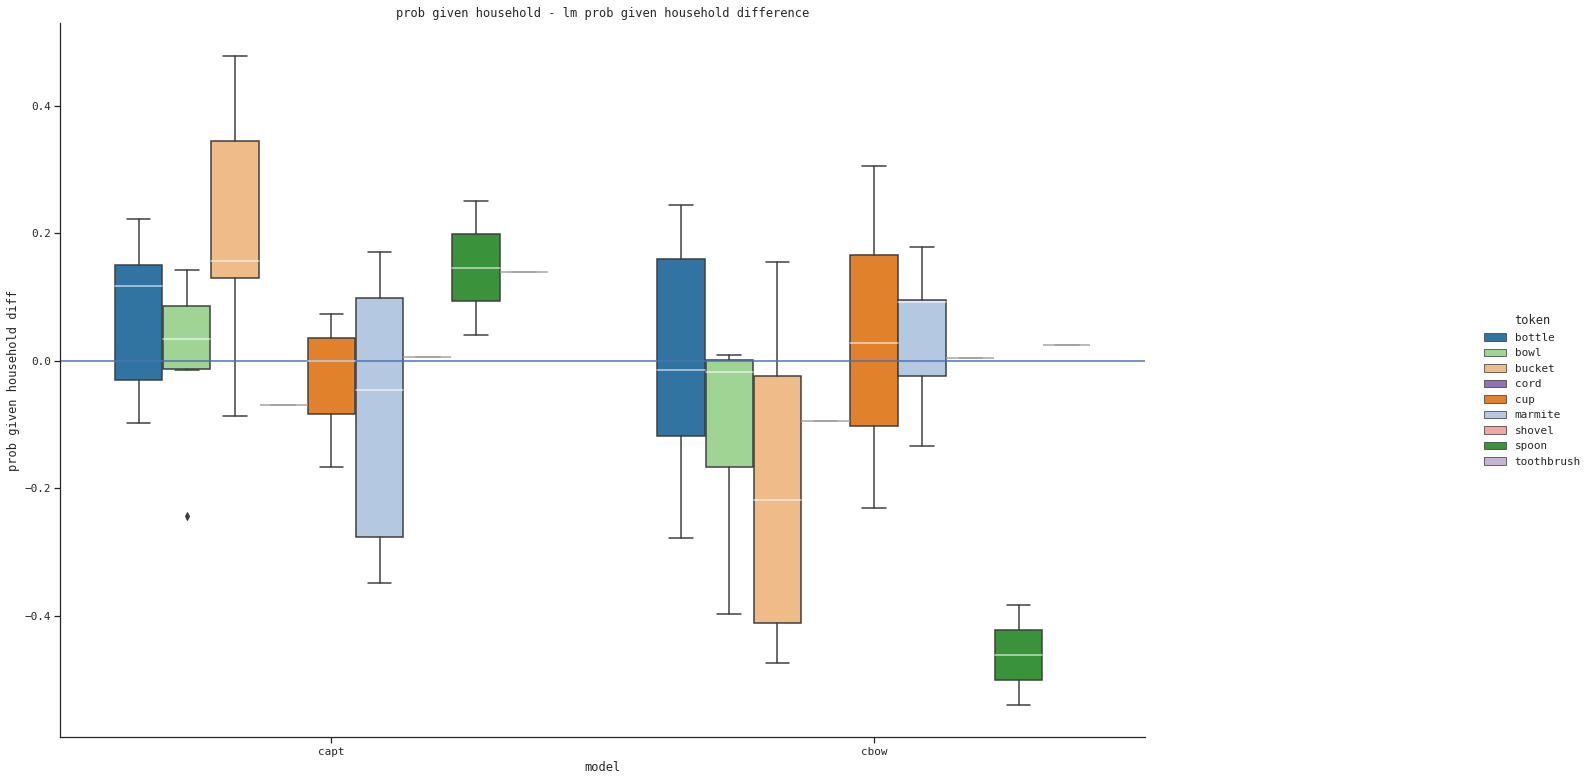

capt:
bottle          #examples:     5 mean:  0.072474 t-test result: statistic:   1.22 pvalue: 0.288309
bowl            #examples:     6 mean:  0.007083 t-test result: statistic:   0.13 pvalue: 0.904058
bucket          #examples:     7 mean:  0.214287 t-test result: statistic:   2.97 pvalue: 0.024909
cord            #examples:     1 mean: -0.068994 t-test result: statistic:    nan pvalue:      nan
cup             #examples:     3 mean: -0.031255 t-test result: statistic:  -0.44 pvalue: 0.702068
marmite         #examples:     5 mean: -0.080489 t-test result: statistic:  -0.79 pvalue: 0.473284
shovel          #examples:     1 mean:  0.006265 t-test result: statistic:    nan pvalue:      nan
spoon           #examples:     2 mean:  0.146240 t-test result: statistic:   1.39 pvalue: 0.396796
toothbrush      #examples:     1 mean:  0.139508 t-test result: statistic:    nan pvalue:      nan
all tokens      #examples:    31 mean:  0.057352 t-test result: statistic:   1.76 pvalue: 0.088976
cbow

/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


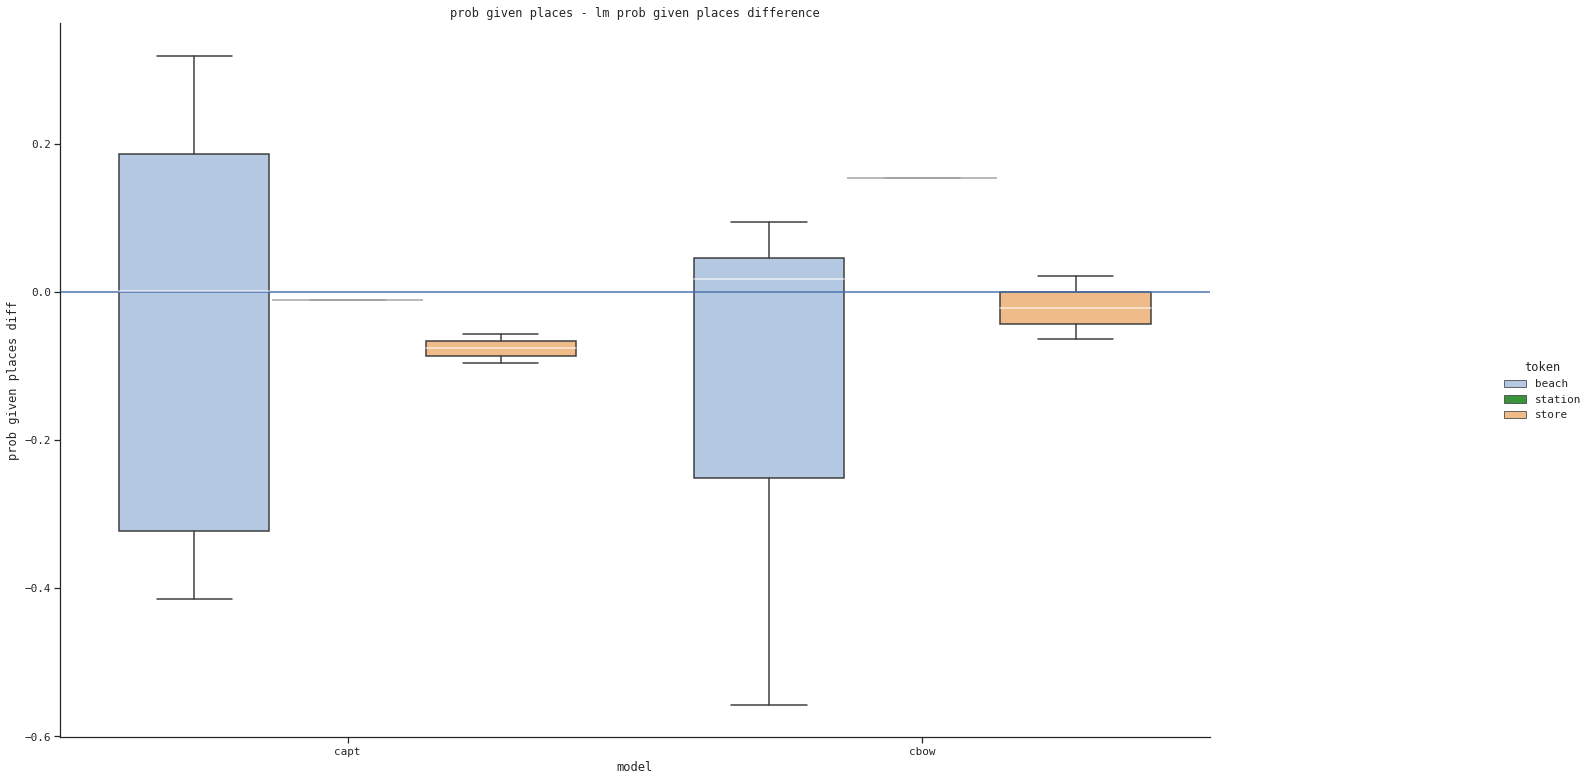

capt:
beach           #examples:     6 mean: -0.045717 t-test result: statistic:  -0.36 pvalue: 0.733959
station         #examples:     1 mean: -0.010617 t-test result: statistic:    nan pvalue:      nan
store           #examples:     2 mean: -0.075861 t-test result: statistic:  -3.79 pvalue: 0.164242
all tokens      #examples:     9 mean: -0.048516 t-test result: statistic:  -0.59 pvalue: 0.572358
cbow:
beach           #examples:     6 mean: -0.118516 t-test result: statistic:  -1.10 pvalue: 0.323392
station         #examples:     1 mean:  0.154650 t-test result: statistic:    nan pvalue:      nan
store           #examples:     2 mean: -0.020987 t-test result: statistic:  -0.49 pvalue: 0.708391
all tokens      #examples:     9 mean: -0.066491 t-test result: statistic:  -0.87 pvalue: 0.411614
games_routines #: 13
bop             #: 13
plotting 26/26 = 100.00% items...


/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ww2135/.local/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


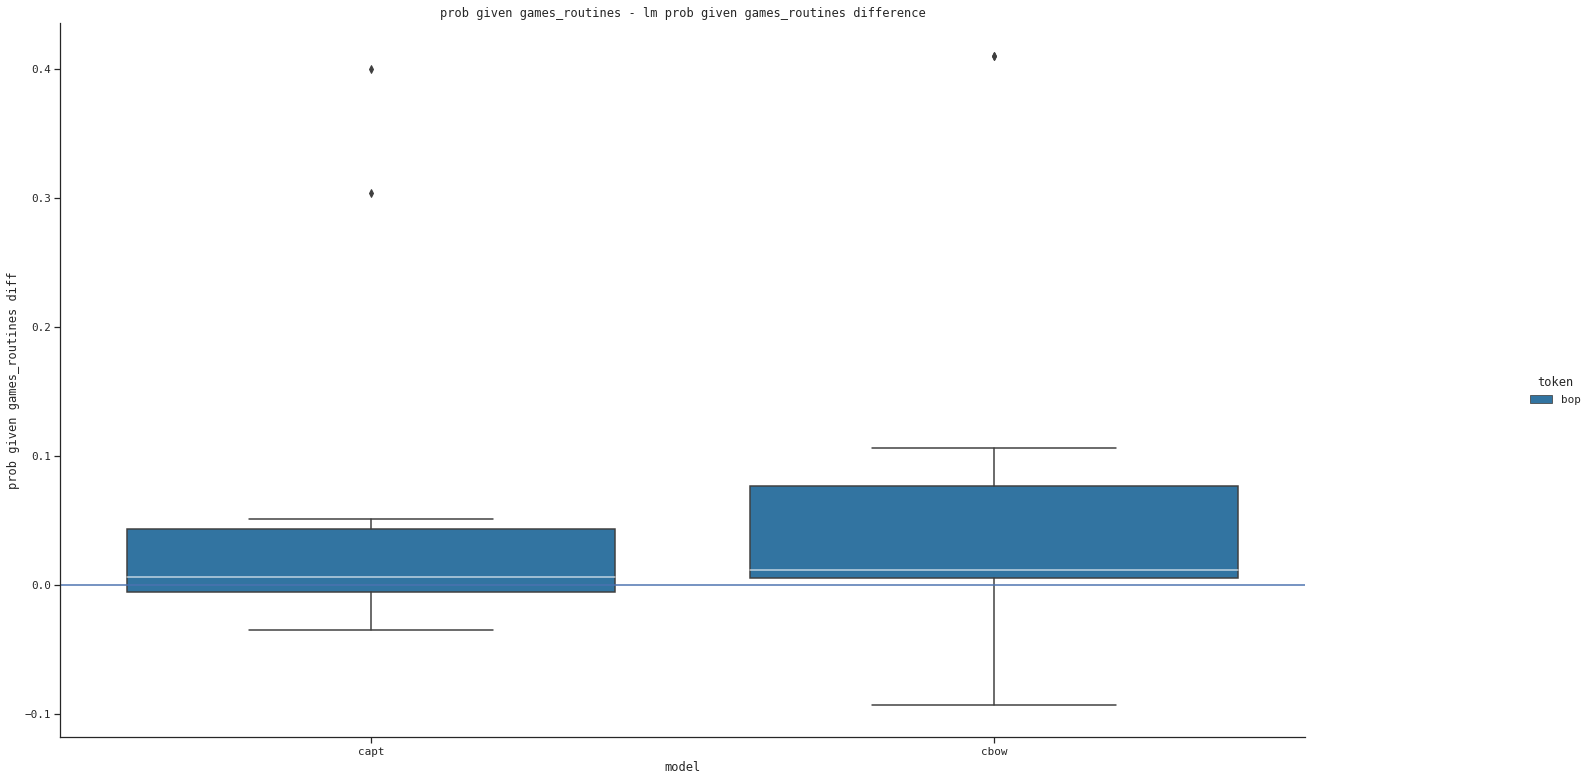

capt:
bop             #examples:    13 mean:  0.058254 t-test result: statistic:   1.57 pvalue: 0.143091
all tokens      #examples:    13 mean:  0.058254 t-test result: statistic:   1.57 pvalue: 0.143091
cbow:
bop             #examples:    13 mean:  0.083452 t-test result: statistic:   1.97 pvalue: 0.072979
all tokens      #examples:    13 mean:  0.083452 t-test result: statistic:   1.97 pvalue: 0.072979


In [21]:
subcat2word_ids = {
    subcat_name: [word2idx[word] for word in subcat_words if word in word2idx]
    for subcat_name, subcat_words in subcats}
all_subcat_words = list(itertools.chain.from_iterable(subcat_words for subcat_name, subcat_words in subcats))
all_subcat_words = [word for word in all_subcat_words if word in word2idx]
all_subcat_word_ids = [word2idx[word] for word in all_subcat_words]


def analyze_subcat_value_diff(all_items, baseline_name=names[0], plotting_subcats=False):
    p_field = 'prob'
    ps_field = 'probs'
    subcat_field = 'subcat'
    ttest_alternative = 'two-sided'

    items = all_items[all_items['pos2'].isin(['noun']) & all_items[token_field].isin(all_subcat_words)].copy()
    items[subcat_field] = items[token_field].map(word2subcat).astype('category')
    print(f'#: {len(items)}')

    p_cats_field = 'prob cats'
    p_subcat_field = 'prob subcat'
    p_subcat_given_cats_field = 'prob subcat given cats'
    for name in names:
        name_ps_field = f'{name} {ps_field}'
        name_p_cats_field = f'{name} {p_cats_field}'
        name_p_subcat_field = f'{name} {p_subcat_field}'
        name_p_subcat_given_cats_field = f'{name} {p_subcat_given_cats_field}'
        items[name_p_cats_field] = items[name_ps_field].map(lambda p: np.sum(p[all_subcat_word_ids]))
        items[name_p_subcat_field] = items.apply(lambda item: np.sum(item[name_ps_field][subcat2word_ids[item[subcat_field]]]), axis=1)
        items[name_p_subcat_given_cats_field] = items[name_p_subcat_field] / items[name_p_cats_field]
        if name != baseline_name:
            extend_items_value_diff(items, name, baseline_name, p_subcat_given_cats_field)
    analyze_value_diff(
        items.reset_index(drop=True),
        p_subcat_given_cats_field,
        names,
        baseline_name=baseline_name,
        cat_field=subcat_field,
        palette=subcat_palette,
        ttest_alternative=ttest_alternative,
    )

    for subcat_name, subcat_words in subcats:
        items = all_items[all_items['pos2'].isin(['noun']) & all_items[token_field].isin(subcat_words)].copy()
        items[token_field] = items[token_field].astype('category')
        print(f'{subcat_name:14} #: {len(items)}')
        palette = sns.color_palette('tab20')
        palette = {word: palette[i % len(palette)] for i, word in enumerate(subcat_words)}
        p_subcat_field = f'prob {subcat_name}'
        p_given_subcat_field = f'prob given {subcat_name}'
        for name in names:
            name_p_field = f'{name} {p_field}'
            name_ps_field = f'{name} {ps_field}'
            name_p_subcat_field = f'{name} {p_subcat_field}'
            name_p_given_subcat_field = f'{name} {p_given_subcat_field}'
            items[name_p_subcat_field] = items[name_ps_field].map(lambda p: np.sum(p[subcat2word_ids[subcat_name]]))
            items[name_p_given_subcat_field] = items[name_p_field] / items[name_p_subcat_field]
            if name != baseline_name:
                extend_items_value_diff(items, name, baseline_name, p_given_subcat_field)
        analyze_value_diff(
            items.reset_index(drop=True),
            p_given_subcat_field,
            names,
            baseline_name=baseline_name,
            cat_field=token_field,
            palette=palette,
            plotting=plotting_subcats,
            ttest_alternative=ttest_alternative,
        )


for split in ['val']:
    analyze_subcat_value_diff(split_items[split].all_token_items)

lm:
noun_verb:
plotting 50/1597 = 3.13% items...


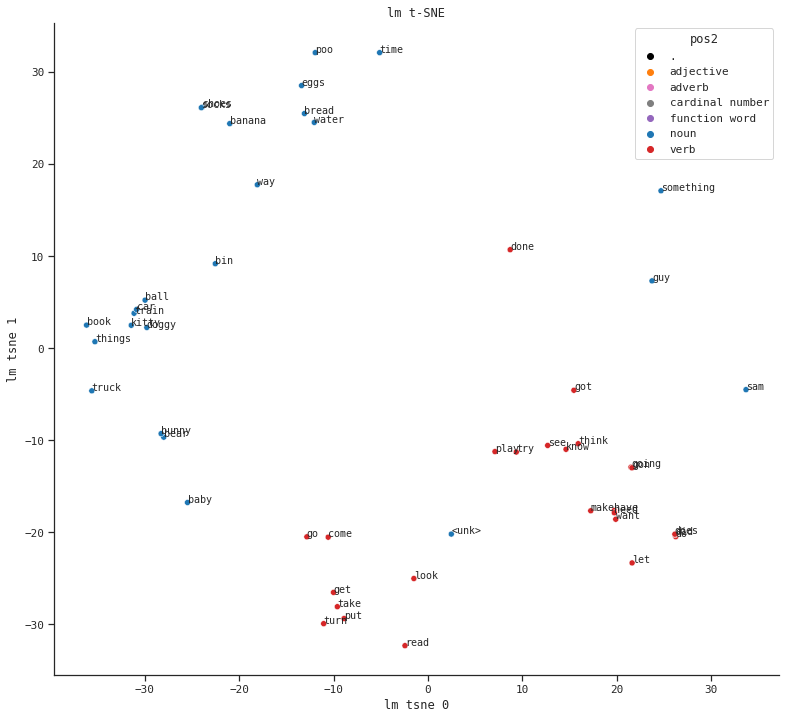

plotting 50/1597 = 3.13% items...


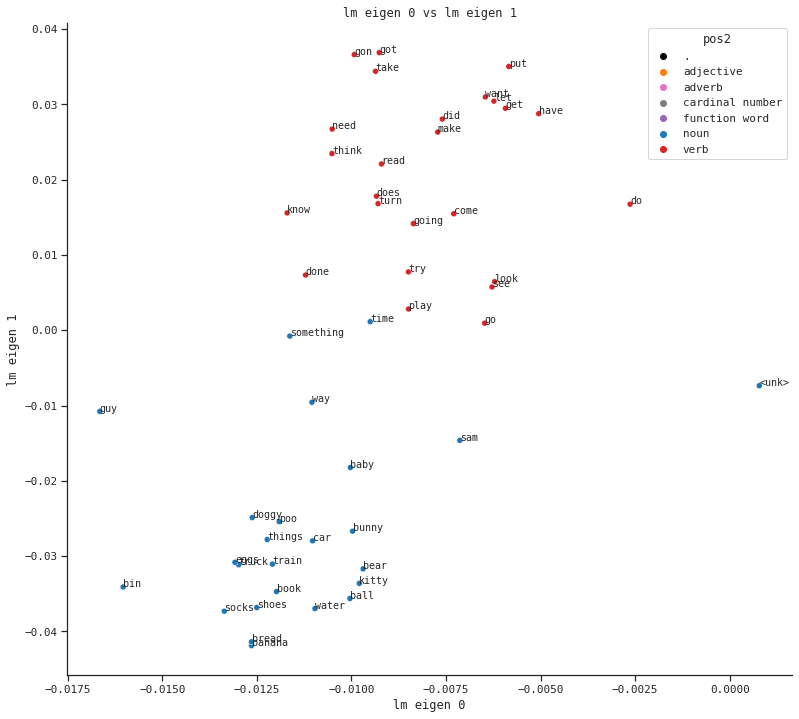

noun:
plotting 48/48 = 100.00% items...


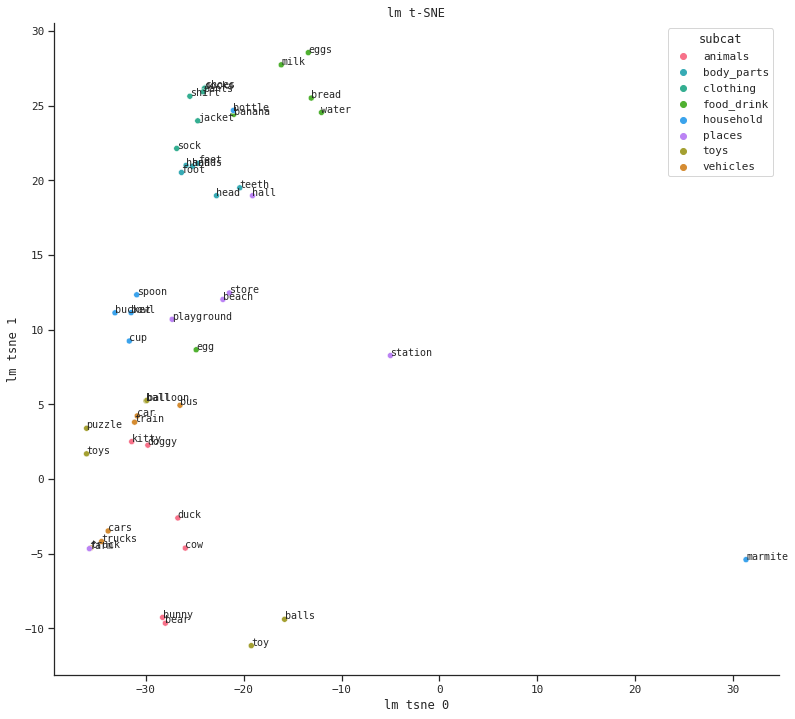

plotting 48/48 = 100.00% items...


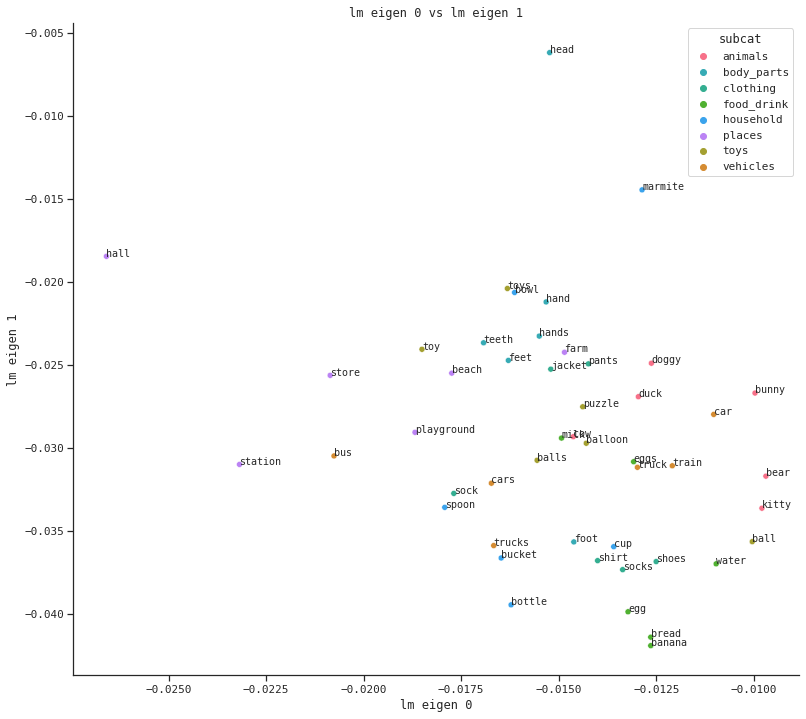

verb:
plotting 50/496 = 10.08% items...


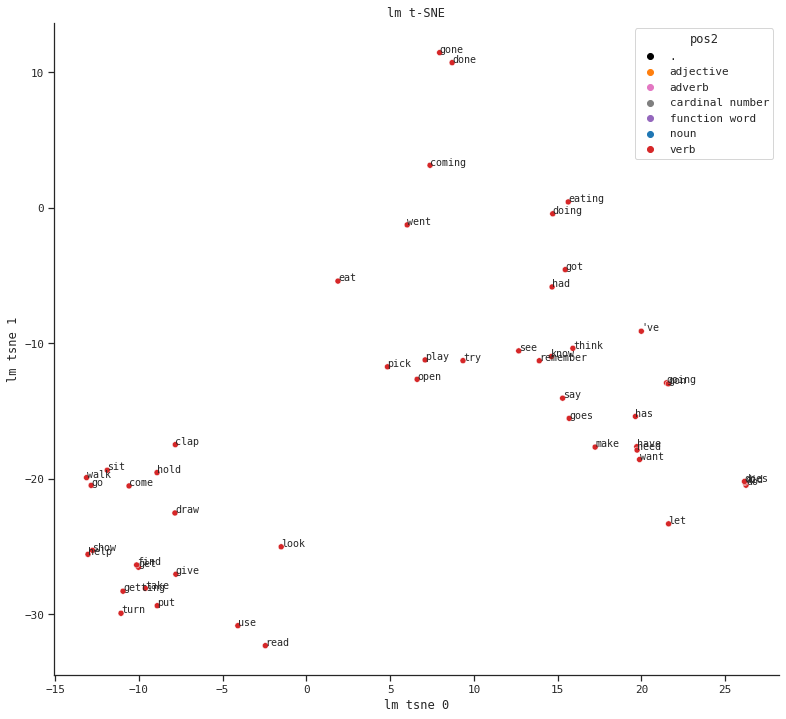

plotting 50/496 = 10.08% items...


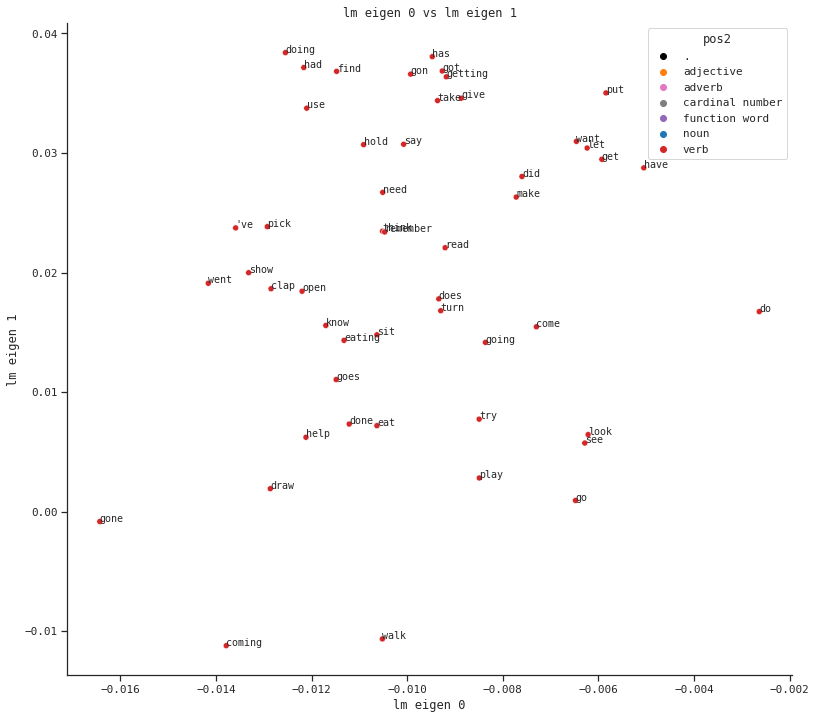

capt:
noun_verb:
plotting 50/1597 = 3.13% items...


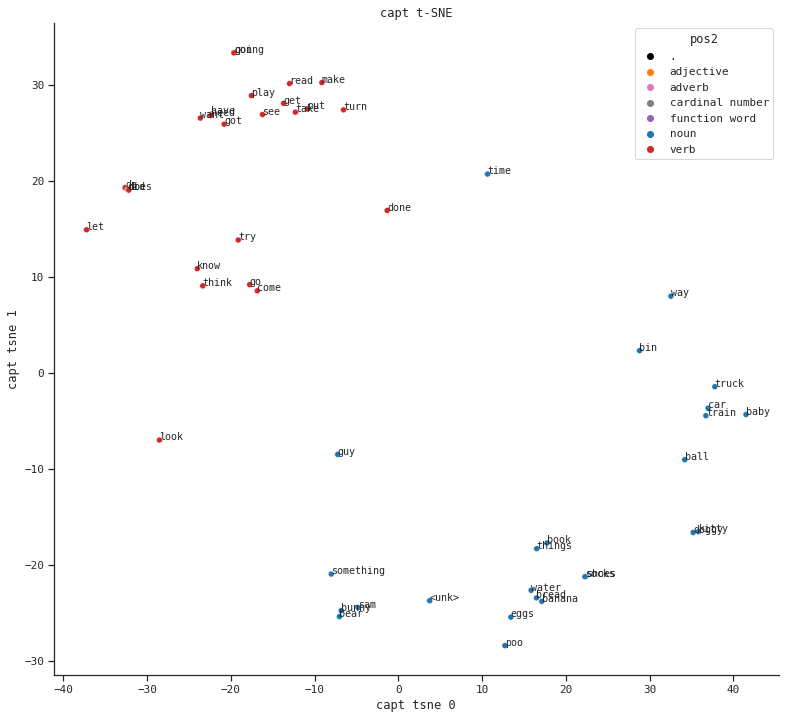

plotting 50/1597 = 3.13% items...


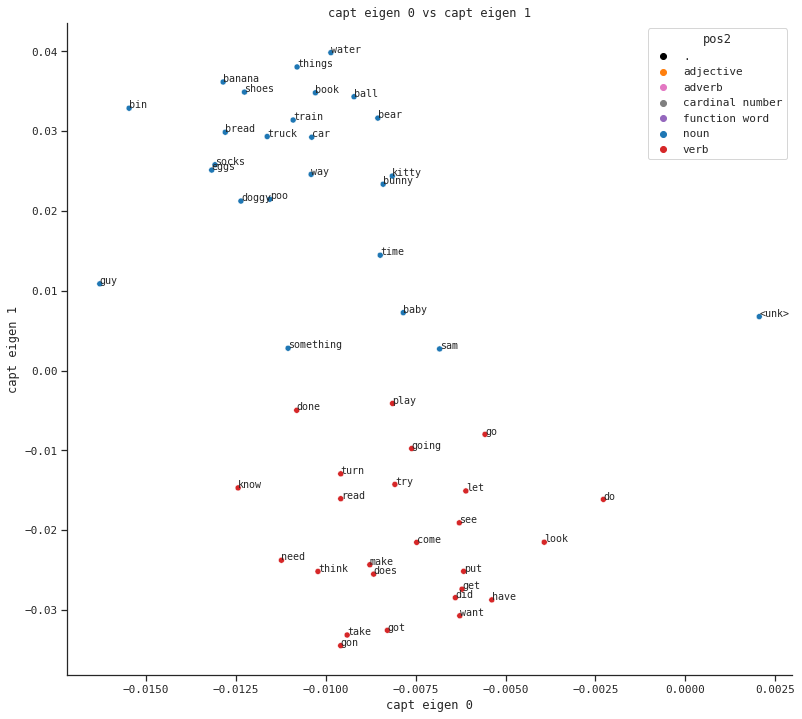

noun:
plotting 48/48 = 100.00% items...


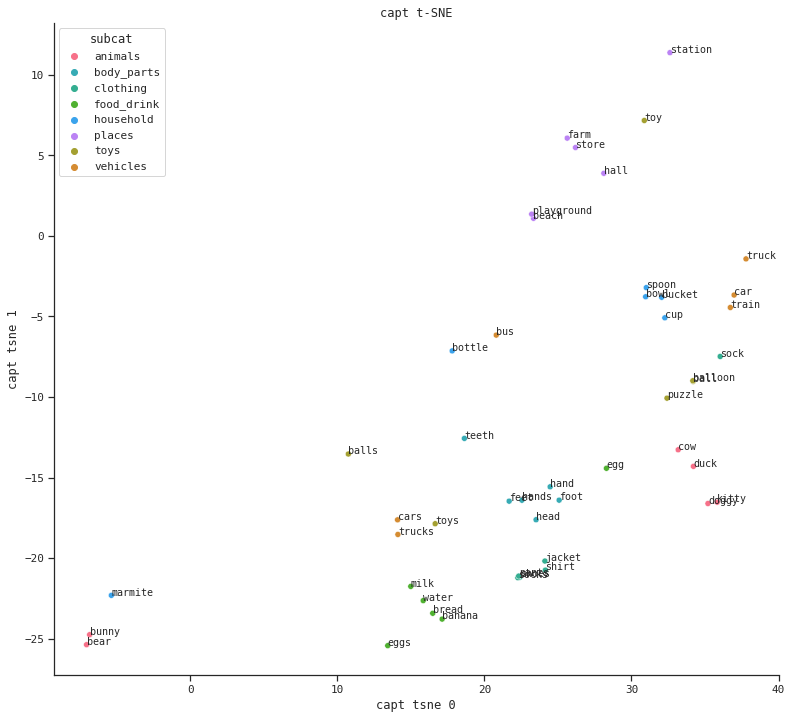

plotting 48/48 = 100.00% items...


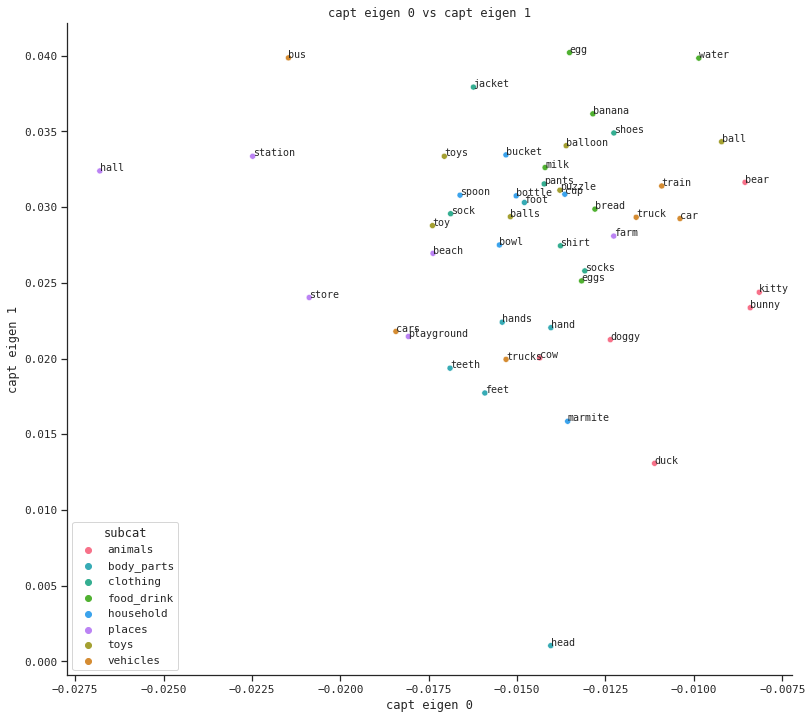

verb:
plotting 50/496 = 10.08% items...


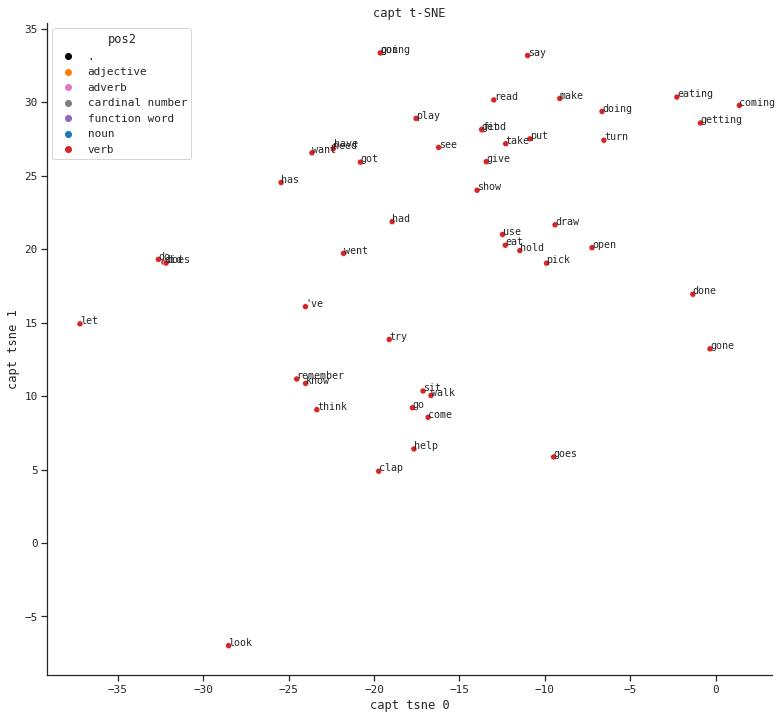

plotting 50/496 = 10.08% items...


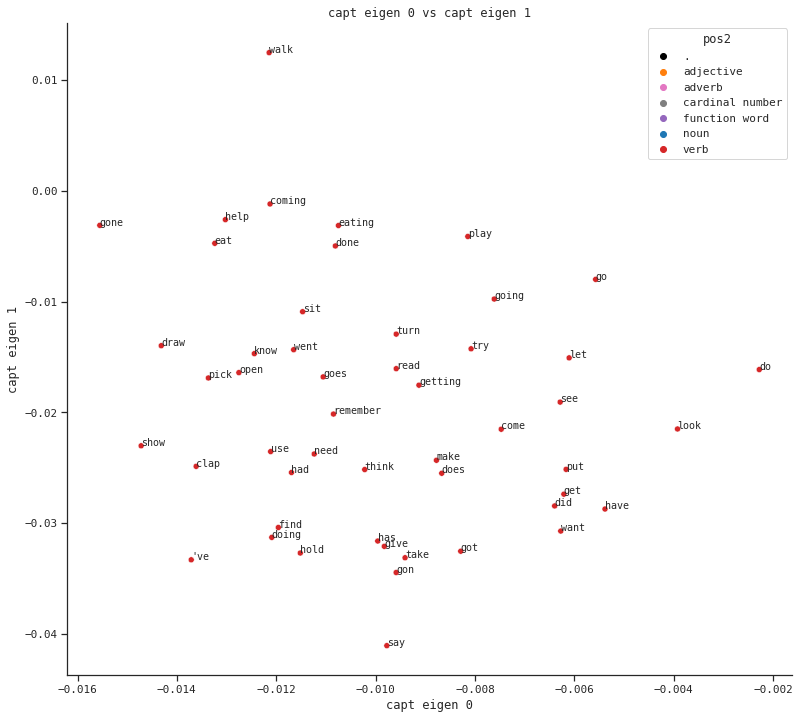

cbow:
noun_verb:
plotting 50/1597 = 3.13% items...


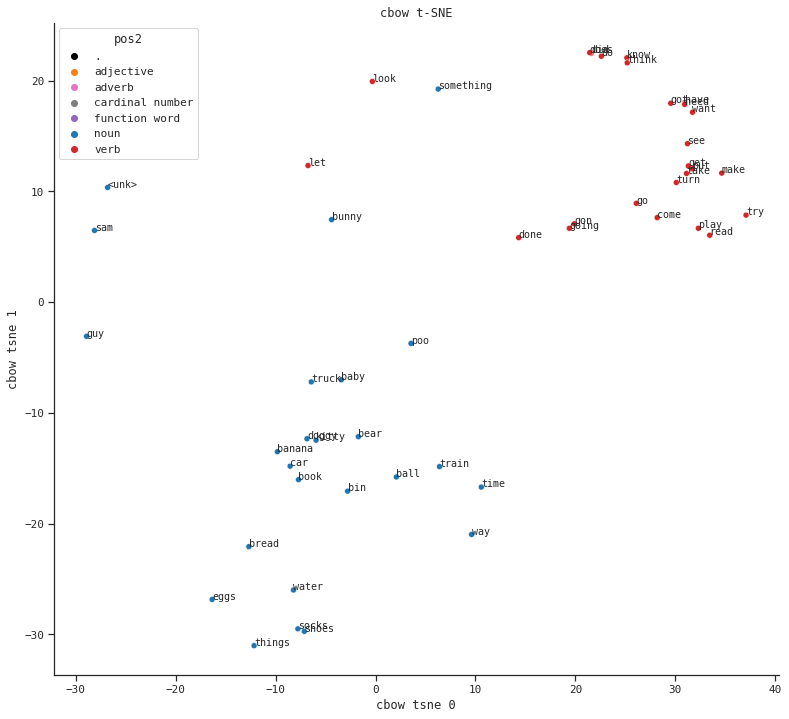

plotting 50/1597 = 3.13% items...


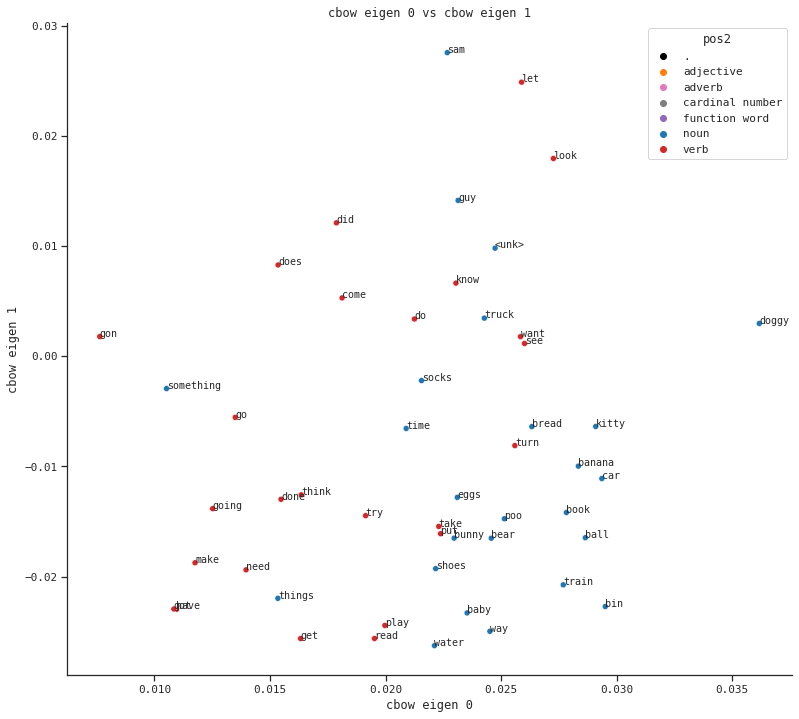

noun:
plotting 48/48 = 100.00% items...


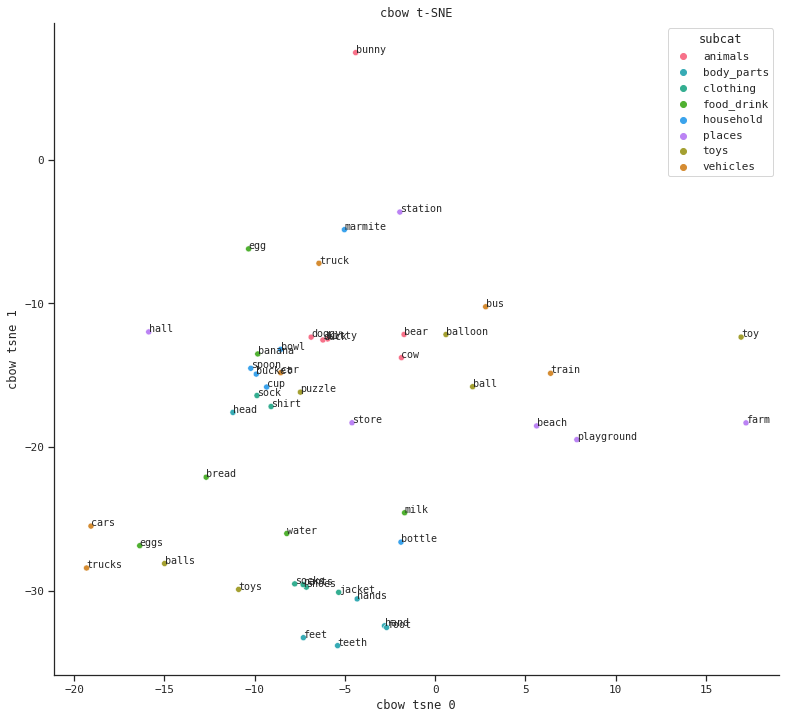

plotting 48/48 = 100.00% items...


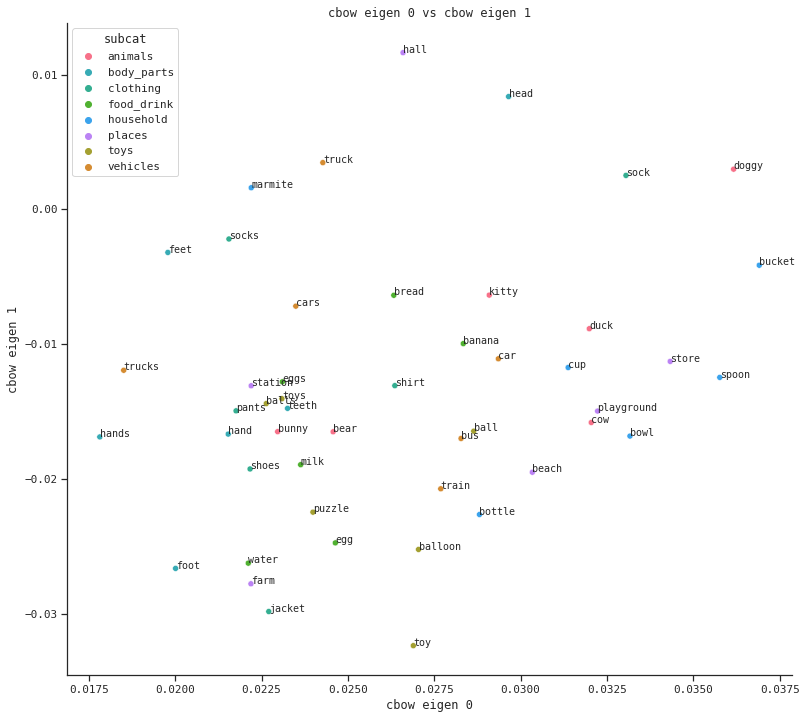

verb:
plotting 50/496 = 10.08% items...


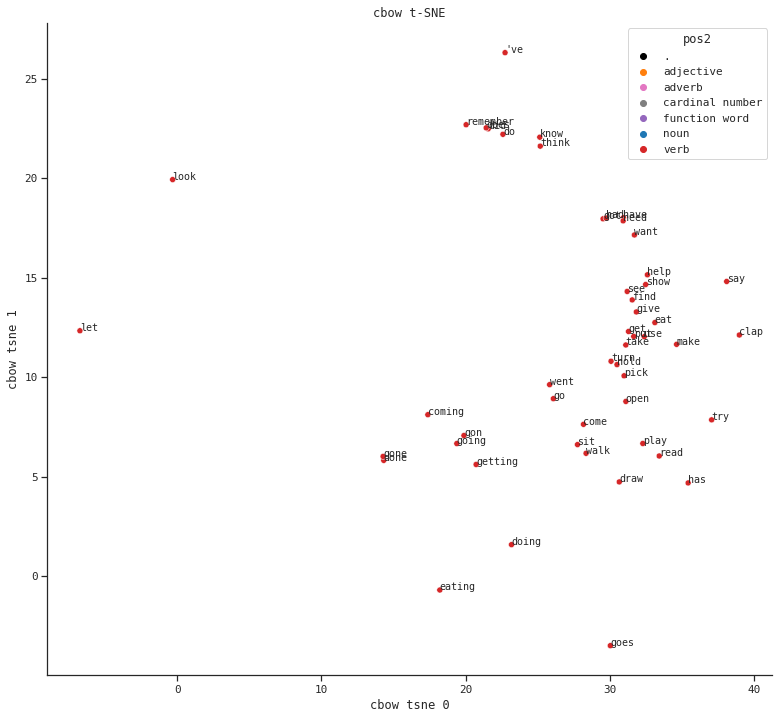

plotting 50/496 = 10.08% items...


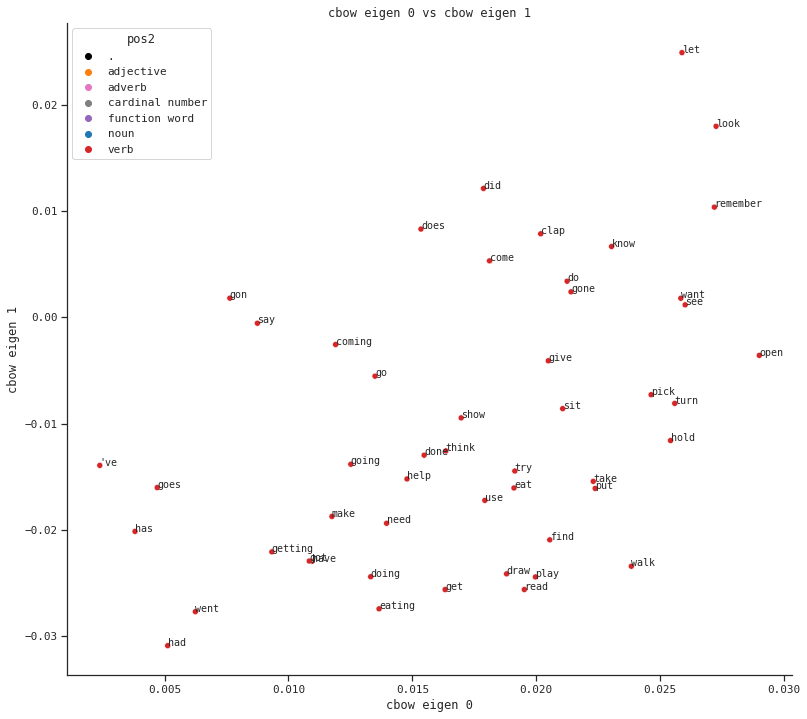

capt:
top:
plotting 224/261 = 85.82% items...


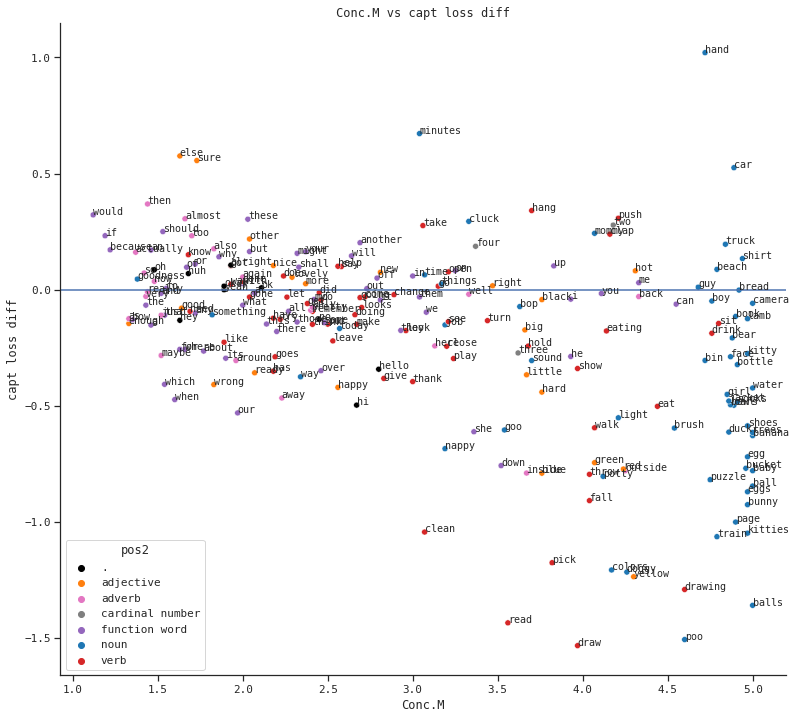

noun:
plotting 27/28 = 96.43% items...


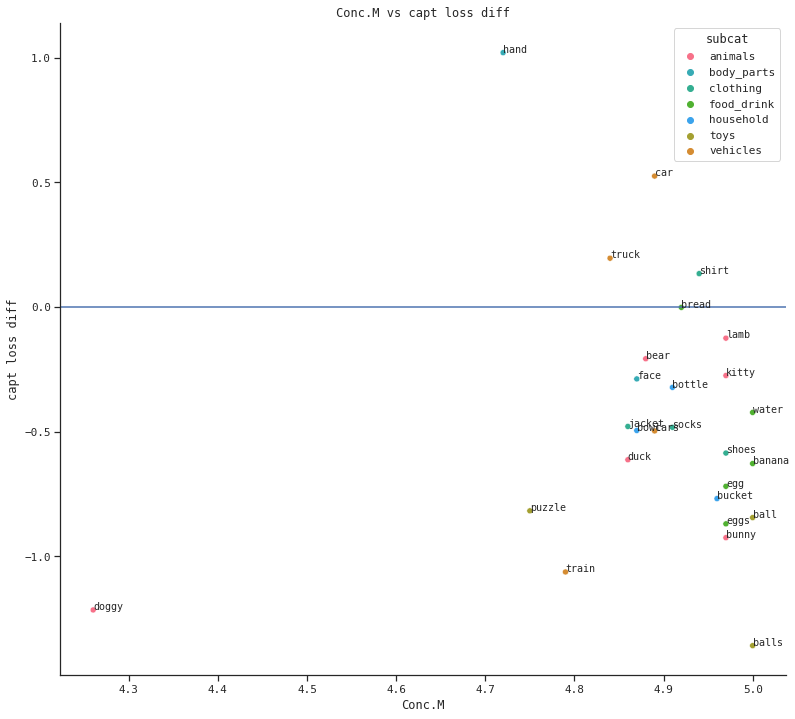

verb:
plotting 55/58 = 94.83% items...


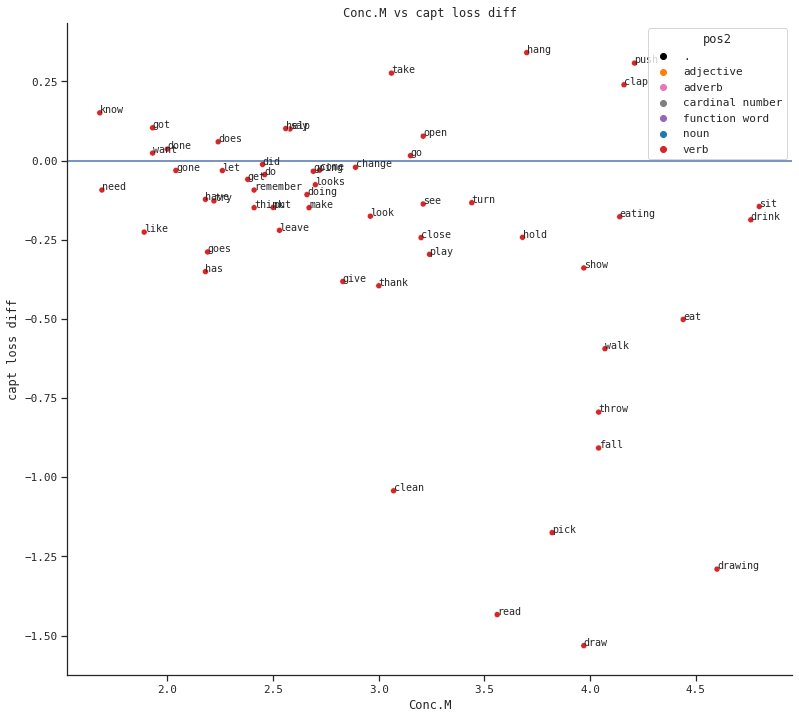

cbow:
top:
plotting 224/261 = 85.82% items...


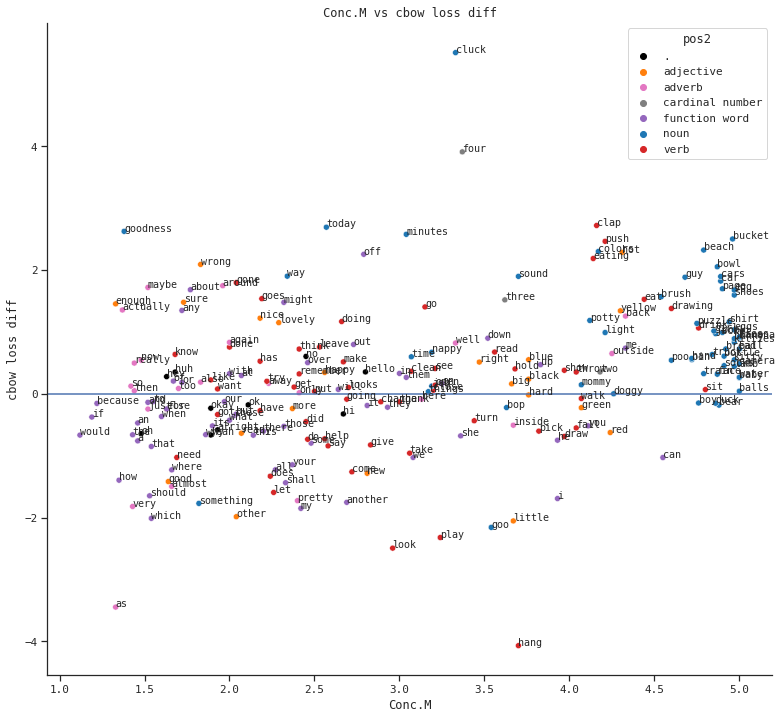

noun:
plotting 27/28 = 96.43% items...


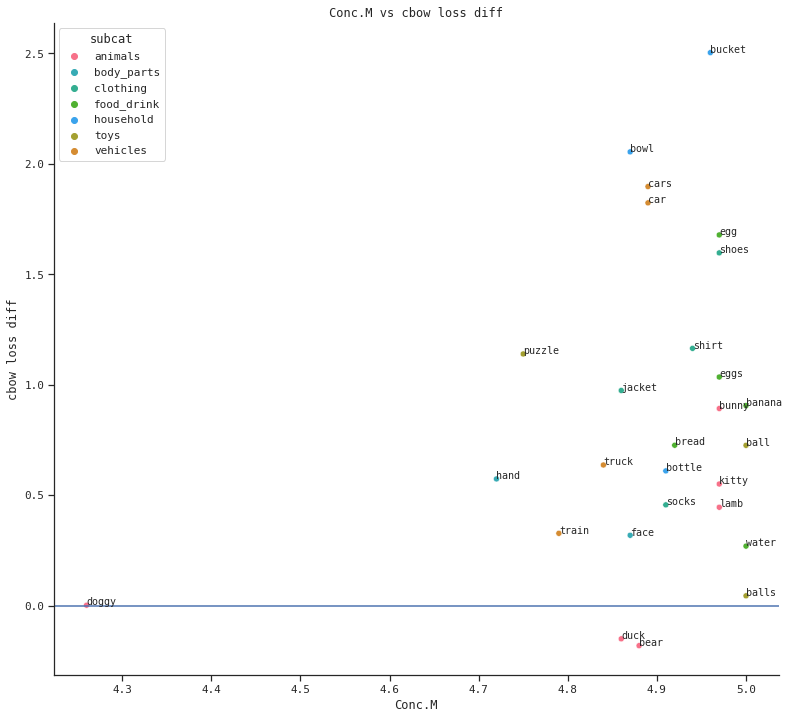

verb:
plotting 55/58 = 94.83% items...


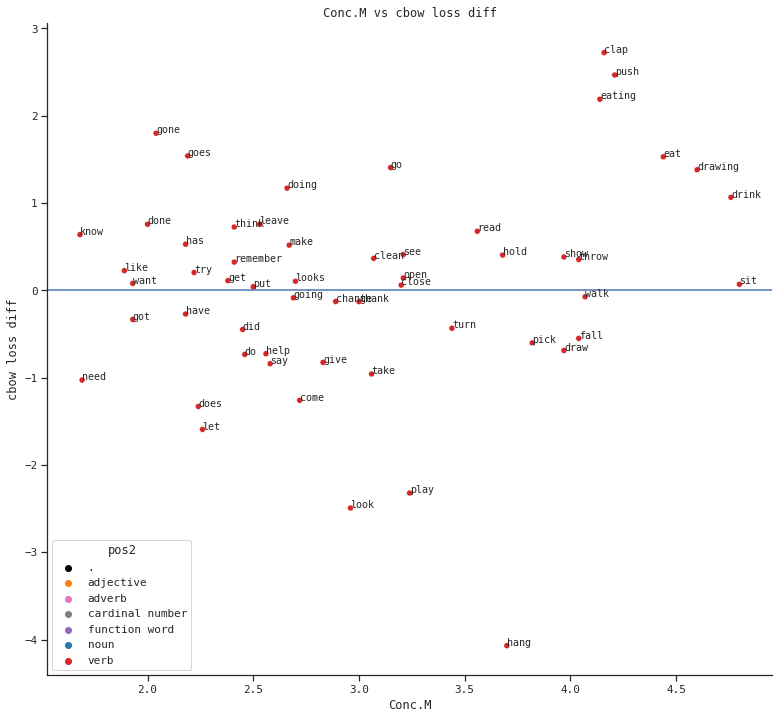

In [22]:
pos_field = "pos2"

baseline_name = names[0]

item_combinations = lambda split: (
    ("all", split_all_pos_items[split], None),
    ("top", split_all_pos_items[split], len(used_poses) * interleaving_step * (25 // interleaving_step)),
    ('noun_verb', split_pos_pos_items[split][('noun', 'verb')], None),
    ('noun_verb', split_pos_pos_items[split][('noun', 'verb')], 2 * interleaving_step * (25 // interleaving_step)),
    ('noun', get_subcat_items(split_pos_items[split]['noun']), 10000),
    ('verb', split_pos_items[split]['verb'], 50),
)

for split in ['train']:
    for name in names:
        print(f'{name}:')
        loss_field = f'{name} loss'
        loss_diff_field = f'{name} loss diff'
        fields = [pos_field, "cnt", "logcnt", conc_field, "AnimPhysical", "AnimMental", "Category", "AoA", loss_field, loss_diff_field]

        for items_name, items, n_items in item_combinations(split)[3:]:
            print(f'{items_name}:')
            token_kwargs = {'fontsize': 'small'} if n_items is not None else None
            pos_hue = subcat_field if items_name == 'noun' else pos_field

            for hue, x, y, title, plot_reg in [
                (pos_hue, f"{name} tsne 0", f"{name} tsne 1", f"{name} t-SNE", False),
                (pos_hue, f"{name} eigen 0", f"{name} eigen 1", "vs", False),
                (pos_hue, f"{name} eigen 0", conc_field, "vs", True),
            ][:2]:
                plot(sns.scatterplot, items, x=x, y=y, hue=hue, n_items=n_items, token_kwargs=token_kwargs, title=title)
                if plot_reg:
                    plot(sns.regplot, items, x=x, y=y, n_items=n_items, token_kwargs=token_kwargs, title=title)

for split in ['val']:
    for name in filter(lambda name: name != baseline_name, names):
        print(f'{name}:')
        loss_field = f'{name} loss'
        loss_diff_field = f'{name} loss diff'

        item_combinations_split = item_combinations(split)
        item_combinations_split = item_combinations_split[1:2] + item_combinations_split[4:6]
        for items_name, items, n_items in item_combinations_split:
            print(f'{items_name}:')
            token_kwargs = {'fontsize': 'small'} if n_items is not None else None
            pos_hue = subcat_field if items_name == 'noun' else pos_field

            loss_diff_items = items.sort_values(loss_diff_field)
            if n_items is not None:
                loss_diff_items = loss_diff_items[loss_diff_items['cnt'] >= 5]
                if n_items * 2 >= len(loss_diff_items):
                    n_items = len(loss_diff_items)
            plot(sns.scatterplot, loss_diff_items, x=conc_field, y=loss_diff_field, hue=pos_hue, n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs")
            if n_items is None and False:
                plot(sns.regplot, loss_diff_items, x=conc_field, y=loss_diff_field, n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs")
                #plot(sns.catplot, loss_diff_items, x=pos_field, y=loss_diff_field, n_items=n_items, color="b", hlines=[0], title="vs") #kind="violin", inner="stick",
            if n_items is not None and n_items < len(loss_diff_items):
                print('highest:')
                plot(sns.scatterplot, loss_diff_items[::-1], x=conc_field, y=loss_diff_field, hue=pos_hue, n_items=n_items, hlines=[0], token_kwargs=token_kwargs, title="vs")